# TRABAJO FIN DE MASTER - MODELOS DE PREDICCIÓN - MAG8
# **Author**: Cristóbal León-Salas
# **Date**: 2025-11-04

# LIBRERIAS

Se cargan las siguietnes librerias:

-  pandas --> Para tablas de datos.
-  numpy --> para cálculos numéricos y para trabajar con matrices y vectores.
-  os --> Para trabajar con directorios, archivos, carpetas,...
-  json --> Para trabajar con datos en formato JSON
-  shap --> Para explicar las predicciones de modelos de machine learning mediante valores de contribución basados en teoría de juegos.
-  matplotlib --> Para hacer visualizaciones gráficas básicas.
-  seaborn --> Para gráficos estadísticos más profesionales y de fácil interpretación.
-  warnings --> Para evitar mensajes de advertencias
-  product -->  Para sacar todas las combinaciones posibles entre los elementos de dos o más lista
-  display --> Para sacar tablas con formato.
-  KNeighborsRegressor --> Para obtener pronóstico con K-vecinos
-  ExponentialSmoothing --> Para hacer predicciones con suavizados exponenciales (Holt-Winters)
-  folium --> Para representación georreferenciada
-  unicodedata --> Permite manejar caracteres Unicode, como letras con acentos, eñes, tildes, etc.
-  re --> Es la librería estándar de Python para trabajar con expresiones regulares. Se usa para encontrar o reemplazar patrones de texto.
-  StandardScaler --> Para el normalizado y escalado de las variables
-  PCA --> Para llevar a cabo la técnica de componentes principales
-  mean_absolute_error, mean_squared_error --> Para hallar las métricas de los modelos
-  LGBMRegressor --> Para aplicar modelo LGBM
-  XGBRegressor--> Para aplicar modelos XGBOOST
-  CatBoostRegressor --> Para ejecutar modelos CatBoost
-  Prophet --> Para aplciar modelos Prophet
-  itertools --> Para hacer iteraciones eficientes
-  adfuller --> Ejecuta el test de Dickey–Fuller aumentado (ADF), que sirve para verificar si una serie temporal es estacionaria o no.
-  plot_acf, plot_pacf --> Para sacar los gráficos ACF y PACF
-  import SARIMAX --> Para aplicar modelos SARIMA
-  LSTM --> Captura dependencias temporales largas en series temporales
-  Dense --> Transforma la salida de capas anteriores en predicciones o activaciones
-  Conv1D --> Detecta patrones locales o estacionales en series temporales
-  GlobalAveragePooling1D --> Resume la información de toda la secuencia para clasificación o regresión
-  InputLayer --> Útil para modelos más personalizados o cuando no se usa input_shape en la primera capa
-  EarlyStopping --> Permito que los modelos deep learning se paren cuando ndeja de mejorar la validación. Ayuda a mitigar el sobreajuste


In [1]:
import pandas as pd
import numpy as np
import os
import json
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import product
from IPython.display import display
import folium
from ydata_profiling import ProfileReport
from skimpy import skim
import unicodedata
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from prophet import Prophet
import lightgbm as lgb
from openpyxl import load_workbook
from pathlib import Path
from statsmodels.tsa.arima.model import ARIMA
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, GlobalAveragePooling1D, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
import random

# Ignorar el SettingWithCopyWarning
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
sns.set()

# FUNCIONES

## FUNCIÓN resumen_mediciones

Esta función re genera un resumen estadístico de los días en los que se superaron los valores límiter de concentración de contaminantes (en este caso, 40 µg/m³) perjudiciales para la salud humanda en una zona determinada.

In [2]:
def resumen_mediciones(df, zona, VL=40):
    df_filtrado = df[df["MEDICION_ugm3"] > VL].copy()
    total_dias = df_filtrado.shape[0]
    total_registros = df.shape[0]
    porcentaje_superan = round((total_dias / total_registros) * 100, 2) if total_registros > 0 else 0

    df_filtrado["AÑO"] = df_filtrado["DIA/MES/ANO"].dt.year
    df_filtrado["MES_NUM"] = df_filtrado["DIA/MES/ANO"].dt.month
    mapa_meses = {
        1: "enero", 2: "febrero", 3: "marzo", 4: "abril",
        5: "mayo", 6: "junio", 7: "julio", 8: "agosto",
        9: "septiembre", 10: "octubre", 11: "noviembre", 12: "diciembre"
    }
    df_filtrado["MES"] = df_filtrado["MES_NUM"].map(mapa_meses)

    if not pd.api.types.is_categorical_dtype(df_filtrado["dow"]):
        categorias_ordenadas = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]
        df_filtrado["dow"] = pd.Categorical(df_filtrado["dow"], categories=categorias_ordenadas, ordered=True)
    df_filtrado["DIA_SEMANA"] = df_filtrado["dow"]

    conteo_mes_anio = (
        df_filtrado.groupby(["AÑO", "MES_NUM", "MES"])
        .size()
        .reset_index(name=f"DIAS_SUPERAN_{VL}")
        .sort_values(by=["AÑO", "MES_NUM"])
        .drop(columns=["MES_NUM"])
    )

    conteo_dia_semana = (
        df_filtrado["DIA_SEMANA"]
        .value_counts()
        .reindex(df_filtrado["DIA_SEMANA"].cat.categories)
        .reset_index(name=f"DIAS_SUPERAN_{VL}")
        .rename(columns={"index": "DIA_SEMANA"})
    )

    return {
        "zona": zona,
        "total_dias": total_dias,
        "porcentaje_superan": porcentaje_superan,
        "conteo_mes_anio": conteo_mes_anio,
        "conteo_dia_semana": conteo_dia_semana
    }

## FUNCIÓN preparar_conteo_trimestral

In [3]:
def preparar_conteo_trimestral(resumen_dict, vl=40):
    """
    Toma el diccionario devuelto por `resumen_mediciones` y
    agrega el conteo por trimestre (1T, 2T, 3T, 4T), garantizando
    que todos los trimestres del periodo estén representados,
    incluso si no hubo datos en alguno de ellos.
    """
    conteo = resumen_dict["conteo_mes_anio"].copy()

    # Determinar número de mes si no existe
    if "MES_NUM" not in conteo.columns:
        MESES_REV = {v:k for k,v in MESES_MAP.items()}
        conteo["MES_NUM"] = conteo["MES"].map(MESES_REV)
    
    # Crear trimestre y etiqueta
    conteo["TRIMESTRE"] = np.ceil(conteo["MES_NUM"] / 3).astype(int)
    conteo["LABEL_TRIM"] = conteo["TRIMESTRE"].astype(str) + "T " + conteo["AÑO"].astype(str)

    dias_col = f"DIAS_SUPERAN_{vl}"

    # Agregación real
    conteo_trim = (
        conteo.groupby(["AÑO", "TRIMESTRE", "LABEL_TRIM"], as_index=False)[dias_col]
        .sum()
    )

    # *** NUEVO: Generar rejilla completa de trimestres existentes en el rango de años ***
    años = np.arange(conteo["AÑO"].min(), conteo["AÑO"].max() + 1)
    base = pd.MultiIndex.from_product([años, [1, 2, 3, 4]], names=["AÑO", "TRIMESTRE"]).to_frame(index=False)
    base["LABEL_TRIM"] = base["TRIMESTRE"].astype(str) + "T " + base["AÑO"].astype(str)

    # Unir y rellenar faltantes
    conteo_trim = base.merge(conteo_trim, on=["AÑO", "TRIMESTRE", "LABEL_TRIM"], how="left")
    conteo_trim[dias_col] = conteo_trim[dias_col].fillna(0)

    # Orden consistente
    conteo_trim = conteo_trim.sort_values(["AÑO", "TRIMESTRE"])

    return conteo_trim


## FUNCIÓN plot_conteo_trimestral

In [4]:
def plot_conteo_trimestral(conteo_df, zona, vl=40, figsize=(10,5), guardar_png=False, ruta=None):
    """
    Dibuja el gráfico de barras por trimestre.
    """
    dias_col = f"DIAS_SUPERAN_{vl}"
    plt.figure(figsize=figsize)
    plt.bar(conteo_df["LABEL_TRIM"], conteo_df[dias_col])
    plt.xticks(rotation=75, ha="right")
    plt.title(f"Días que superan el valor límite ({vl} µg/m³) por trimestre - Zona {zona}")
    plt.xlabel("Trimestre y Año")
    plt.ylabel("Número de días")
    plt.tight_layout()
    if guardar_png:
        if ruta is None:
            ruta = f"superaciones_trimestral_{zona}_{vl}.png"
        plt.savefig(ruta, dpi=200, bbox_inches="tight")
    plt.show()

## Función agrupar_mensual

Transforma un DataFrame con fechas en formato "DIA/MES/ANO" en una serie temporal mensual, calculando la media de todas las columnas numéricas por mes y año

In [5]:
def agrupar_mensual(df):
    df = df.copy()
    df["DIA/MES/ANO"] = pd.to_datetime(df["DIA/MES/ANO"], errors="coerce")
    df["year"] = df["DIA/MES/ANO"].dt.year

    if "month" not in df.columns:
        df["month"] = df["DIA/MES/ANO"].dt.month
    else:
        if df["month"].dtype == "object" or str(df["month"].dtype).startswith("category"):
            df["month"] = df["month"].map(MAPA_MES).fillna(df["DIA/MES/ANO"].dt.month)

    df_mensual = (
        df.groupby(["year", "month"], as_index=False)
          .mean(numeric_only=True)
          .sort_values(["year", "month"])
    )

    cols = ["year", "month"] + [c for c in df_mensual.columns if c not in ["year", "month"]]
    return df_mensual[cols]

## Función preparar_serie_mensual

Transforma un DataFrame mensual en una serie temporal limpia y lista para modelar.

In [6]:
def preparar_serie_mensual(df_mensual):
    df = df_mensual.copy()
    df["year"] = df["year"].astype(int)
    df["month"] = df["month"].round().astype(int)
    df["fecha"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
    df = df.sort_values("fecha")
    df = df[~df["MEDICION_ugm3"].isna()]
    serie = df.set_index("fecha")["MEDICION_ugm3"].astype(float)
    return serie

## FUNCIÓN plot_serie

Visualizacion de la serie

In [7]:
def plot_serie(serie, titulo, nombre_salida=None, mostrar=True):
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, color="steelblue", linewidth=1.8)
    plt.title(titulo)
    plt.xlabel("Fecha")
    plt.ylabel("Concentración NO2 (µg/m³)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if nombre_salida:
        plt.savefig(nombre_salida, dpi=150)
        print(f"📁 Guardado gráfico en: {nombre_salida}")

    if mostrar:
        plt.show()
    else:
        plt.close()

## FUNCIÓN test_adf

Aplica el test ADF y devuelve el p-value

In [8]:
def test_adf(serie, nombre="serie"):
    """
    Aplica el test ADF y devuelve el p-value.
    Hipótesis nula: la serie NO es estacionaria (tiene raíz unitaria).
    p-value < 0.05 ⇒ rechazamos H0 ⇒ estacionaria.
    Test ADF: El estadístico ADF es un número negativo. Cuanto más negativo, más evidencia contra la no estacionariedad. Pero en la práctica, el p-valor es lo que se usa para decidir.
    """
    serie = serie.dropna()
    resultado = adfuller(serie, autolag="AIC")
    pvalor = resultado[1]
    print(f"ADF {nombre}: estadístico={resultado[0]:.3f}, p-valor={pvalor:.4f}")
    # :.3f → muestra el número como float con 3 decimales
    # :.4f → muestra el número como float con 4 decimales
    return pvalor

## FUNCIÓN diferencia_serie

Aplica una diferenciación (d veces) y elimina NaN iniciales

In [9]:
def diferencia_serie(serie, d=1):
    """Aplica una diferenciación (d veces) y elimina NaN iniciales."""
    s = serie.copy()
    for _ in range(d):
        s = s.diff().dropna()
    return s

## FUNCIÓN plot_serie_diferenciada

Guarda gráfico de serie (original o diferenciada).

In [10]:
def plot_serie_diferenciada(serie, titulo, nombre_salida):
    """Guarda gráfico de serie (original o diferenciada)."""
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, color="steelblue", linewidth=1.5)
    plt.title(titulo)
    plt.xlabel("Fecha")
    plt.ylabel("Valor diferenciado" if "Δ" in titulo else "Concentración NO2 (µg/m³)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(nombre_salida, dpi=150)
    plt.close()
    print(f"📁 Guardado gráfico: {nombre_salida}")

## FUNCIÓN aplicar_diferenciacion

Aplica la diferenciación de la serie. Si d = 0 -> devuelve la original.

In [11]:
def aplicar_diferenciacion(serie, d):
    """
    Devuelve la serie ya diferenciada 'd' veces.
    Si d = 0 -> devuelve la original.
    """
    s = serie.copy()
    for _ in range(d):
        s = s.diff()
    return s.dropna()

## FUNCIÓN guardar_acf_pacf

Dibuja y guarda ACF y PACF de una serie estacionaria.

In [12]:
def guardar_acf_pacf(serie_estac, zona, carpeta_salida_base, lags=40):
    """
    Dibuja y guarda ACF y PACF de una serie estacionaria.
    Genera dos archivos PNG: acf.png y pacf.png
    """
    carpeta_zona = os.path.join(carpeta_salida_base, zona)
    os.makedirs(carpeta_zona, exist_ok=True)

    # --- ACF ---
    plt.figure(figsize=(10,4))
    plot_acf(serie_estac, lags=lags)
    plt.title(f"{zona} - ACF (serie estacionaria)")
    plt.tight_layout()
    ruta_acf = os.path.join(carpeta_zona, "acf.png")
    plt.savefig(ruta_acf, dpi=150)
    plt.close()
    print(f"📁 Guardado: {ruta_acf}")

    # --- PACF ---
    plt.figure(figsize=(10,4))
    plot_pacf(serie_estac, lags=lags, method='ywm')
    plt.title(f"{zona} - PACF (serie estacionaria)")
    plt.tight_layout()
    ruta_pacf = os.path.join(carpeta_zona, "pacf.png")
    plt.savefig(ruta_pacf, dpi=150)
    plt.close()
    print(f"📁 Guardado: {ruta_pacf}")

## FUNCIÓN train_test_split_temporal

Función que define la muestra de entrenamiento y la de test

In [13]:
def train_test_split_temporal(serie, fecha_corte='2024-06-30'):
    train = serie.loc[:fecha_corte]
    test = serie.loc[fecha_corte:]
    if len(test) > 0 and train.index.max() == test.index.min():
        test = test.iloc[1:]
    return train, test

## FUNCIÓN evaluar_modelo

Función que calcula el error de los modelos

In [14]:
def evaluar_modelo(nombre, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{nombre} → RMSE: {rmse:.3f}")
    return rmse

## FUNCIÓN ajustar_y_aic

Ajusta un ARIMA(p,d,q) y devuelve (AIC, modelo)

In [15]:
def ajustar_y_aic(train, order_tuple):
    """
    Ajusta un ARIMA(p,d,q) y devuelve (AIC, modelo) o (np.inf, None) si no converge.
    """
    try:
        modelo = ARIMA(train, order=order_tuple)
        ajuste = modelo.fit()
        return ajuste.aic, ajuste
    except Exception as e:
        print(f"   ⚠️  ARIMA{order_tuple} no converge ({e})")
        return np.inf, None

## FUNCIÓN plot_predicciones

Se grafican los valores reales y las predicciones de los modelos

In [16]:
def plot_predicciones(zona, train, test, pred_test, ruta_salida, mostrar=True):
    """Gráfico individual de valores reales vs predichos."""
    plt.figure(figsize=(10,4))
    plt.plot(train.index, train.values, label="Train", color="gray", alpha=0.6)
    plt.plot(test.index, test.values, label="Test (real)", color="steelblue", marker="o")
    plt.plot(test.index, pred_test, label="Predicción ARIMA", color="darkorange", marker="o")
    plt.title(f"{zona} - Predicciones ARIMA finales")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración NO2 (µg/m³)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(ruta_salida, dpi=150)
    print(f"📁 Guardado gráfico: {ruta_salida}")
    if mostrar:
        plt.show()
    plt.close()

## FUNCIÓN preparar_datos_ml

Construye el dataset de Machine Learning (con lags, rolling, mes, etc.) y devuelve los conjuntos de entrenamiento y prueba.

In [17]:
def preparar_datos_ml(
    df_mensual,
    fecha_corte="2024-06-30",
    lags=[1,2,3,12],
    usar_columnas_exogenas=None
):
    """
    Construye el dataset ML a partir del dataframe mensual de una zona.
    - Crea target = MEDICION_ugm3.
    - Genera lags y rolling windows de la propia serie.
    - Añade variables calendario (mes, año, tendencia).
    - Incluye exógenas relevantes si se le pasan.
    - Divide en train/test temporalmente.

    Parámetros
    ----------
    df_mensual : pd.DataFrame
        DataFrame mensual de la zona tras agrupar_mensual().
        Debe tener al menos: ['year','month','MEDICION_ugm3', ...exógenas...]
    fecha_corte : str
        Fecha límite para separar train y test. Ej: '2024-07-01'
    lags : list[int]
        Rezagos que usaremos como predictores (lag_1, lag_2, lag_3, lag_12, ...)
    usar_columnas_exogenas : list[str] | None
        Lista de columnas exógenas (meteorología, viento, etc.) que queremos
        incluir tal cual en el modelo. Si None, no se añaden exógenas.

    Devuelve
    --------
    X_train, y_train, X_test, y_test, df_ml
    """

    # 1️⃣ Asegurar índice temporal mensual (DatetimeIndex)
    # Esto permite operar con .shift(), .rolling() y hacer splits temporales
    df = indexar_por_fecha_mensual(df_mensual)

    # 2️⃣ Definir la variable objetivo (target)
    # Se parte de la columna principal de interés: MEDICION_ugm3
    df["target"] = df["MEDICION_ugm3"]

    # 3️⃣ Variables calendario y tendencia
    # Se añaden variables temporales explícitas para capturar estacionalidad y tendencia secular
    df["mes"] = df.index.month
    df["anio"] = df.index.year
    df["t_index"] = range(len(df))  # proxy de tiempo absoluto (útil para modelos no temporales)

    # 4️⃣ Crear lags de la variable objetivo
    # Capturan dependencia temporal directa (autoregresiva)
    for lag in lags:
        df[f"lag_{lag}"] = df["target"].shift(lag)

    # 5️⃣ Crear medias móviles (rolling means)
    # Capturan tendencias acumuladas y suavizan ruido
    df["roll3_mean"]  = df["target"].shift(1).rolling(window=3).mean()
    df["roll6_mean"]  = df["target"].shift(1).rolling(window=6).mean()
    df["roll12_mean"] = df["target"].shift(1).rolling(window=12).mean()

    # 6️⃣ Añadir variables exógenas si se especifican
    # Se incluyen tal cual, asumiendo que son observables en el mismo mes
    if usar_columnas_exogenas is not None:
        for col in usar_columnas_exogenas:
            if col in df.columns:
                # Si se desea causalidad estricta, se podría usar lag_1 de estas también
                pass
            else:
                print(f"⚠️ Aviso: la columna exógena '{col}' no está en df_mensual y se ignora.")

        # Filtramos solo las columnas exógenas que realmente existen en el DataFrame
        cols_exog_presentes = [c for c in usar_columnas_exogenas if c in df.columns]
    else:
        cols_exog_presentes = []

    # 7️⃣ Eliminar filas con NaN generados por lags y rolling
    # Esto asegura que el modelo no reciba valores faltantes
    df_ml = df.dropna().copy()

    # 8️⃣ Definir conjunto de variables predictoras (features)
    # Se combinan variables temporales, lags, rolling y exógenas (si las hay)
    columnas_feature_base = (
        ["mes", "anio", "t_index"] +
        [f"lag_{lag}" for lag in lags] +
        ["roll3_mean", "roll6_mean", "roll12_mean"]
    )
    columnas_feature_totales = columnas_feature_base + cols_exog_presentes

    X = df_ml[columnas_feature_totales].copy()
    y = df_ml["target"].copy()

    # 9️⃣ Separar en conjuntos de entrenamiento y prueba (split temporal)
    # Se respeta la causalidad: el modelo solo ve el pasado
    fecha_corte_ts = pd.to_datetime(fecha_corte)

    X_train = X.loc[X.index <= fecha_corte_ts]
    y_train = y.loc[y.index <= fecha_corte_ts]

    X_test  = X.loc[X.index > fecha_corte_ts]
    y_test  = y.loc[y.index > fecha_corte_ts]

    # 🔁 Ajuste fino: evitar que la fecha de corte esté en ambos conjuntos
    if len(X_test) > 0 and X_train.index.max() == X_test.index.min():
        X_test  = X_test.iloc[1:]
        y_test  = y_test.iloc[1:]

    # 🖨️ Mostrar resumen del split
    print(f"📆 Corte temporal {fecha_corte}: train={len(X_train)} / test={len(X_test)}")

    # 🔚 Devolver conjuntos y DataFrame completo para trazabilidad
    return X_train, y_train, X_test, y_test, df_ml


## FUNCIÓN indexar_por_fecha_mensual

Recibe un df mensual con columnas 'year' y 'month' y devuelve el mismo df con un DatetimeIndex 'fecha' = primer día de cada mes.

In [18]:
def indexar_por_fecha_mensual(df_mensual):
    """
    Recibe un df mensual con columnas 'year' y 'month' y devuelve
    el mismo df con un DatetimeIndex 'fecha' = primer día de cada mes.
    """
    df = df_mensual.copy()
    df["fecha"] = pd.to_datetime(
        dict(year=df["year"].astype(int),
             month=df["month"].astype(int),
             day=1)
    )
    df = df.sort_values("fecha").set_index("fecha")
    return df

## FUNCIÓN forecast_autoregresivo_hasta_2032

Función para hacer forecasts autoregresivos en modelos machine learning con variables exógenas

In [19]:
def forecast_autoregresivo_hasta_2032(
    df_ml_hist,
    modelo_entrenado,
    feature_cols,
    fecha_fin_forecast="2032-12-31",
    lags=[1,2,3,12],
    usar_columnas_exogenas=None
):
    """
    Genera predicciones mensuales iterativas desde el último mes histórico
    hasta fecha_fin_forecast (incluida).

    Parámetros
    ----------
    df_ml_hist : pd.DataFrame
        Histórico ML de la zona (df_ml) devuelto por preparar_datos_ml().
        Debe:
          - estar indexado por fecha mensual (DatetimeIndex)
          - contener 'target' (NO2 real)
          - contener las columnas de features usadas en entrenamiento:
            mes, anio, t_index, lag_1, lag_2, lag_3, lag_12, roll3_mean, ...
            y las exógenas (temperatura, viento, etc.).

    modelo_entrenado :
        Modelo ya fit() (CatBoostRegressor, LGBMRegressor, XGBRegressor, ...)

    feature_cols : list[str]
        Lista EXACTA de columnas que el modelo espera como entrada
        (por ejemplo, Xtr_zona[zona].columns.tolist()).
        El orden y las columnas tienen que coincidir con el entrenamiento.

    fecha_fin_forecast : str
        Fecha final de predicción en formato "YYYY-MM-01".
        Ejemplo: "2032-12-31".

    lags : list[int]
        Lags autoregresivos que se usan como features (coherentes con entrenamiento)
        Ej: [1,2,3,12]

    usar_columnas_exogenas : list[str] or None
        Nombres de las columnas exógenas (ej. temperatura, viento...)
        que se usaron durante el entrenamiento.
        Se proyectarán usando la media climatológica mensual histórica.

    Devuelve
    --------
    df_forecast : pd.DataFrame
        DataFrame con índice temporal futuro y columna "pred" con las predicciones.
    """

    # Copiamos el histórico para no modificarlo de manera destructiva
    df_work = df_ml_hist.copy().sort_index()

    # Última fecha histórica conocida
    fecha_ult_hist = df_work.index.max()

    # Rango futuro de meses
    fechas_future = pd.date_range(
        start=(pd.to_datetime(fecha_ult_hist) + pd.offsets.MonthBegin(1)),
        end=pd.to_datetime(fecha_fin_forecast),
        freq="MS"
    )

    # === Precalcular climatologías mensuales para exógenas ===
    climatologias = {}
    if usar_columnas_exogenas is not None:
        for col in usar_columnas_exogenas:
            if col in df_work.columns:
                # media histórica por mes (1..12)
                climatologias[col] = (
                    df_work
                    .groupby(df_work.index.month)[col]
                    .mean()
                )
            else:
                # columna no existe en el histórico -> la ignoramos
                climatologias[col] = None

    # Aquí acumularemos los resultados futuros
    preds = []

    # Iteramos mes a mes en el futuro
    for fecha_pred in fechas_future:
        # 1. Preparar diccionario con las features para este mes futuro
        fila = {}

        # (a) variables calendario / tendencia temporal
        fila["mes"] = fecha_pred.month
        fila["anio"] = fecha_pred.year
        fila["t_index"] = df_work["t_index"].max() + 1  # seguimos la secuencia temporal

        # (b) lags autoregresivos de la variable objetivo
        # usamos la última versión de df_work["target"],
        # que vamos a ir extendiendo con predicciones futuras
        for lag in lags:
            fila[f"lag_{lag}"] = df_work["target"].iloc[-lag]

        # (c) rolling means basadas en target histórico+predicho
        target_shifted = df_work["target"].shift(1)
        fila["roll3_mean"]  = target_shifted.rolling(window=3).mean().iloc[-1]
        fila["roll6_mean"]  = target_shifted.rolling(window=6).mean().iloc[-1]
        fila["roll12_mean"] = target_shifted.rolling(window=12).mean().iloc[-1]

        # (d) variables exógenas "climatológicas": media histórica mensual
        if usar_columnas_exogenas is not None:
            for col in usar_columnas_exogenas:
                if (col in df_work.columns) and (climatologias.get(col) is not None):
                    # coger la media histórica del mismo mes
                    valor_exog_mes = climatologias[col].get(fecha_pred.month, np.nan)
                    fila[col] = valor_exog_mes
                # si no existe la columna o no hay climatología calculable,
                # simplemente NO la añadimos y se quedará NaN al reindexar

        # 2. Crear DataFrame con UNA fila para este mes futuro
        fila_df = pd.DataFrame(fila, index=[fecha_pred])

        # 3. Ajustar a las columnas exactas del modelo (orden correcto)
        X_future = fila_df.reindex(columns=feature_cols)

        # 4. Predecir NO2 para ese mes futuro
        yhat = modelo_entrenado.predict(X_future)[0]

        # 5. Guardar predicción
        preds.append((fecha_pred, yhat))

        # 6. Incorporar esta nueva "observación predicha" al df_work,
        #    para que pueda alimentar los lags de los meses siguientes
        nueva_fila_full = fila_df.copy()
        nueva_fila_full["target"] = yhat
        df_work = pd.concat([df_work, nueva_fila_full], axis=0)

    # 7. Convertimos lista de predicciones a DataFrame final
    fechas_pred, valores_pred = zip(*preds)
    df_forecast = pd.DataFrame(
        {"pred": valores_pred},
        index=pd.to_datetime(fechas_pred)
    )

    return df_forecast


## FUNCIÓN construir_secuencias_dl

Esta función prepara los datos para entrenar modelos de deep learning como LSTM o CNN1D en series temporales. Su objetivo es transformar un DataFrame tabular en secuencias de entrada que representen ventanas temporales, y dividir el conjunto en entrenamiento y test según una fecha de corte.

In [20]:
def construir_secuencias_dl(df_ml,
                            fecha_corte="2024-06-30",
                            window_size=12,
                            columnas_input=None,
                            columna_objetivo="target"):
    """
    Devuelve tensores listos para LSTM/CNN:
    X_train, y_train, X_test, y_test, fechas_test
    X_* shape: [samples, window_size, n_features]
    y_* shape: [samples]  (vector 1D)
    """
    df = df_ml.copy().sort_index()

    # Nos quedamos solo con columnas_input + target
    df_model = df[columnas_input + [columna_objetivo]].dropna()

    X_list, y_list, fechas_list = [], [], []
    fechas = df_model.index.to_list()

    for i in range(window_size, len(df_model)):
        ventana = df_model.iloc[i-window_size:i]

        # aseguramos que objetivo sea escalar float
        objetivo_val = df_model.iloc[i][columna_objetivo]
        # si por accidente objetivo_val es una Serie de varias columnas, cogemos el primero
        if isinstance(objetivo_val, (pd.Series, np.ndarray, list)):
            objetivo_val = float(np.array(objetivo_val).ravel()[0])

        X_list.append(ventana[columnas_input].values)  # [window_size, n_features]
        y_list.append(objetivo_val)                    # escalar
        fechas_list.append(fechas[i])

    X_all = np.array(X_list)         # [samples, window_size, n_features]
    y_all = np.array(y_list)         # [samples]  <-- AHORA SIEMPRE 1D
    fechas_all = np.array(fechas_list)

    corte_dt = pd.to_datetime(fecha_corte)

    train_mask = fechas_all <= corte_dt
    test_mask  = fechas_all >  corte_dt

    X_train = X_all[train_mask]
    y_train = y_all[train_mask]
    X_test  = X_all[test_mask]
    y_test  = y_all[test_mask]
    fechas_test = fechas_all[test_mask]

    print(f"DL | Corte {fecha_corte} | train={X_train.shape[0]} muestras | test={X_test.shape[0]} muestras")
    print(f"   Shapes -> X_train {X_train.shape}, y_train {y_train.shape}, X_test {X_test.shape}, y_test {y_test.shape}")

    return X_train, y_train, X_test, y_test, fechas_test


## FUNCIÓN build_lstm_model

Esta función construye un modelo de deep learning secuencial con arquitectura LSTM + Dense, diseñado para predecir valores en series temporales.

In [21]:
def build_lstm_model(n_steps, n_features):
    model = Sequential([
        tf.keras.layers.Input(shape=(n_steps, n_features)),
        LSTM(
            64,
            activation="tanh",
            return_sequences=False,
            dropout=0.1,
            recurrent_dropout=0.1
        ),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

## FUNCIÓN build_cnn1d_model

Esta función construye un modelo de deep learning secuencial basado en convoluciones 1D (CNN1D)

In [22]:
def build_cnn1d_model(n_steps, n_features):
    model = Sequential([
        tf.keras.layers.Input(shape=(n_steps, n_features)),
        Conv1D(filters=32, kernel_size=3, activation="relu", padding="causal"),
        Conv1D(filters=32, kernel_size=3, activation="relu", padding="causal"),
        GlobalAveragePooling1D(),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

## FUNCIÓN split_train_val

Divide tu conjunto de entrenamiento (X_train, y_train) en dos partes:
- Subentrenamiento (X_subtrain, y_subtrain)
- Validación (X_val, y_val)

In [23]:
def split_train_val(X_train, y_train, val_ratio=0.2):
    n = X_train.shape[0]
    n_val = int(np.floor(n * val_ratio))
    # validación = las últimas observaciones del train (temporalmente más recientes)
    X_val = X_train[-n_val:]
    y_val = y_train[-n_val:]
    X_subtrain = X_train[:-n_val]
    y_subtrain = y_train[:-n_val]
    return X_subtrain, y_subtrain, X_val, y_val

## FUNCIÓN forecast_dl_hasta_2032

Funcion que realiza un forecast iterativo mensual usando un modelo de deep learning (DL) entrenado para predecir el siguiente mes a partir de una ventana temporal  (series temporales se refiere a un bloque de observaciones consecutivas que se usa como entrada para un modelo, y que siempre tiene el mismo tamaño)

In [24]:
def forecast_dl_hasta_2032(
    df_ml_hist,
    modelo_dl,
    columnas_input_entrenamiento,
    window_size=12,
    fecha_fin_forecast="2032-12-31"
):
    """
    Forecast iterativo mensual hasta fecha_fin_forecast usando un modelo DL (LSTM o CNN1D).

    - columnas_input_entrenamiento: lista ORIGINAL (orden!) de columnas con las que se entrenó el modelo.
    - El modelo puede esperar más features de las que hay ahora mismo en df_ml_hist,
      así que si faltan columnas para cuadrar input_shape, se añaden columnas dummy=0.0
      al final de la secuencia.
    - Se usa "target" autoregresivamente.
    - Para el resto de exógenas usamos la climatología mensual histórica.
    """

    # 1️⃣ Leemos cuántas features espera REALMENTE el modelo
    n_features_esperadas = modelo_dl.input_shape[-1]

    # 2️⃣ Clonamos el histórico y aseguramos índice temporal limpio
    df_hist = df_ml_hist.copy()
    df_hist.index = pd.to_datetime(df_hist.index)
    df_hist = df_hist[~df_hist.index.duplicated(keep="first")].sort_index()

    # 3️⃣ Asegurar que todas las columnas_input_entrenamiento existen en df_hist,
    #    aunque sea como columnas vacías inicialmente
    for col in columnas_input_entrenamiento:
        if col not in df_hist.columns:
            df_hist[col] = np.nan

    if "target" not in df_hist.columns:
        raise ValueError("El dataframe histórico debe contener la columna 'target'.")

    # 4️⃣ Armamos df_model con las columnas de entrenamiento + 'target'
    #     (por si 'target' no estaba explícitamente en la lista de entrada)
    cols_df_model = list(columnas_input_entrenamiento) + ["target"]
    cols_df_model = list(dict.fromkeys(cols_df_model))  # quitar duplicados si 'target' ya iba en columnas_input
    df_model = df_hist[cols_df_model].copy()

    # quitamos filas sin target (por seguridad inicial)
    df_model = df_model.dropna(subset=["target"])

    # 5️⃣ Climatología mensual de las exógenas (todas menos 'target')
    clima_mensual = {}
    for col in cols_df_model:
        if col == "target":
            continue
        clima_mensual[col] = df_model.groupby(df_model.index.month)[col].mean()

    # 6️⃣ Definimos las fechas futuras
    ultima_fecha_hist = df_model.index.max()
    fechas_future = pd.date_range(
        start=(ultima_fecha_hist + pd.offsets.MonthBegin(1)),
        end=pd.to_datetime(fecha_fin_forecast),
        freq="MS"
    )

    # 7️⃣ df_work: histórico extendido con predicciones nuevas
    df_work = df_model.copy()

    # orden base de entrada del modelo (sin dummy todavía)
    orden_base = list(columnas_input_entrenamiento)

    preds = []

    for fecha_pred in fechas_future:
        # Evitar duplicados de índice
        if fecha_pred in df_work.index:
            continue

        # a) coger la ventana más reciente
        ventana_hist = df_work.iloc[-window_size:].copy()

        if len(ventana_hist) < window_size:
            raise ValueError(
                f"No hay suficientes pasos históricos ({len(ventana_hist)}) "
                f"para construir ventana {window_size} en {fecha_pred}."
            )

        # b) asegurar que todas las columnas del orden_base existen
        for col in orden_base:
            if col not in ventana_hist.columns:
                ventana_hist[col] = np.nan

        # c) reordenar ventana_hist según orden_base
        ventana_hist = ventana_hist[orden_base]

        # d) si faltan features para llegar a n_features_esperadas,
        #    añadimos columnas dummy al FINAL
        if ventana_hist.shape[1] < n_features_esperadas:
            faltan = n_features_esperadas - ventana_hist.shape[1]
            for j in range(faltan):
                dummy_name = f"__dummy_{j}"
                ventana_hist[dummy_name] = 0.0  # valor neutro
        elif ventana_hist.shape[1] > n_features_esperadas:
            # en caso extremo: recortamos columnas sobrantes al final
            ventana_hist = ventana_hist.iloc[:, :n_features_esperadas]

        # e) construir X_input con shape (1, window_size, n_features_esperadas)
        X_input = ventana_hist.values[np.newaxis, :, :]

        # f) predecir
        yhat = float(modelo_dl.predict(X_input, verbose=0).flatten()[0])
        preds.append((fecha_pred, yhat))

        # g) construir nueva fila futura
        mes_fut = fecha_pred.month
        nueva_fila_dict = {}

        # rellenamos TODAS las columnas base del modelo
        for col in orden_base:
            if col == "target":
                nueva_fila_dict[col] = yhat
            else:
                nueva_fila_dict[col] = clima_mensual[col].get(mes_fut, np.nan)

        # también añadimos 'target' explícitamente
        nueva_fila_dict["target"] = yhat

        # creamos DataFrame fila nueva
        nueva_row_df = pd.DataFrame([nueva_fila_dict], index=[fecha_pred])
        nueva_row_df.index = pd.to_datetime(nueva_row_df.index)

        # aseguramos que df_work tenga todas estas columnas
        for col in nueva_row_df.columns:
            if col not in df_work.columns:
                df_work[col] = np.nan
        for col in df_work.columns:
            if col not in nueva_row_df.columns:
                nueva_row_df[col] = np.nan

        # alineamos orden de columnas entre df_work y nueva_row_df
        nueva_row_df = nueva_row_df[df_work.columns.tolist()]

        # concatenamos
        df_work = pd.concat([df_work, nueva_row_df], axis=0)
        df_work = df_work[~df_work.index.duplicated(keep="first")].sort_index()

    # 8️⃣ construimos DataFrame final de predicciones con índice temporal
    if len(preds) > 0:
        fechas_pred, valores_pred = zip(*preds)
        df_forecast_dl = pd.DataFrame(
            {"pred": valores_pred},
            index=pd.to_datetime(fechas_pred)
        )
    else:
        df_forecast_dl = pd.DataFrame(columns=["pred"])

    return df_forecast_dl


## FUNCIÓN preparar_para_modelos_por_zona

Aplica la función preparar_datos_ml() a cada zona del diccionario. Devuelve X_train, y_train, X_test, y_test y df_ml por zona.

In [25]:
# ==========================================================
# 🚀 Preparar datos ML por zona
# ==========================================================

def preparar_para_modelos_por_zona(
    dfs_por_zona: dict,
    variables_interes: list,
    fecha_corte: str = "2024-06-30",
    lags = [1,2,3,12],
):
    """
    Aplica preparar_datos_ml() a cada zona del diccionario.
    Devuelve X_train, y_train, X_test, y_test y df_ml por zona.
    """

    # Exógenas relevantes: quitamos columnas de control o target
    exog_candidatas = [
        c for c in variables_interes
        if c not in {"ZONA_ESTACION", "dow", "MEDICION_ugm3"}
    ]

    resultados = {}
    resumen = []

    for zona, df_z in dfs_por_zona.items():
        # 1️⃣ Agrupar a nivel mensual
        df_mensual = agrupar_mensual(df_z)

        # 2️⃣ Verificar columnas esenciales
        if not {"year", "month", "MEDICION_ugm3"}.issubset(df_mensual.columns):
            print(f"⚠️ Zona {zona}: faltan columnas clave, se omite.")
            continue

        # 3️⃣ Filtrar exógenas que realmente existen en el df mensual
        exog_presentes = [c for c in exog_candidatas if c in df_mensual.columns]

        # 4️⃣ Aplicar tu función principal de preparación ML
        X_train, y_train, X_test, y_test, df_ml = preparar_datos_ml(
            df_mensual=df_mensual,
            fecha_corte=fecha_corte,
            lags=lags,
            usar_columnas_exogenas=exog_presentes
        )

        # 5️⃣ Guardar resultados
        resultados[zona] = dict(
            X_train=X_train, y_train=y_train,
            X_test=X_test, y_test=y_test,
            df_ml=df_ml, exog_usadas=exog_presentes
        )

        resumen.append({
            "zona": zona,
            "n_train": len(X_train),
            "n_test": len(X_test),
            "exog_usadas": exog_presentes
        })

    # --- Resumen global ---
    if len(resumen):
        print("\n📊 Resumen por zona:")
        for r in resumen:
            print(f"- {r['zona']}: train={r['n_train']} | test={r['n_test']} | exógenas={len(r['exog_usadas'])}")

    return resultados


## FUNCIÓN plot_predicciones_traf

Función para mostrar gráficos de predicciones para modelos ML

In [26]:
def plot_predicciones_traf(
    zona,
    y_train,
    y_test,
    y_pred,
    modelo="CatBoost_TRAF",
    ruta_salida=None,   # puede ser carpeta o ruta de archivo
    mostrar=True,
    color_pred="darkorange"
):
    """
    Si `ruta_salida` es una carpeta -> guarda como '<modelo>_<zona>.png' dentro de esa carpeta.
    Si `ruta_salida` es una ruta de archivo -> guarda exactamente ahí.
    Si `ruta_salida` es None -> no guarda.
    """

    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train.values, label="Train (real)", color="gray", alpha=0.5)
    plt.plot(y_test.index, y_test.values, label="Test (real)", color="steelblue", marker="o")
    plt.plot(y_test.index, y_pred, label=f"Predicción {modelo}", color=color_pred, marker="o")

    plt.title(f"{zona} – Predicciones {modelo}", fontsize=13, fontweight="bold")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración NO2 (µg/m³)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # --- Guardado robusto ---
    if ruta_salida:
        # Si es carpeta (existe o no), o termina con separador, o no tiene extensión -> tratamos como carpeta
        es_carpeta = (
            os.path.isdir(ruta_salida)
            or ruta_salida.endswith(os.sep)
            or os.path.splitext(ruta_salida)[1] == ""
        )

        if es_carpeta:
            carpeta = ruta_salida
            os.makedirs(carpeta, exist_ok=True)
            nombre = f"{modelo}_{zona}.png"
            ruta_final = os.path.join(carpeta, nombre)
        else:
            carpeta = os.path.dirname(ruta_salida) or "."
            os.makedirs(carpeta, exist_ok=True)
            ruta_final = ruta_salida

        plt.savefig(ruta_final, dpi=150)
        print(f"📁 Guardado gráfico: {ruta_final}")

    if mostrar:
        plt.show()
    plt.close()

## FUNCIÓN ic95_por_residual

Para hallar los intervalos de confianza al 95%

In [27]:
def ic95_por_residual(modelo, X_train, y_train, serie_pred, feature_cols=None, min_sigma=None, debug=False):
    if feature_cols is None:
        feature_cols = cols_del_modelo(modelo, X_fallback=X_train)
    X_use = alinear_X_a_features(X_train, feature_cols)

    pred_train = np.asarray(modelo.predict(X_use)).ravel()
    y_vals = y_train.loc[X_use.index].values.ravel() if hasattr(X_use, "index") else y_train.values.ravel()

    n = min(len(y_vals), len(pred_train))
    resid = y_vals[:n] - pred_train[:n]
    sigma = np.nanstd(resid, ddof=1 if n > 1 else 0)

    if debug:
        print(f"σ(train) = {sigma:.4f}  (n={n})")

    if (min_sigma is not None) and (not np.isnan(sigma)) and (sigma < min_sigma):
        sigma = min_sigma

    z = 1.96
    lower = serie_pred - z * sigma
    upper = serie_pred + z * sigma
    return lower, upper

## FUNCIÓN plot_largo_por_zona_ml

Para generar la gráfica a largo plazo que predice los valores desde el 01/07/025 al 31/12/2032

In [28]:
def plot_largo_por_zona_ml(
    zona,
    df_hist,                   # df con índice datetime y col 'target'
    modelo_entrenado,
    X_train, y_train,
    df_forecast,               # DataFrame con índice datetime y col 'pred'
    nombre_modelo,
    ruta_salida_dir,
    feature_cols=None,
    mostrar=True
):
    y_pred_fore = df_forecast["pred"].astype(float)

    if feature_cols is None:
        feature_cols = cols_del_modelo(modelo_entrenado, X_fallback=X_train)

    low, up = ic95_por_residual(
        modelo_entrenado, X_train, y_train, y_pred_fore,
        feature_cols=feature_cols, min_sigma=2, debug=True
    )

    plt.figure(figsize=(14, 4.6))
    plt.plot(df_hist.index, df_hist["target"], label="Histórico real", color="black", linewidth=1.4, alpha=0.8)
    plt.plot(df_forecast.index, y_pred_fore, label=f"Forecast {nombre_modelo}", color="purple", linewidth=2, marker="o")

    n = min(len(df_forecast.index), len(low), len(up))
    plt.fill_between(df_forecast.index[:n], low[:n], up[:n], color="purple", alpha=0.18, label="IC 95% (residuales train)")

    plt.title(f"{zona} – Forecast ML hasta 2032 ({nombre_modelo})", fontsize=13, fontweight="bold")
    plt.xlabel("Fecha"); plt.ylabel("Concentración NO2 (µg/m³)")
    plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout()

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, f"{zona}_ML_largo_{nombre_modelo}.png")
    plt.savefig(out, dpi=150)
    if mostrar:
        plt.show()
    plt.close()
    print(f"📁 Guardado: {out}")

## FUNCIÓN plot_panel_2030_por_zona

función plot_panel_2030_por_zona genera y guarda una figura con tres subgráficas que muestran la predicción mensual de concentración de la sustancia contaminante para el año 2030, separada por zonas geográficas ("NORTE", "CENTRO", "SUR")

In [29]:
def plot_panel_2030_por_zona(predicciones_futuras_ml, ruta_salida_dir):
    zonas = ["NORTE", "CENTRO", "SUR"]
    fig, axs = plt.subplots(3, 1, figsize=(14,10), sharex=True)

    for i, zona in enumerate(zonas):
        if zona not in predicciones_futuras_ml: 
            continue
        df = predicciones_futuras_ml[zona]["forecast"].copy()
        nombre_modelo = predicciones_futuras_ml[zona]["modelo"]
        df_2030 = df[df.index.year == 2030].copy().resample("MS").mean()

        axs[i].plot(df_2030.index, df_2030["pred"], marker="o", label=f"{zona} – {nombre_modelo}")
        axs[i].set_ylabel("NO2 (µg/m³)")
        axs[i].grid(alpha=0.3)
        axs[i].legend()

    axs[-1].set_xlabel("Fecha")
    fig.suptitle("Predicción mensual 2030 por zona (mejor modelo ML)", fontsize=14, fontweight="bold")
    fig.tight_layout(rect=[0, 0.02, 1, 0.98])

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, "ML_2030_panel_por_zona.png")
    fig.savefig(out, dpi=150); plt.close(fig)
    print(f"📁 Guardado: {out}")

## FUNCIÓN plot_comparativo_mensual_2030

Función que compara las prediciones para el año 2030

In [30]:
def plot_comparativo_mensual_2030(predicciones_futuras_ml, ruta_salida_dir,mostrar=True):
    fig, ax = plt.subplots(figsize=(12,5.2))
    for zona, pack in predicciones_futuras_ml.items():
        df = pack["forecast"].copy()
        df_2030 = df[(df.index.year == 2030)].copy().resample("MS").mean()
        ax.plot(df_2030.index, df_2030["pred"], marker="o", label=f"{zona} ({pack['modelo']})")

    ax.set_title("Forecast ML – Predicción mensual 2030 por zona", fontsize=13, fontweight="bold")
    ax.set_xlabel("Mes 2030"); ax.set_ylabel("NO2 (µg/m³)")
    ax.grid(alpha=0.3); ax.legend(title="Zonas (mejor modelo)")
    fig.tight_layout()

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, "ML_2030_comparativo_mensual_zonas.png")
    fig.savefig(out, dpi=150); 
    if mostrar:
        plt.show()   # <-- esto faltaba
    plt.close()
    print(f"📁 Guardado: {out}")

## FUNCIÓN plot_comparativo_anual

In [31]:
def plot_comparativo_anual(predicciones_futuras_ml, ruta_salida_dir, mostrar=True):
    fig, ax = plt.subplots(figsize=(12,5.2))
    for zona, pack in predicciones_futuras_ml.items():
        df = pack["forecast"].copy()
        # Asegurar mensual puro y luego media anual
        df_m = df.resample("MS").mean()
        anual = df_m["pred"].resample("Y").mean()
        ax.plot(anual.index.year, anual.values, marker="o", label=f"{zona} ({pack['modelo']})")

    ax.set_title("Forecast ML – Promedios anuales por zona", fontsize=13, fontweight="bold")
    ax.set_xlabel("Año"); ax.set_ylabel("NO2 (µg/m³)")
    ax.grid(alpha=0.3); ax.legend(title="Zonas (mejor modelo)")
    fig.tight_layout()

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, "ML_comparativo_anual_zonas.png")
    fig.savefig(out, dpi=150); 
    if mostrar:
        plt.show()   # <-- esto faltaba
    plt.close()
    print(f"📁 Guardado: {out}")

## FUNCIÓN _mapa_medias_mensuales

In [32]:
def _mapa_medias_mensuales(df_mensual, cols_exog, key="month"):
    """Devuelve dict: {mes: {col: media_mensual_col}} para columnas existentes."""
    cols = [c for c in cols_exog if c in df_mensual.columns]
    if not cols:
        return {}
    medias = (
        df_mensual.groupby(key)[cols]
        .mean(numeric_only=True)
        .to_dict(orient="index")
    )
    return medias

## FUNCIÓN _siguiente_fila_exog

In [33]:
def _siguiente_fila_exog(f, medias_mensuales, cols_necesarias, df_hist):
    """
    Crea una fila de exógenas para la fecha f usando medias mensuales (fallback: último valor histórico).
    df_hist debe contener las columnas exógenas numéricas disponibles.
    """
    fila = {"DIA/MES/ANO": f, "month": f.month, "dow": 0}
    datos_mes = medias_mensuales.get(f.month, {})
    for c in cols_necesarias:
        if c in ["DIA/MES/ANO", "month", "dow"]:
            continue
        if c in datos_mes:
            fila[c] = float(datos_mes[c])
        elif c in df_hist.columns and pd.api.types.is_numeric_dtype(df_hist[c]):
            fila[c] = float(df_hist[c].iloc[-1])
        else:
            fila[c] = 0.0  # fallback seguro si el modelo lo espera
    return fila

## FUNCIÓN _extraer_lags

In [34]:
def _extraer_lags(cols):
    """Devuelve lista ordenada de columnas lag presentes (p.ej., ['lag_1','lag_2','lag_3','lag_12'])."""
    lags = []
    for c in cols:
        if c.startswith(LAG_PREFIX):
            try:
                n = int(c.split("_")[1])
                lags.append((n, c))
            except Exception:
                pass
    lags.sort(key=lambda x: x[0])
    return [c for _, c in lags]

## FUNCIÓN _slice_hist

In [35]:
def _slice_hist(df_hist, fmin, fmax):
    df = df_hist.copy().sort_index()
    return df[(df.index >= fmin) & (df.index <= fmax)]

## FUNCIÓN _feature_cols_from

In [36]:
def _feature_cols_from(modelo, zona, repo_res, fallback_X=None):
    cols = getattr(modelo, "feature_names_in_", None)
    if cols is not None:
        return list(cols)
    if zona in repo_res and repo_res[zona].get("X_train") is not None:
        return list(repo_res[zona]["X_train"].columns)
    if fallback_X is not None:
        return list(fallback_X.columns)
    raise ValueError(f"No puedo inferir feature_cols para {zona}.")

## FUNCIÓN _exogenas_para

In [37]:
def _exogenas_para(zona, modelo_key, df_hist):
    base = [
        "VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)",
        "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)",
        "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)",
        "VIENTO_DIR_10 (°)", "TEMPERATURA_MIN (°C)"
    ]
    if modelo_key == "XGBoost_TRAF":
        traf_candidates = ["TOTAL_HOR_EXT", "TOTAL_HOUR", "TOTAL_HOR", "TOTAL_HORAS"]
        for c in traf_candidates:
            if c in df_hist.columns and c not in base:
                base.append(c)
                break
    return [c for c in base if c in df_hist.columns]

## FUNCIÓN cols_del_modelo

In [38]:
def cols_del_modelo(modelo, X_fallback=None):
    cols = getattr(modelo, "feature_names_in_", None)
    if cols is not None:
        return list(cols)
    try:
        bst = modelo.get_booster()
        if getattr(bst, "feature_names", None) is not None:
            return list(bst.feature_names)
    except Exception:
        pass
    if X_fallback is not None:
        return list(X_fallback.columns)
    raise ValueError("No puedo inferir las columnas del modelo. Entrena con DataFrame o pásame X_train.")


## FUNCIÓN alinear_X_a_features

In [39]:
def alinear_X_a_features(X, cols_obj, fill_value=0.0):
    X = X.copy()
    for c in cols_obj:
        if c not in X.columns:
            X[c] = fill_value
    return X[cols_obj]

## FUNCIÓN _media_2030

In [40]:
def _media_2030(df_fore):
    df_2030 = df_fore[df_fore.index.year == 2030]
    return float(df_2030["pred"].mean()) if not df_2030.empty else np.nan

## FUNCIÓN _media_anual

In [41]:
def _media_anual(df_fore):
    # Asegurar índice datetime
    if "DIA/MES/ANO" in df_fore.columns:
        df_ = df_fore.set_index("DIA/MES/ANO").copy()
    else:
        df_ = df_fore.copy()
    df_.index = pd.DatetimeIndex(df_.index)

    # Media anual
    s_year = df_["pred"].groupby(df_.index.year).mean()
    s_year.index.name = "year"
    return s_year

 # INTRODUCCIÓN

En el presente ejercicio se abordará la predicción de las concentraciones atmosféricas de los principales contaminantes asociados al riesgo para la salud humana en la Ciudad de Madrid —material particulado fino (PM₂.₅), material particulado respirable (PM₁₀), dióxido de nitrógeno (NO₂) y ozono troposférico (O₃)— . Se dividirá el estudio de cada uno de los contaminantes en tres zonas diferenciadas (NORTE, CENTRO y SUR), con horizonte temporal hasta el año 2032. Este análisis prestará especial atención al año 2030, fecha en la que deberán cumplirse los nuevos valores límite establecidos por la Directiva (UE) 2024/2881 sobre calidad del aire ambiente y aire más limpio para Europa, que alinea los estándares de calidad del aire de la Unión Europea con las recomendaciones más recientes de la Organización Mundial de la Salud (OMS) para la protección de la salud pública. Los resultados permitirán evaluar el grado de cumplimiento previsto frente a dichos umbrales normativos, identificar posibles desviaciones y estimar las trayectorias futuras de contaminación atmosférica en un contexto de transición hacia un modelo energético descarbonizado.

- https://www.eysmunicipales.es/actualidad/la-calidad-del-aire-en-europa-avances-desafios-y-nuevas-metas-para-2030.
- *The revised Ambient Air Quality Directive merges the previous two Directives into one and streamlines provisions to clarify and simplify the rules, aligning 2030 EU air quality standards more closely with the recommendations of the World Health Organization* (https://environment.ec.europa.eu/topics/air/air-quality_en?prefLang=es).

# MAGNITUD 8 - NO2

Sobre esta magnitud se han observado los siguientes apectos importantes sobre los cuales merece la pena llevar a cabo un estudio más profundo:

- Valores máximos (115 µg/m³ aprox) y percertiles 75% (43 µg/m³ aprox) superiores a los valores límites perjudiciales para la salud humana (40 µg/m³).
- Valores de 2025 (25 µg/m³ aprox) superirores también a los niveles recomendados por la OMS en términos anuales (10 µg/m³).


## VALORES MÁXIMOS Y PERCENTIL 75% > VALOR LÍMITE PERJUDICIAL SALUD HUMANA

In [42]:
# Lectura de datos

df_8_sur = pd.read_parquet("06_dfs_mag_zona_8_SUR.parquet")
df_8_centro = pd.read_parquet("06_dfs_mag_zona_8_CENTRO.parquet")
df_8_norte = pd.read_parquet("06_dfs_mag_zona_8_NORTE.parquet")

In [43]:
df_8_sur.sample(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
386   2011-01-22        8           SUR      34.333333              6.953577   
976   2012-09-03        8           SUR      13.000000             28.323578   
2590  2017-02-03        8           SUR      26.000000             12.293577   
830   2012-04-10        8           SUR      30.666667             17.253578   
120   2010-05-01        8           SUR      18.500000             21.813578   

      TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
386              -3.516423              0.718994                   0.0   
976              13.253577             20.831495                   0.0   
2590              6.623577              9.752744                   0.8   
830               9.673577             13.145245                   0.7   
120              12.683578             17.020658                   0.5   

      HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  VIENTO_DIR_100 (°)  NUBES (%)  \
386         53.835674        19.785984  ...           29.850891   3.316667   
976         46.362970        22.091349  ...           38.351030   2.612500   
2590        88.792946        66.744865  ...          220.907760  79.208336   
830         71.670350        40.800970  ...          245.384060  44.333332   
120         78.928560        44.765537  ...          306.135380  40.666668   

      HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
386         587.35240                   3245.0             1026.9   
976         776.16010                   6672.0             1022.5   
2590        188.23183                   1640.0             1018.5   
830         507.95690                   5970.0             1010.1   
120         482.94565                   5959.0             1014.0   

      PRESION_MIN (hPa)  PRESION_MED (hPa)  Superficie_incendiada_HA      dow  \
386              1019.5         1023.17084                      4.00   Sábado   
976              1015.3         1019.62915                      4.40    Lunes   
2590             1014.4         1015.88750                      0.00  Viernes   
830              1003.6         1005.77924                      0.00   Martes   
120              1009.9         1011.06683                      4.63   Sábado   

           month  
386        Enero  
976   Septiembre  
2590     Febrero  
830        Abril  
120         Mayo  

[5 rows x 29 columns]

In [44]:
df_8_centro.sample(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
4751  2023-01-04        8        CENTRO      43.666667             12.253577   
197   2010-07-17        8        CENTRO      35.166667             34.933580   
51    2010-02-21        8        CENTRO      47.166667              7.553577   
5118  2024-01-06        8        CENTRO      12.666667              9.083577   
5514  2025-02-05        8        CENTRO      40.666667             14.293577   

      TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
4751             -1.036423              4.328994                   0.0   
197              19.243578             27.431078                   0.0   
51                1.903577              4.597327                   5.0   
5118              1.403577              4.897745                   0.0   
5514             -2.006423              5.029828                   0.0   

      HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  VIENTO_DIR_100 (°)  NUBES (%)  \
4751        92.949620        47.619846  ...           31.634476   0.204167   
197         53.998005        15.784491  ...           18.106918   0.200000   
51          97.429910        79.472080  ...          169.386230  97.708336   
5118        81.476730        47.893524  ...          306.560600  14.412499   
5514        90.164080        26.393100  ...            4.702057   1.675000   

      HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
4751       566.233340                   2624.0             1037.0   
197        887.316650                   8218.0             1019.1   
51           0.026768                   1119.0             1010.1   
5118       392.328950                   2155.0             1022.7   
5514       596.719670                   3684.0             1036.1   

      PRESION_MIN (hPa)  PRESION_MED (hPa)  Superficie_incendiada_HA  \
4751             1032.9         1034.46660                      0.00   
197              1015.4         1017.33765                      1.29   
51               1000.5         1003.74164                      0.00   
5118             1015.6         1019.75006                      0.00   
5514             1030.8         1033.11250                      0.00   

            dow    month  
4751  Miércoles    Enero  
197      Sábado    Julio  
51      Domingo  Febrero  
5118     Sábado    Enero  
5514  Miércoles  Febrero  

[5 rows x 29 columns]

In [45]:
df_8_norte.sample(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
341   2010-12-08        8         NORTE      41.194444             13.953577   
2971  2018-02-19        8         NORTE      33.055556             15.353578   
1917  2015-04-02        8         NORTE      20.472222             23.953577   
2965  2018-02-13        8         NORTE      47.388889              9.613577   
4004  2020-12-18        8         NORTE      47.948024              9.103578   

      TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
341              10.663577             12.357743                   6.3   
2971              3.913577              9.536493                   0.0   
1917              3.593577             14.404828                   0.0   
2965             -2.886423              4.388160                   0.0   
4004              4.943577              7.193994                   0.0   

      HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  VIENTO_DIR_100 (°)  NUBES (%)  \
341          93.91831        73.139180  ...          207.332030  72.166664   
2971         82.45018        37.800167  ...          359.311100  50.545834   
1917         76.54605        18.734100  ...           44.219055  14.962501   
2965         84.61066        47.322460  ...          235.573060  54.733334   
4004         97.40117        82.153760  ...          189.527280  77.583336   

      HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
341         230.23030                   1327.0             1014.7   
2971        340.56433                   2814.0             1021.3   
1917        623.02260                   6631.0             1027.1   
2965        160.01543                   2686.0             1022.8   
4004          0.00000                   1300.0             1026.3   

      PRESION_MIN (hPa)  PRESION_MED (hPa)  Superficie_incendiada_HA  \
341              1002.2          1008.7959                      0.00   
2971             1017.1          1019.3123                     19.44   
1917             1020.7          1024.1584                      9.50   
2965             1017.4          1020.3542                      2.00   
4004             1022.1          1023.9709                      0.00   

            dow      month  
341   Miércoles  Diciembre  
2971      Lunes    Febrero  
1917     Jueves      Abril  
2965     Martes    Febrero  
4004    Viernes  Diciembre  

[5 rows x 29 columns]

In [46]:
# Evaluar el valor límite de 40 µg/m³
df_VL_8_norte = resumen_mediciones(df_8_norte, "NORTE", VL=40)
df_VL_8_centro = resumen_mediciones(df_8_centro, "CENTRO", VL=40)
df_VL_8_sur = resumen_mediciones(df_8_sur, "SUR", VL=40)

C:\Users\rosal\AppData\Local\Temp\ipykernel_52180\1050894005.py:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_filtrado["dow"]):
C:\Users\rosal\AppData\Local\Temp\ipykernel_52180\1050894005.py:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_filtrado["dow"]):
C:\Users\rosal\AppData\Local\Temp\ipykernel_52180\1050894005.py:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_filtrado["dow"]):


In [47]:
for r in [df_VL_8_norte, df_VL_8_centro, df_VL_8_sur]:
    print("=" * 80)
    print(f"🗺️  Zona: {r['zona']}")
    print(f" - Días con MEDICIÓN_ugm3 > {40} µg/m³: {r['total_dias']} ({r['porcentaje_superan']}%)")
    print()

    # --- Conteo por mes y año ---
    print("📆 Distribución por mes y año:")
    print(r["conteo_mes_anio"].to_string(index=False))
    print()

    # --- Conteo por día de la semana ---
    print("📅 Distribución por día de la semana:")
    print(r["conteo_dia_semana"].to_string(index=False))
    print()

🗺️  Zona: NORTE
 - Días con MEDICIÓN_ugm3 > 40 µg/m³: 1806 (31.91%)

📆 Distribución por mes y año:
 AÑO        MES  DIAS_SUPERAN_40
2010      enero               19
2010    febrero               19
2010      marzo               15
2010      abril               16
2010       mayo                2
2010      junio               10
2010      julio               16
2010     agosto               10
2010 septiembre               22
2010    octubre               22
2010  noviembre               24
2010  diciembre               29
2011      enero               25
2011    febrero               21
2011      marzo               17
2011      abril               14
2011       mayo               11
2011      junio               14
2011      julio                7
2011     agosto                9
2011 septiembre               22
2011    octubre               18
2011  noviembre               21
2011  diciembre               23
2012      enero               25
2012    febrero               18
2012      

CONCLUSIONES:
- En torno a un 30% de las observaciones superan el valor límite.
- Cierto es que en los últimos 5 años, concretamente desde el COVID-19, este valor se ha visto reducido drásticamente.
- El aumento del teletrabajo en las empresas desde el COVID-19 ha favorecido tal reducción. Este hecho queda patente en la reducción de la concentración de este contamientante en el aire en los fin de semanas en comparación con los días entresemana.

In [48]:
variables_interes = [
    "ZONA_ESTACION","VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)", "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)", "dow", "month", "VIENTO_DIR_10 (°)", "TEMPERATURA_MIN (°C)"
]

In [49]:
df_8_norte[variables_interes].describe(include="all")

ZONA_ESTACION  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
count           5660           5660.000000           5660.000000   
unique             1                   NaN                   NaN   
top            NORTE                   NaN                   NaN   
freq            5660                   NaN                   NaN   
mean             NaN             13.767517              3.578733   
std              NaN              5.340351              2.776528   
min              NaN              4.334974              0.000000   
25%              NaN              9.504272              1.527351   
50%              NaN             12.979984              2.902413   
75%              NaN             17.015474              4.809726   
max              NaN             39.279613             22.668570   

        VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  \
count            5660.000000            5660.000000            5660.000000   
unique                   NaN                    NaN                    NaN   
top                      NaN                    NaN                    NaN   
freq                     NaN                    NaN                    NaN   
mean                8.408997              22.340934               6.043979   
std                 3.583528               7.515446               5.520854   
min                 2.321479               5.804825               0.000000   
25%                 5.844456              17.283749               2.036468   
50%                 7.613755              21.694288               4.198285   
75%                10.081622              26.282465               8.350138   
max                27.678093              62.654480              36.044970   

        VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  PRESION_MIN (hPa)  \
count             5660.000000        5660.000000        5660.000000   
unique                    NaN                NaN                NaN   
top                       NaN                NaN                NaN   
freq                      NaN                NaN                NaN   
mean                13.873680        1020.155645        1014.870995   
std                  6.086295           6.565898           7.022290   
min                  2.704543         993.300000         981.600000   
25%                  9.596947        1015.900000        1010.700000   
50%                 12.686111        1019.400000        1014.100000   
75%                 16.987114        1024.200000        1019.000000   
max                 44.454310        1045.000000        1041.500000   

        PRESION_MED (hPa)    dow  month  VIENTO_DIR_10 (°)  \
count         5660.000000   5660   5660        5660.000000   
unique                NaN      7     12                NaN   
top                   NaN  Lunes  Enero                NaN   
freq                  NaN    809    496                NaN   
mean          1017.496497    NaN    NaN         181.467109   
std              6.721036    NaN    NaN         110.465685   
min            986.708300    NaN    NaN           0.000000   
25%           1013.383465    NaN    NaN          59.961134   
50%           1016.787470    NaN    NaN         218.004780   
75%           1021.401030    NaN    NaN         259.797370   
max           1042.633200    NaN    NaN         360.000000   

        TEMPERATURA_MIN (°C)  
count            5660.000000  
unique                   NaN  
top                      NaN  
freq                     NaN  
mean                9.328403  
std                 6.750353  
min                -8.606422  
25%                 4.001077  
50%                 8.978578  
75%                14.836077  
max                25.183577

In [50]:
df_8_centro[variables_interes].describe(include="all")

ZONA_ESTACION  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
count           5660           5660.000000           5660.000000   
unique             1                   NaN                   NaN   
top           CENTRO                   NaN                   NaN   
freq            5660                   NaN                   NaN   
mean             NaN             13.767517              3.578733   
std              NaN              5.340351              2.776528   
min              NaN              4.334974              0.000000   
25%              NaN              9.504272              1.527351   
50%              NaN             12.979984              2.902413   
75%              NaN             17.015474              4.809726   
max              NaN             39.279613             22.668570   

        VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  \
count            5660.000000            5660.000000            5660.000000   
unique                   NaN                    NaN                    NaN   
top                      NaN                    NaN                    NaN   
freq                     NaN                    NaN                    NaN   
mean                8.408997              22.340934               6.043979   
std                 3.583528               7.515446               5.520854   
min                 2.321479               5.804825               0.000000   
25%                 5.844456              17.283749               2.036468   
50%                 7.613755              21.694288               4.198285   
75%                10.081622              26.282465               8.350138   
max                27.678093              62.654480              36.044970   

        VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  PRESION_MIN (hPa)  \
count             5660.000000        5660.000000        5660.000000   
unique                    NaN                NaN                NaN   
top                       NaN                NaN                NaN   
freq                      NaN                NaN                NaN   
mean                13.873680        1020.155645        1014.870995   
std                  6.086295           6.565898           7.022290   
min                  2.704543         993.300000         981.600000   
25%                  9.596947        1015.900000        1010.700000   
50%                 12.686111        1019.400000        1014.100000   
75%                 16.987114        1024.200000        1019.000000   
max                 44.454310        1045.000000        1041.500000   

        PRESION_MED (hPa)    dow  month  VIENTO_DIR_10 (°)  \
count         5660.000000   5660   5660        5660.000000   
unique                NaN      7     12                NaN   
top                   NaN  Lunes  Enero                NaN   
freq                  NaN    809    496                NaN   
mean          1017.496497    NaN    NaN         181.467109   
std              6.721036    NaN    NaN         110.465685   
min            986.708300    NaN    NaN           0.000000   
25%           1013.383465    NaN    NaN          59.961134   
50%           1016.787470    NaN    NaN         218.004780   
75%           1021.401030    NaN    NaN         259.797370   
max           1042.633200    NaN    NaN         360.000000   

        TEMPERATURA_MIN (°C)  
count            5660.000000  
unique                   NaN  
top                      NaN  
freq                     NaN  
mean                9.328403  
std                 6.750353  
min                -8.606422  
25%                 4.001077  
50%                 8.978578  
75%                14.836077  
max                25.183577

In [51]:
df_8_sur[variables_interes].describe(include="all")

ZONA_ESTACION  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
count           5660           5660.000000           5660.000000   
unique             1                   NaN                   NaN   
top              SUR                   NaN                   NaN   
freq            5660                   NaN                   NaN   
mean             NaN             13.767517              3.578733   
std              NaN              5.340351              2.776528   
min              NaN              4.334974              0.000000   
25%              NaN              9.504272              1.527351   
50%              NaN             12.979984              2.902413   
75%              NaN             17.015474              4.809726   
max              NaN             39.279613             22.668570   

        VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  \
count            5660.000000            5660.000000            5660.000000   
unique                   NaN                    NaN                    NaN   
top                      NaN                    NaN                    NaN   
freq                     NaN                    NaN                    NaN   
mean                8.408997              22.340934               6.043979   
std                 3.583528               7.515446               5.520854   
min                 2.321479               5.804825               0.000000   
25%                 5.844456              17.283749               2.036468   
50%                 7.613755              21.694288               4.198285   
75%                10.081622              26.282465               8.350138   
max                27.678093              62.654480              36.044970   

        VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  PRESION_MIN (hPa)  \
count             5660.000000        5660.000000        5660.000000   
unique                    NaN                NaN                NaN   
top                       NaN                NaN                NaN   
freq                      NaN                NaN                NaN   
mean                13.873680        1020.155645        1014.870995   
std                  6.086295           6.565898           7.022290   
min                  2.704543         993.300000         981.600000   
25%                  9.596947        1015.900000        1010.700000   
50%                 12.686111        1019.400000        1014.100000   
75%                 16.987114        1024.200000        1019.000000   
max                 44.454310        1045.000000        1041.500000   

        PRESION_MED (hPa)    dow  month  VIENTO_DIR_10 (°)  \
count         5660.000000   5660   5660        5660.000000   
unique                NaN      7     12                NaN   
top                   NaN  Lunes  Enero                NaN   
freq                  NaN    809    496                NaN   
mean          1017.496497    NaN    NaN         181.467109   
std              6.721036    NaN    NaN         110.465685   
min            986.708300    NaN    NaN           0.000000   
25%           1013.383465    NaN    NaN          59.961134   
50%           1016.787470    NaN    NaN         218.004780   
75%           1021.401030    NaN    NaN         259.797370   
max           1042.633200    NaN    NaN         360.000000   

        TEMPERATURA_MIN (°C)  
count            5660.000000  
unique                   NaN  
top                      NaN  
freq                     NaN  
mean                9.328403  
std                 6.750353  
min                -8.606422  
25%                 4.001077  
50%                 8.978578  
75%                14.836077  
max                25.183577

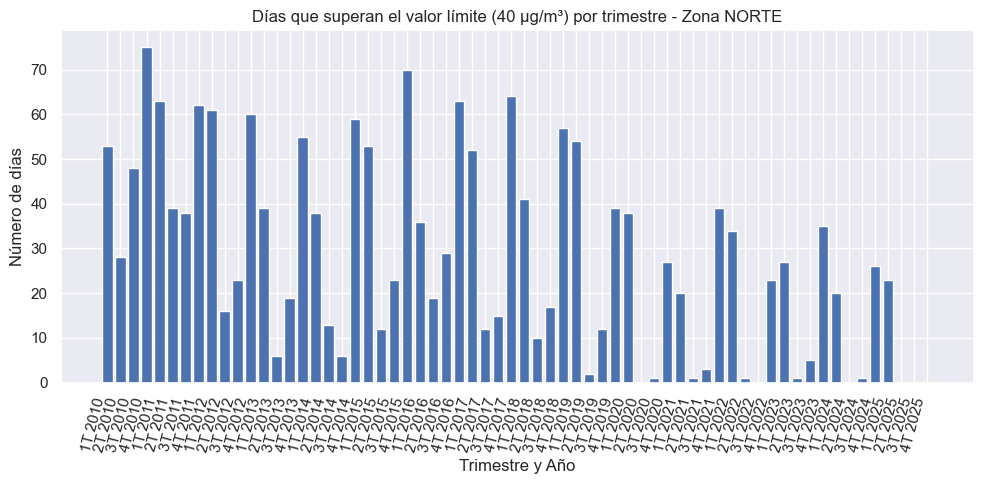

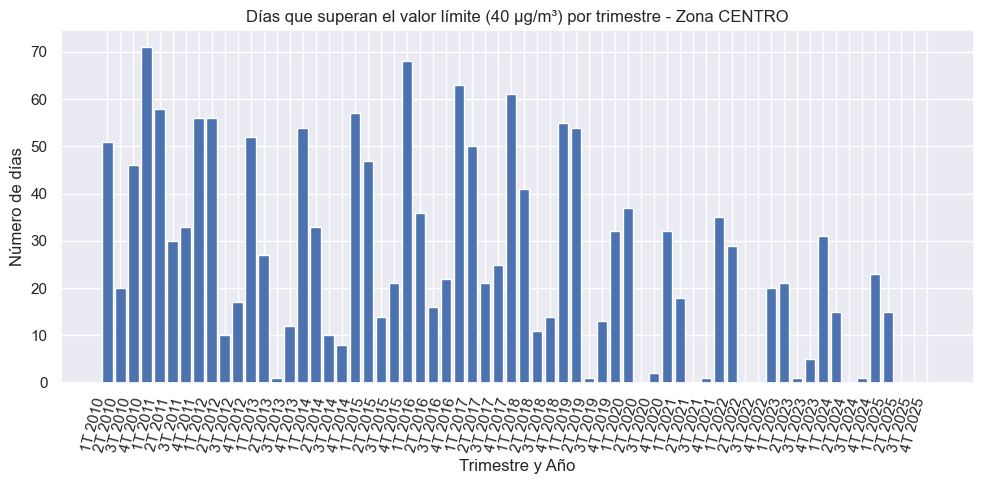

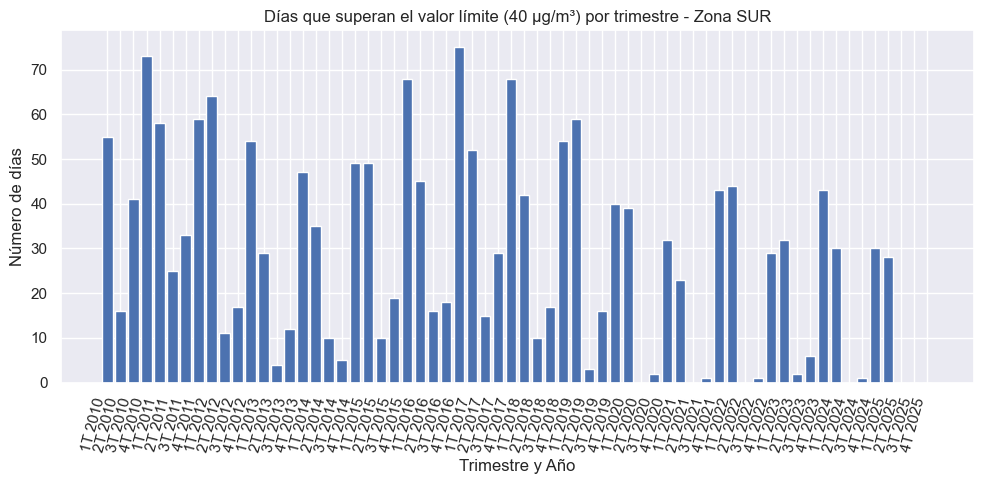

In [52]:
# --- utilidades ---
MESES_MAP = {
    1:"enero", 2:"febrero", 3:"marzo", 4:"abril",
    5:"mayo", 6:"junio", 7:"julio", 8:"agosto",
    9:"septiembre", 10:"octubre", 11:"noviembre", 12:"diciembre"
}

# --- preparar y graficar para cada zona ---
for zona, resumen_zona in [
    ("NORTE", df_VL_8_norte),
    ("CENTRO", df_VL_8_centro),
    ("SUR", df_VL_8_sur),
]:
    conteo_z_trim = preparar_conteo_trimestral(resumen_zona, vl=40)
    plot_conteo_trimestral(conteo_z_trim, zona=zona, vl=40)

Como puede observasrse: 

- A partir del 1T de 2020, se observa una reduccion considerable del número de dias que superan el valor límite de 40 µg/m³.
- Resulta curioso observar que los primeros trimestres de cada año son los que suelen superar estos valores límite. Así quedó reflejado en la EDA: Invierno alto, verano bajo

## MODELOS DE SERIES TEMPORALES

Se van a aplicar seis modelos: ARIMA, CatBoost, LightGBM, XGBoost, LSTM y CNN.

- ARIMA (univariante)
- CatBoost, LightGBM, XGBoost (machine learning - multivariantes)
- LSTM y CNN (deep learning)

Sobre las mimas muestras, se van a comparar los RMSE. Tras esta comparación, se decide cual es el modelo mejor y se lleva a cabo una prediccion has el año 2032.

Con el objeto de poder hacer buenas estimaciones de los datos mediante los modelos, pasamos los datos diarios de cada uno de los dataframes a mensuales para llevar a cabo las predicciones:

In [53]:
tabla_rmse_modelos = []
tabla_predicciones_2030 = []

In [54]:
df_8_norte.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIA/MES/ANO               5660 non-null   datetime64[ns]
 1   MAGNITUD                  5660 non-null   category      
 2   ZONA_ESTACION             5660 non-null   category      
 3   MEDICION_ugm3             5660 non-null   float64       
 4   TEMPERATURA_MAX (°C)      5660 non-null   float64       
 5   TEMPERATURA_MIN (°C)      5660 non-null   float64       
 6   TEMPERATURA_MED (°C)      5660 non-null   float64       
 7   PRECIPITACIONES (mm)      5660 non-null   float64       
 8   HUMEDAD_MAX (%)           5660 non-null   float64       
 9   HUMEDAD_MIN (%)           5660 non-null   float64       
 10  HUMEDAD_MED (%)           5660 non-null   float64       
 11  NIEVE (cm)                5660 non-null   float64       
 12  VIENTO_MAX_10 (km/h)

In [55]:
df_8_centro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIA/MES/ANO               5660 non-null   datetime64[ns]
 1   MAGNITUD                  5660 non-null   category      
 2   ZONA_ESTACION             5660 non-null   category      
 3   MEDICION_ugm3             5660 non-null   float64       
 4   TEMPERATURA_MAX (°C)      5660 non-null   float64       
 5   TEMPERATURA_MIN (°C)      5660 non-null   float64       
 6   TEMPERATURA_MED (°C)      5660 non-null   float64       
 7   PRECIPITACIONES (mm)      5660 non-null   float64       
 8   HUMEDAD_MAX (%)           5660 non-null   float64       
 9   HUMEDAD_MIN (%)           5660 non-null   float64       
 10  HUMEDAD_MED (%)           5660 non-null   float64       
 11  NIEVE (cm)                5660 non-null   float64       
 12  VIENTO_MAX_10 (km/h)

In [56]:
df_8_sur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIA/MES/ANO               5660 non-null   datetime64[ns]
 1   MAGNITUD                  5660 non-null   category      
 2   ZONA_ESTACION             5660 non-null   category      
 3   MEDICION_ugm3             5660 non-null   float64       
 4   TEMPERATURA_MAX (°C)      5660 non-null   float64       
 5   TEMPERATURA_MIN (°C)      5660 non-null   float64       
 6   TEMPERATURA_MED (°C)      5660 non-null   float64       
 7   PRECIPITACIONES (mm)      5660 non-null   float64       
 8   HUMEDAD_MAX (%)           5660 non-null   float64       
 9   HUMEDAD_MIN (%)           5660 non-null   float64       
 10  HUMEDAD_MED (%)           5660 non-null   float64       
 11  NIEVE (cm)                5660 non-null   float64       
 12  VIENTO_MAX_10 (km/h)

### MODELO ARIMA (AutoRegressive Integrated Moving Average)


ARIMA se trata de un análisis univariante de series temporales que busca predecir el valor futuro de una serie en función de:
- Sus propios valores pasados,
- La tendencia o diferencia acumulada,
- y los errores previos del modelo.

El modelo se define con tres parámetros --> ARIMA(p, d, q)

- p (Autorregresivo): Significa que el valor actual depende de **valores pasados** de la propia serie.
- d (Integrado): Indica cuántas veces se diferencian los datos para hacer la serie estacionaria, es decir, sin tendencia (no cambia con el tiempo) --> Media y varianza constantes y sin tendencias o ciclos marcados. Para comprobarlo se usan gráficos o tests (como Dickey-Fuller).
- q (Media móvil): Representa la dependencia del valor actual con los **errores pasados**.

ARIMA(p,d,q) = Diferenciar la serie d veces + aplicar un modelo AR(p) + MA(q)

**¿Cómo se estima un ARIMA?**
Generalmente se sigue este proceso:
- Visualizar la serie
→ ¿tiene tendencia o estacionalidad?
- Diferenciar si hace falta
→ hasta que sea estacionaria.
- Examinar los gráficos ACF (mide la correlación entre la serie y sus propios rezagos -lags-) y PACF (mide la correlación parcial, es decir, la relación entre el valor actual y un rezago específico eliminando el efecto de los rezagos intermedios)
→ ayudan a estimar los valores de p (PACF) y q (ACF).
- Probar varios modelos ARIMA(p,d,q)
→ comparar sus indicadores, normalmente el AIC (Akaike Information Criterion). Cuanto menor sea el AIC, mejor se ajusta el modelo con menos parámetros.
- Entrenar el modelo con los datos históricos.
- Evaluar el ajuste con datos de prueba (RMSE, MAPE, etc.).


#### 1) VISUALIZAR LA SERIE --> DETECTAR TENDENCIA/ESTACIONALIDAD

Los datos se pasan a mensuales por las siguientes razones:

**Ventajas:**
- Suaviza bastante el ruido diario.
- Se conserva la estacionalidad anual.
- Más observaciones que la trimestral (unas 180 si tengo 15 años).

**Problemas:** 
- Algo de ruido, pero razonable.



=== NORTE ===


C:\Users\rosal\AppData\Local\Temp\ipykernel_52180\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)


📁 Guardado gráfico en: 07_Figs\01_graficos_series_mensuales_MAG8\serie_mensual_NORTE.png


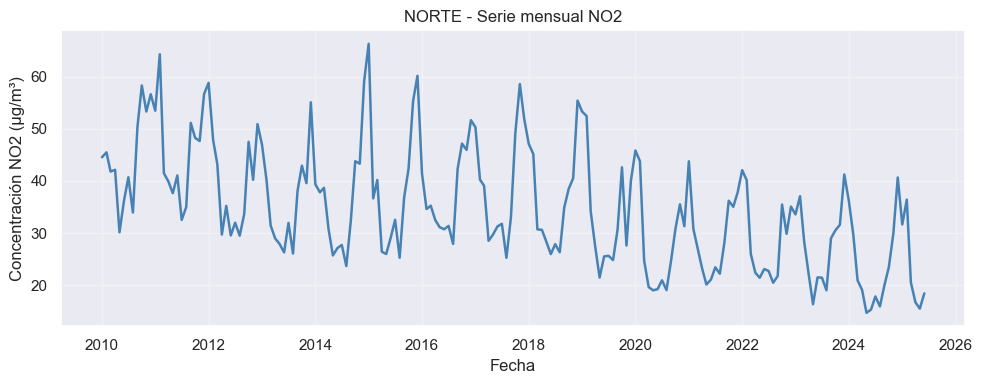


=== CENTRO ===


C:\Users\rosal\AppData\Local\Temp\ipykernel_52180\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)


📁 Guardado gráfico en: 07_Figs\01_graficos_series_mensuales_MAG8\serie_mensual_CENTRO.png


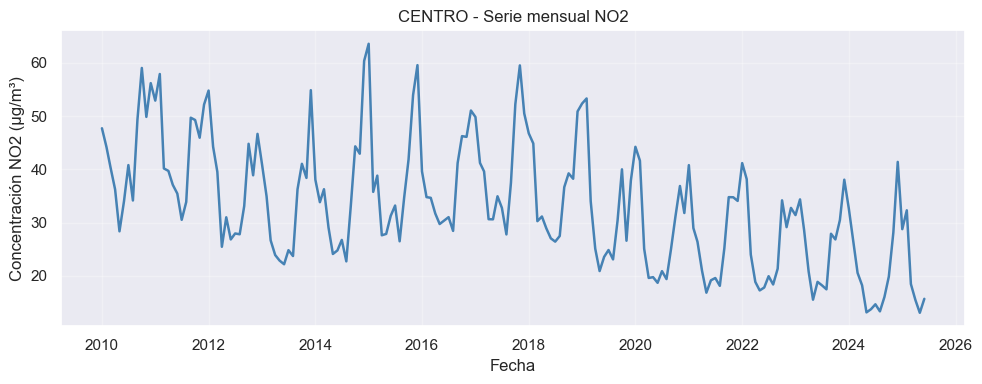


=== SUR ===


C:\Users\rosal\AppData\Local\Temp\ipykernel_52180\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)


📁 Guardado gráfico en: 07_Figs\01_graficos_series_mensuales_MAG8\serie_mensual_SUR.png


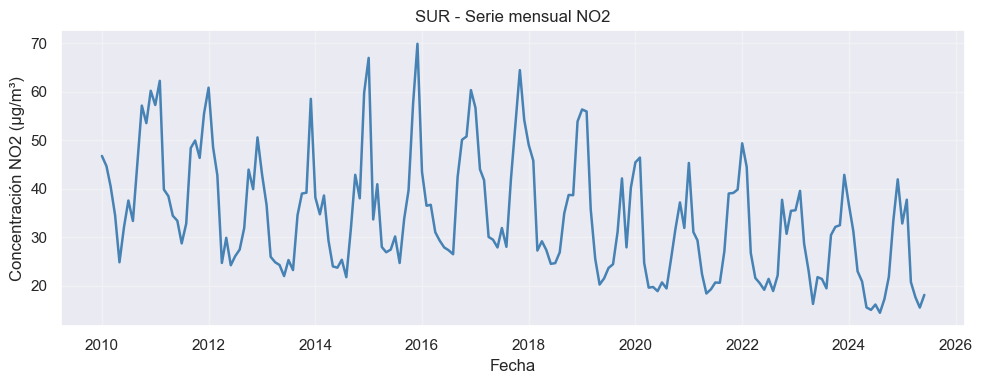

In [57]:
CARPETA_BASE = "07_Figs"
SUBCARPETA = "01_graficos_series_mensuales_MAG8"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)

# Crea la carpeta general y la subcarpeta si no existen
os.makedirs(CARPETA_SALIDA, exist_ok=True)

MAPA_MES = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4,
    "Mayo": 5, "Junio": 6, "Julio": 7, "Agosto": 8,
    "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

dfs_zonas = {
    "NORTE":  df_8_norte,
    "CENTRO": df_8_centro,
    "SUR":    df_8_sur
}

series_zonas = {}

for zona, df in dfs_zonas.items():
    print(f"\n=== {zona} ===")

    # 1. Agregación mensual
    df_mensual = agrupar_mensual(df)

    # 2. Serie temporal mensual limpia
    serie = preparar_serie_mensual(df_mensual)
    series_zonas[zona] = serie

    # 3. Definir nombre del archivo PNG
    nombre_png = os.path.join(CARPETA_SALIDA, f"serie_mensual_{zona}.png")

    # 4. Graficar y guardar sin mostrar
    plot_serie(serie, f"{zona} - Serie mensual NO2", nombre_salida=nombre_png, mostrar=True)

**TENDENCIA**

- Las tres series muestran una tendencia descendente sostenida a lo largo del periodo analizado, evidenciando una mejora general de la calidad del aire.
- El año 2020 marca un punto de inflexión con una caída abrupta de los niveles de NO₂, coincidente con las restricciones de movilidad por la pandemia.
- Tras 2021, las concentraciones se recuperan ligeramente pero no alcanzan los niveles pre-pandemia, lo que sugiere una reducción estructural y duradera de las emisiones urbanas.

**ESTACIONALIDAD**

- En todas las zonas se observa una estacionalidad anual muy marcada, con picos de concentración en invierno (noviembre–febrero) y mínimos en verano (junio–agosto). Esto refleja el impacto del tráfico, la calefacción y las condiciones meteorológicas menos dispersivas del invierno.
- La forma y frecuencia del ciclo estacional se mantienen constantes durante todo el periodo 2010–2025, lo que indica que el patrón es estructural y predecible.
- La amplitud estacional varía entre zonas: el SUR presenta oscilaciones más amplias (hasta 30 µg/m³), mientras que el CENTRO y NORTE son más estables (15–20 µg/m³).
  

#### 2) DIFERENCIAR (d) HASTA SERIE ESTACIONARIA

Para cada zona (NORTE, CENTRO, SUR):
- Aplicar el test de Dickey–Fuller aumentado (ADF) sobre la serie original.
- Si no es estacionaria (p > 0.05), diferenciar una vez y volver a comprobar.
- Repetir hasta alcanzar estacionariedad o un máximo de 2 diferencias. Más de 2, podría introducir ruido y generar sobreajuste.
- Guardar los gráficos: 1) Serie original, 2) Serie diferenciada (una o dos veces)

In [58]:
# -------------------------------------------------
# Configuración de carpetas
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "02_diferenciacion_ARIMA_MAG8"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# -------------------------------------------------
# Bucle principal por zona
# -------------------------------------------------
resultados_d = []

for zona, serie in series_zonas.items():
    print(f"\n=== {zona} ===")

    carpeta_zona = os.path.join(CARPETA_SALIDA, zona)
    os.makedirs(carpeta_zona, exist_ok=True)

    # Paso 1: test ADF en serie original
    p0 = test_adf(serie, f"{zona} original")
    plot_serie_diferenciada(serie, f"{zona} - Serie original", os.path.join(carpeta_zona, "serie_original.png"))

    d_opt = 0 # Inicializo iteración
    serie_dif = serie.copy()

    # Paso 2: diferenciar si no estacionaria
    while p0 > 0.05 and d_opt < 2:
        d_opt += 1 # Aumento en +1 la iteración
        serie_dif = diferencia_serie(serie, d=d_opt)
        p0 = test_adf(serie_dif, f"{zona} Δ{d_opt}")
        plot_serie_diferenciada(serie_dif, f"{zona} - Serie diferenciada Δ{d_opt}", 
                                os.path.join(carpeta_zona, f"serie_diferenciada_d{d_opt}.png"))

    # Guardar resultado
    estacionaria = "Sí" if p0 <= 0.05 else "No"
    resultados_d.append({
        "Zona": zona,
        "d_optimo": d_opt,
        "p_final": round(p0, 4),
        "Estacionaria": estacionaria
    })

# -------------------------------------------------
# Resumen final
# -------------------------------------------------
df_est = pd.DataFrame(resultados_d)
print("\n>>> RESULTADOS DIFERENCIACIÓN <<<")
print(df_est.to_string(index=False))


=== NORTE ===
ADF NORTE original: estadístico=-1.369, p-valor=0.5970
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG8\NORTE\serie_original.png
ADF NORTE Δ1: estadístico=-13.066, p-valor=0.0000
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG8\NORTE\serie_diferenciada_d1.png

=== CENTRO ===
ADF CENTRO original: estadístico=-1.406, p-valor=0.5794
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG8\CENTRO\serie_original.png
ADF CENTRO Δ1: estadístico=-4.032, p-valor=0.0013
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG8\CENTRO\serie_diferenciada_d1.png

=== SUR ===
ADF SUR original: estadístico=-1.547, p-valor=0.5100
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG8\SUR\serie_original.png
ADF SUR Δ1: estadístico=-12.379, p-valor=0.0000
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG8\SUR\serie_diferenciada_d1.png

>>> RESULTADOS DIFERENCIACIÓN <<<
  Zona  d_optimo  p_final Estacionaria
 NORTE         1   0.0000           Sí
CENTRO         1   0

Con lo cual se concluye que para las tres zonas solo hace falta una diferenciación.

#### 3) EVALUAR GRÁFICOS ACF y PACF → AYUDAN A ELEGIR p y q

In [59]:
# -------------------------------------------------
# Config carpeta salida para esta fase
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "03_acf_pacf_ARIMA_MAG8"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# -------------------------------------------------
# Calculo zona por zona
# -------------------------------------------------
resumen_modelado = []

# Pasamos resultados_d (lista de dicts) a dict indexado por zona para acceso rápido
d_por_zona = {fila["Zona"]: fila["d_optimo"] for fila in resultados_d}

for zona, serie_original in series_zonas.items():
    print(f"\n=== {zona} ===")

    # 1) d óptimo encontrado en la fase anterior
    d_opt = d_por_zona[zona]

    # 2) construyo la serie estacionaria aplicando esa d
    serie_estacionaria = aplicar_diferenciacion(serie_original, d_opt)

    # 3) guardo ACF y PACF en disco
    guardar_acf_pacf(serie_estacionaria, zona, CARPETA_SALIDA, lags=49) # lag = 49 (equivalente a 4 años)

    # 4) registro info útil para elegir p y q
    resumen_modelado.append({
        "Zona": zona,
        "d": d_opt,
        "n_obs_estacionaria": len(serie_estacionaria)
    })

# 5) resumen en dataframe
df_resumen_modelado = pd.DataFrame(resumen_modelado)
print("\n>>> RESUMEN PARA ESTIMACIÓN ARIMA <<<")
print(df_resumen_modelado.to_string(index=False))


=== NORTE ===
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG8\NORTE\acf.png
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG8\NORTE\pacf.png

=== CENTRO ===
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG8\CENTRO\acf.png
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG8\CENTRO\pacf.png

=== SUR ===
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG8\SUR\acf.png
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG8\SUR\pacf.png

>>> RESUMEN PARA ESTIMACIÓN ARIMA <<<
  Zona  d  n_obs_estacionaria
 NORTE  1                 185
CENTRO  1                 185
   SUR  1                 185


<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

**INTERPRETACIÓN**

*NORTE*
- ACF: corta tras lag 1.
- PACF: sin picos → MA(1) claro.
- Candidatos: ARIMA(0,1,1); alternativa ARIMA(1,1,1) (comparar AIC).

*CENTRO*
- Lectura: ACF y PACF se apagan rápido; casi ruido blanco.
- Candidatos: ARIMA(0,1,1) y ARIMA(1,1,0).

*SUR*
- Lectura: pico claro en lag 1 en ACF y PACF → AR(1).
- Candidatos: ARIMA(1,1,0), ARIMA(1,1,1), ARIMA(0,1,1).

#### 4) COMPARAR ARIMAS CON AIC

In [60]:
# -------------------------------------------------
# Definición de candidatos por zona
# -------------------------------------------------
candidatos_por_zona = {
    "NORTE":  [(0,1,1), (1,1,1)],
    "CENTRO": [(0,1,1), (1,1,0)],
    "SUR":    [(1,1,0), (1,1,1), (0,1,1)]
}


# -------------------------------------------------
# Bucle principal
# -------------------------------------------------
resultados_finales = []

for zona, serie in series_zonas.items():
    print(f"\n======================")
    print(f"ZONA {zona}")
    print(f"======================")

    # 1️⃣ División temporal
    train, test = train_test_split_temporal(serie, fecha_corte='2024-06-30')

    if len(test) == 0:
        print("No hay datos de test tras la fecha de corte. Se omite evaluación.")
        continue

    # 2️⃣ Evaluación de modelos candidatos
    mejor_aic = np.inf
    mejor_order = None
    mejor_ajuste = None

    for order in candidatos_por_zona[zona]:
        print(f"\nProbando ARIMA{order}...")
        aic_val, ajuste = ajustar_y_aic(train, order)

        if np.isfinite(aic_val):
            print(f"   AIC = {aic_val:.2f}")
        else:
            print("   Modelo no válido")

        if aic_val < mejor_aic:
            mejor_aic = aic_val
            mejor_order = order
            mejor_ajuste = ajuste

    # 3️⃣ Predicción en test con el mejor modelo
    if mejor_ajuste is not None:
        pred_test = mejor_ajuste.forecast(steps=len(test))
        rmse_test = evaluar_modelo(f"ARIMA{mejor_order} ({zona})", test, pred_test)
    else:
        rmse_test = np.nan

    # 4️⃣ Guardar resultados
    resultados_finales.append({
        "Zona": zona,
        "Mejor_(p,d,q)": mejor_order,
        "AIC": round(mejor_aic, 2),
        "RMSE_test": round(rmse_test, 3),
        "n_train": len(train),
        "n_test": len(test)
    })

    # Guardar info de desempeño del mejor ARIMA por zona
    tabla_rmse_modelos.append({
        "modelo": "ARIMA",
        "zona": zona,
        "order": mejor_order,
        "seasonal_order": None,
        "AIC": mejor_aic,
        "RMSE_test": rmse_test
    })


# -------------------------------------------------
# 5️⃣ Tabla resumen final
# -------------------------------------------------
df_resultados_arima = pd.DataFrame(resultados_finales)
print("\n>>> RESULTADOS ARIMA (Selección por AIC y validación en test) <<<")
print(df_resultados_arima.to_string(index=False))




ZONA NORTE

Probando ARIMA(0, 1, 1)...
   AIC = 1205.93

Probando ARIMA(1, 1, 1)...
   AIC = 1207.85


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

ARIMA(0, 1, 1) (NORTE) → RMSE: 11.929

ZONA CENTRO

Probando ARIMA(0, 1, 1)...
   AIC = 1187.18

Probando ARIMA(1, 1, 0)...
   AIC = 1187.19
ARIMA(0, 1, 1) (CENTRO) → RMSE: 11.596

ZONA SUR

Probando ARIMA(1, 1, 0)...
   AIC = 1243.45

Probando ARIMA(1, 1, 1)...


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

   AIC = 1245.43

Probando ARIMA(0, 1, 1)...
   AIC = 1243.45
ARIMA(1, 1, 0) (SUR) → RMSE: 12.907

>>> RESULTADOS ARIMA (Selección por AIC y validación en test) <<<
  Zona Mejor_(p,d,q)     AIC  RMSE_test  n_train  n_test
 NORTE     (0, 1, 1) 1205.93     11.929      174      12
CENTRO     (0, 1, 1) 1187.18     11.596      174      12
   SUR     (1, 1, 0) 1243.45     12.907      174      12


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\

**MODELOS ELEGIDOS**

- NORTE: ARIMA (0, 1, 1)
- CENTRO: ARIMA (0, 1, 1)
- SUR: ARIMA (1, 1, 0)


#### 5) ENTRENAR MODELO FINAL Y GENERAR PREDICCIONES

In [61]:
# -------------------------------------------------
# Configuración de carpetas de salida
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "04_predicciones_finales_ARIMA_MAG8"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)


=== ZONA NORTE ===
ARIMA(0, 1, 1) (NORTE) → RMSE: 11.929


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


📁 Guardado gráfico: 07_Figs\04_predicciones_finales_ARIMA_MAG8\predicciones_NORTE.png


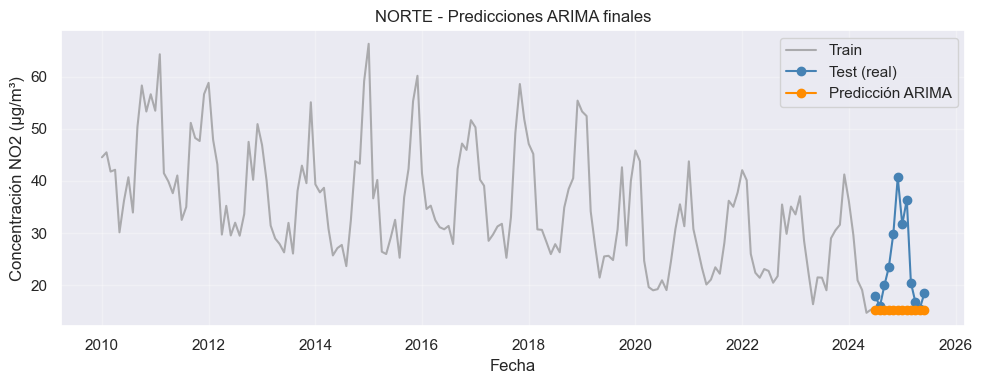


=== ZONA CENTRO ===
ARIMA(0, 1, 1) (CENTRO) → RMSE: 11.596


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


📁 Guardado gráfico: 07_Figs\04_predicciones_finales_ARIMA_MAG8\predicciones_CENTRO.png


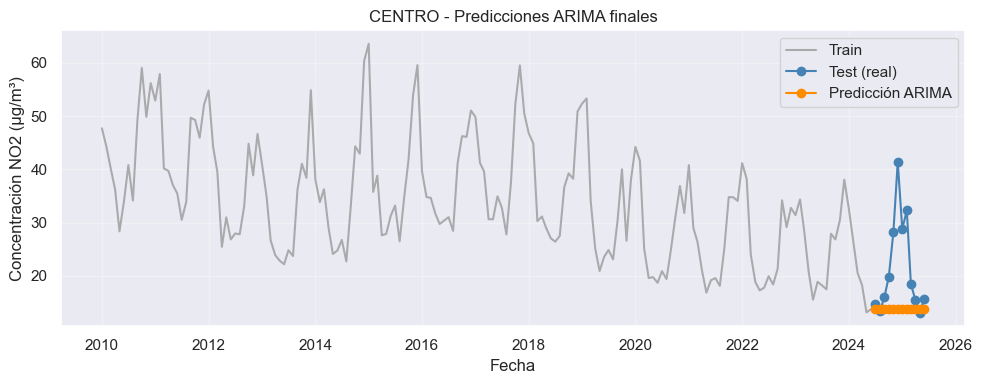


=== ZONA SUR ===
ARIMA(1, 1, 0) (SUR) → RMSE: 12.907


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


📁 Guardado gráfico: 07_Figs\04_predicciones_finales_ARIMA_MAG8\predicciones_SUR.png


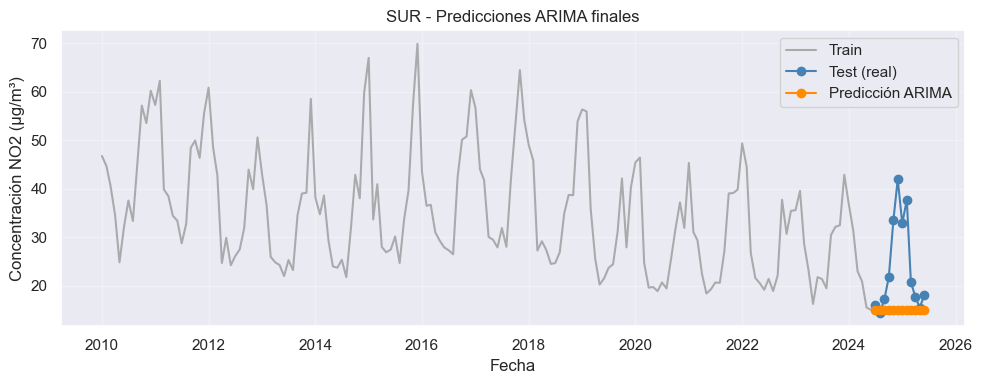


>>> RESULTADOS FINALES ARIMA <<<
  Zona ARIMA_(p,d,q)     AIC  RMSE_test  n_train  n_test
 NORTE     (0, 1, 1) 1205.93     11.929      174      12
CENTRO     (0, 1, 1) 1187.18     11.596      174      12
   SUR     (1, 1, 0) 1243.45     12.907      174      12


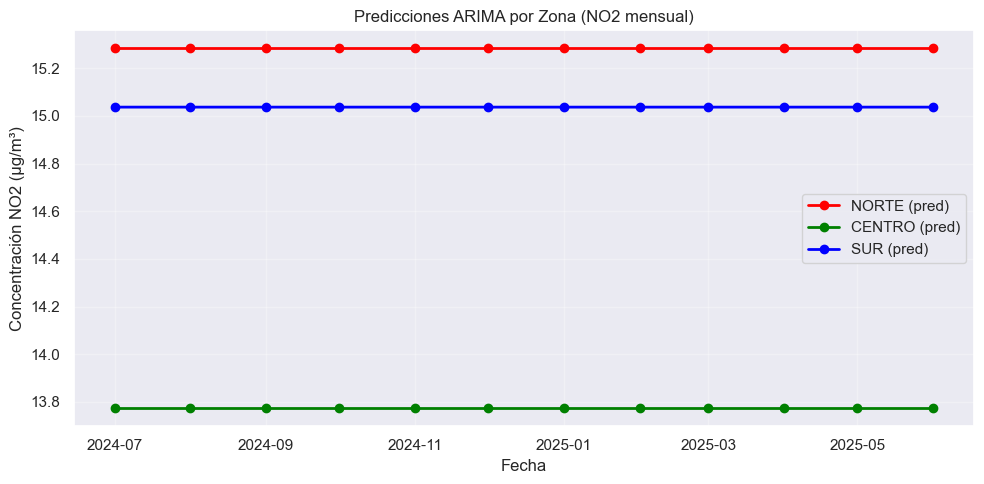


📁 Guardado gráfico combinado: 07_Figs\04_predicciones_finales_ARIMA_MAG8\predicciones_conjuntas_zonas.png


In [62]:
# -------------------------------------------------
# MODELOS FINALES (según selección previa)
# -------------------------------------------------
modelos_finales = {
    "NORTE":  (0,1,1),
    "CENTRO": (0,1,1),
    "SUR":    (1,1,0)
}

# -------------------------------------------------
# ENTRENAMIENTO Y PREDICCIONES POR ZONA
# -------------------------------------------------
resultados_pred = []
predicciones_zonas = {}

for zona, serie in series_zonas.items():
    print(f"\n=== ZONA {zona} ===")

    order = modelos_finales[zona]
    train, test = train_test_split_temporal(serie, fecha_corte="2024-06-30")

    # Entrenamiento del modelo
    modelo = ARIMA(train, order=order)
    ajuste = modelo.fit()

    # Predicción sobre el conjunto de test
    pred_test = ajuste.forecast(steps=len(test))

    # Evaluación (usando tu función)
    rmse_test = evaluar_modelo(f"ARIMA{order} ({zona})", test, pred_test)
    aic_modelo = ajuste.aic

    # Guardar y mostrar gráfico individual
    nombre_png = os.path.join(CARPETA_SALIDA, f"predicciones_{zona}.png")
    plot_predicciones(zona, train, test, pred_test, nombre_png, mostrar=True)

    # Guardar dataframe de predicciones
    predicciones_zonas[zona] = pd.DataFrame({
        "real": test.values,
        "pred": pred_test.values
    }, index=test.index)

    # Registrar resultados
    resultados_pred.append({
        "Zona": zona,
        "ARIMA_(p,d,q)": order,
        "AIC": round(aic_modelo, 2),
        "RMSE_test": round(rmse_test, 3),
        "n_train": len(train),
        "n_test": len(test)
    })

# -------------------------------------------------
# TABLA RESUMEN FINAL
# -------------------------------------------------
df_pred = pd.DataFrame(resultados_pred)
print("\n>>> RESULTADOS FINALES ARIMA <<<")
print(df_pred.to_string(index=False))

# -------------------------------------------------
# GRÁFICO CONJUNTO: PREDICCIONES DE LAS 3 ZONAS
# -------------------------------------------------
plt.figure(figsize=(10,5))

colores = {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}

for zona, df_pred in predicciones_zonas.items():
    plt.plot(df_pred.index, df_pred["pred"], marker="o", linewidth=2,
             color=colores.get(zona, None), label=f"{zona} (pred)")

plt.title("Predicciones ARIMA por Zona (NO2 mensual)")
plt.xlabel("Fecha")
plt.ylabel("Concentración NO2 (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

ruta_figura = os.path.join(CARPETA_SALIDA, "predicciones_conjuntas_zonas.png")
plt.savefig(ruta_figura, dpi=150)
plt.show()
plt.close()

print(f"\n📁 Guardado gráfico combinado: {ruta_figura}")

#### 6) PREDICCIÓN HASTA DICIEMBRE 2030 Y 2032


=== ZONA NORTE ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


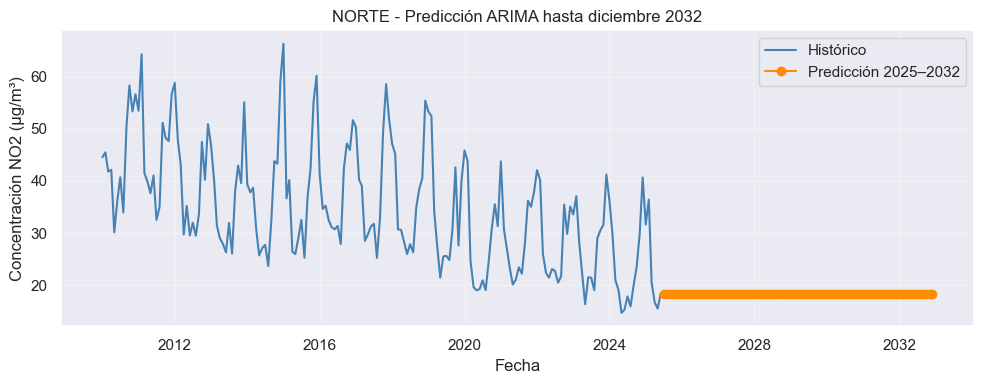

📁 Guardado gráfico: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG8\prediccion_2032_NORTE.png

=== ZONA CENTRO ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


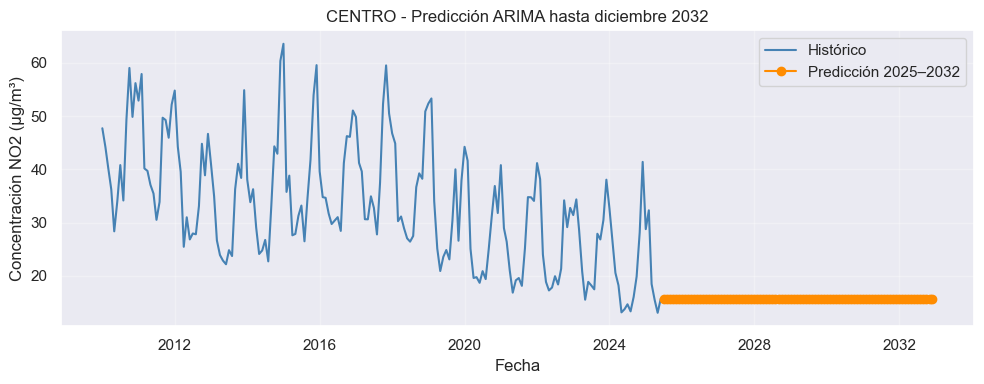

📁 Guardado gráfico: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG8\prediccion_2032_CENTRO.png

=== ZONA SUR ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


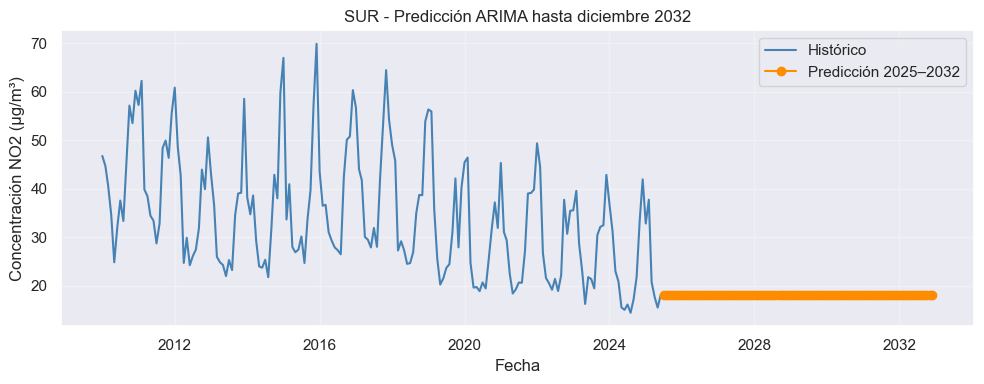

📁 Guardado gráfico: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG8\prediccion_2032_SUR.png


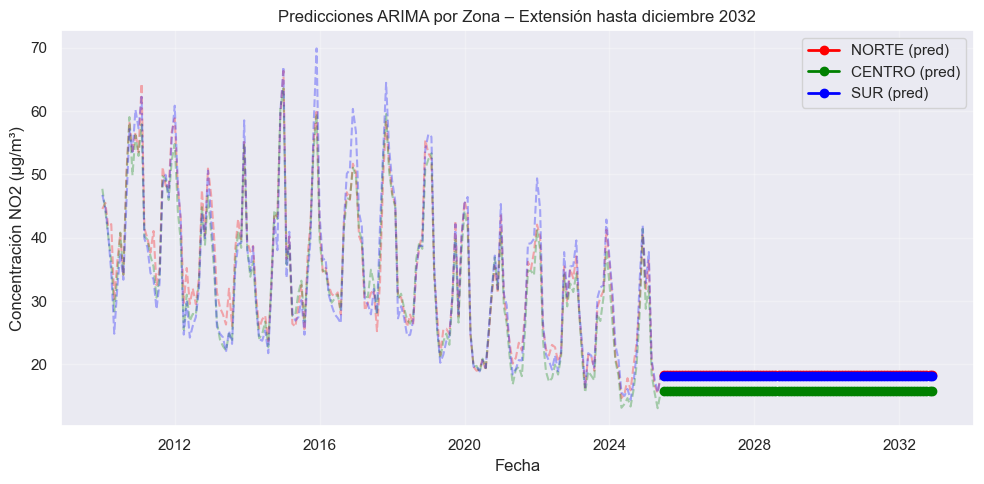


📁 Guardado gráfico combinado: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG8\predicciones_conjuntas_2032.png

📁 Guardado CSV con predicciones completas: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG8\predicciones_NO2_hasta_2032.csv

>>> ÚLTIMAS PREDICCIONES (diciembre 2032) <<<
 NO2_pred_NORTE  NO2_pred_CENTRO  NO2_pred_SUR
         18.265           15.739        18.136

>>> PREDICCIONES ANUALES (enero–diciembre 2030) <<<
            NO2_pred_NORTE  NO2_pred_CENTRO  NO2_pred_SUR
2030-01-01          18.265           15.739        18.136
2030-02-01          18.265           15.739        18.136
2030-03-01          18.265           15.739        18.136
2030-04-01          18.265           15.739        18.136
2030-05-01          18.265           15.739        18.136
2030-06-01          18.265           15.739        18.136
2030-07-01          18.265           15.739        18.136
2030-08-01          18.265           15.739        18.136
2030-09-01          18.265           15.739        

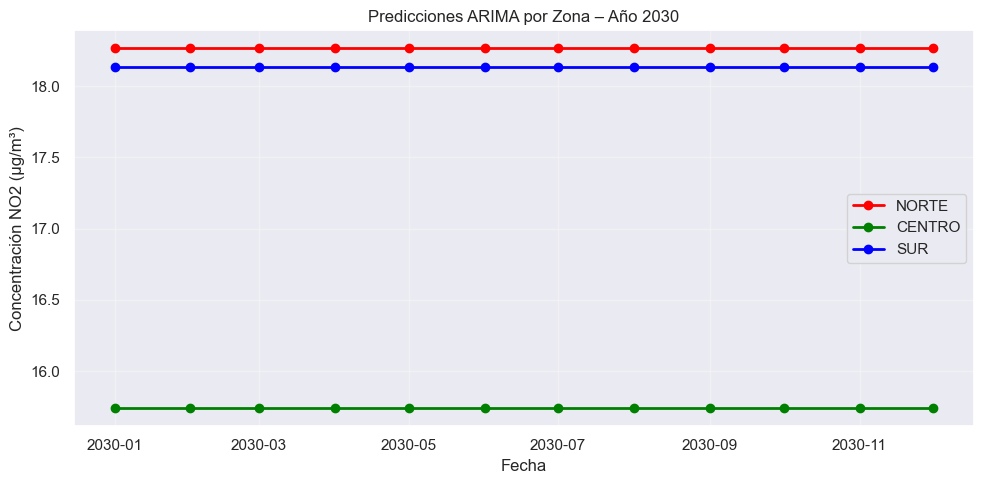


📁 Guardado gráfico 2030: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG8\predicciones_conjuntas_2030.png


In [63]:
# -------------------------------------------------
# Configuración de carpeta de salida
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "05_predicciones_largo_plazo_ARIMA_MAG8"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# -------------------------------------------------
# Modelos finales por zona (ya validados)
# -------------------------------------------------
modelos_finales = {
    "NORTE":  (0,1,1),
    "CENTRO": (0,1,1),
    "SUR":    (1,1,0)
}

# -------------------------------------------------
# Horizonte de predicción
# -------------------------------------------------
fecha_final_pred = "2032-12-31"

# -------------------------------------------------
# Bucle de predicción por zona
# -------------------------------------------------
predicciones_largo_plazo = {}

for zona, serie in series_zonas.items():
    print(f"\n=== ZONA {zona} ===")

    order = modelos_finales[zona]

    # Entrenamiento con toda la serie disponible
    modelo = ARIMA(serie, order=order)
    ajuste = modelo.fit()

    # Número de meses a predecir
    ultimo_mes = serie.index.max()
    horizonte = pd.date_range(start=ultimo_mes + pd.offsets.MonthBegin(1),
                              end=fecha_final_pred, freq="MS")
    n_steps = len(horizonte)

    # Predicción a largo plazo
    pred = ajuste.forecast(steps=n_steps)
    pred.index = horizonte

    # Guardamos los resultados
    predicciones_largo_plazo[zona] = pred

    # -------------------------------------------------
    # Gráfico por zona
    # -------------------------------------------------
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, label="Histórico", color="steelblue")
    plt.plot(pred.index, pred.values, label="Predicción 2025–2032", color="darkorange", marker="o")
    plt.title(f"{zona} - Predicción ARIMA hasta diciembre 2032")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración NO2 (µg/m³)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    ruta_png = os.path.join(CARPETA_SALIDA, f"prediccion_2032_{zona}.png")
    plt.savefig(ruta_png, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico: {ruta_png}")

# -------------------------------------------------
# Gráfico combinado (todas las zonas)
# -------------------------------------------------
plt.figure(figsize=(10,5))
colores = {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}

for zona, pred in predicciones_largo_plazo.items():
    plt.plot(pred.index, pred.values, color=colores[zona], linewidth=2, marker="o", label=f"{zona} (pred)")
    plt.plot(series_zonas[zona].index, series_zonas[zona].values, color=colores[zona], alpha=0.3, linestyle="--")

plt.title("Predicciones ARIMA por Zona – Extensión hasta diciembre 2032")
plt.xlabel("Fecha")
plt.ylabel("Concentración NO2 (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

ruta_figura = os.path.join(CARPETA_SALIDA, "predicciones_conjuntas_2032.png")
plt.savefig(ruta_figura, dpi=150)
plt.show()
plt.close()

print(f"\n📁 Guardado gráfico combinado: {ruta_figura}")

# -------------------------------------------------
# Tabla resumen de predicciones finales
# -------------------------------------------------
df_pred_2032 = pd.concat(predicciones_largo_plazo, axis=1)
df_pred_2032.columns = [f"NO2_pred_{zona}" for zona in df_pred_2032.columns]

# Guardar CSV con todas las predicciones
csv_path = os.path.join(CARPETA_SALIDA, "predicciones_NO2_hasta_2032.csv")
df_pred_2032.to_csv(csv_path)
print(f"\n📁 Guardado CSV con predicciones completas: {csv_path}")

print("\n>>> ÚLTIMAS PREDICCIONES (diciembre 2032) <<<")
print(df_pred_2032.tail(1).round(3).to_string(index=False))

# -------------------------------------------------
# PREDICCIONES DEL AÑO 2030
# -------------------------------------------------
# Filtrar las filas correspondientes a 2030
df_pred_2030 = df_pred_2032[df_pred_2032.index.year == 2030]

print("\n>>> PREDICCIONES ANUALES (enero–diciembre 2030) <<<")
print(df_pred_2030.round(3).to_string())

# Guardar CSV con predicciones 2030
csv_2030_path = os.path.join(CARPETA_SALIDA, "predicciones_NO2_2030.csv")
df_pred_2030.to_csv(csv_2030_path)
print(f"\n📁 Guardado CSV con predicciones de 2030: {csv_2030_path}")

# -------------------------------------------------
# Promedio anual de 2030 por zona
# -------------------------------------------------
promedios_2030 = df_pred_2030.mean().round(3)
print("\n>>> PROMEDIO ANUAL PREVISTO PARA 2030 (µg/m³) <<<")
print(promedios_2030)

# Volcado de predicciones ARIMA 2030 en tabla global
for zona in ["NORTE", "CENTRO", "SUR"]:
    # Para cada zona tenemos la serie mensual 2030: df_pred_2030[f"NO2_pred_{zona}"]
    serie_zona_2030 = df_pred_2030[f"NO2_pred_{zona}"]

    for fecha, valor_predicho in serie_zona_2030.items():
        tabla_predicciones_2030.append({
            "modelo": "ARIMA",
            "zona": zona,
            "fecha": fecha,                   # índice tipo Timestamp
            "anio": fecha.year,               # 2030
            "mes": fecha.month,               # 1..12
            "pred_2030": valor_predicho,      # µg/m³
            "promedio_anual_2030": promedios_2030[f"NO2_pred_{zona}"]
        })

# -------------------------------------------------
# Gráfico conjunto de las tres zonas – año 2030
# -------------------------------------------------
plt.figure(figsize=(10,5))
for zona, color in {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}.items():
    plt.plot(df_pred_2030.index, df_pred_2030[f"NO2_pred_{zona}"], marker="o",
             linewidth=2, color=color, label=zona)

plt.title("Predicciones ARIMA por Zona – Año 2030")
plt.xlabel("Fecha")
plt.ylabel("Concentración NO2 (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

ruta_figura_2030 = os.path.join(CARPETA_SALIDA, "predicciones_conjuntas_2030.png")
plt.savefig(ruta_figura_2030, dpi=150)
plt.show()
plt.close()

print(f"\n📁 Guardado gráfico 2030: {ruta_figura_2030}")

#### 7) RESUMEN METODOLÓGICO

1.	Se representa la serie temporal de concentración de partículas y se inspecciona visualmente la presencia de tendencia y patrones repetitivos (estacionalidad).
2.	Se aplica diferenciación sucesiva y se contrasta con el test ADF hasta obtener una serie estacionaria. Ese número de diferenciaciones se toma como el parámetro d del modelo ARIMA(p,d,q).
3.	Sobre la serie estacionaria se analizan las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF). Los cortes significativos en PACF sugieren candidatos para p, y en ACF para q.
4.	Con esos candidatos se ajustan distintos modelos ARIMA(p,d,q) sobre el conjunto de entrenamiento y se selecciona el modelo con menor AIC, ya que el AIC penaliza la complejidad del modelo y favorece especificaciones parsimoniosas.
5.	El modelo ARIMA seleccionado se entrena con los datos históricos (train) y se utiliza para predecir el tramo de prueba (test).
6.	El rendimiento predictivo se evalúa con métricas fuera de muestra como RMSE.
7.  En base a los modelos óptimos obtenidos, se extraen los gráficos de predicción hasta 2030 y 2032.

#### 8) CONCLUSION

Los gráficos de predicción a largo plazo son planos, sin apenas estacionalidad ni tendencia visible a partir de 2025. Esto es un síntoma clásico de que los modelos ARIMA que elegimos están sobreajustados al ruido a corto plazo o que la diferenciación eliminó completamente la estructura temporal.

Es, por ello, por lo que vamos a analizar modelos SARIMA que permite oscilaciones en el horizonte largo.

### MODELO SARIMA (Seasonal ARIMA)

El modelo SARIMA (Seasonal AutoRegressive Integrated Moving Average) es una extensión del modelo ARIMA diseñada específicamente para manejar datos de series temporales que presentan patrones estacionales. Su notación completa es:

*SARIMA(p,d,q)(P,D,Q,s)*

- 𝑝, 𝑑, 𝑞 --> Componentes no estacionales. Permite captar tendencias a corto plazo.
- P, D, Q --> componentes estacionales. Permite captar patrones estacionales.
- s --> Periodicidad de la estacionalidad (12 para datos mensuales).

Para la parte estacional (P, D, Q) tomaré siguientes valores para las tres zonas y observaré si existe o no mejoras sobre el ARIMA:

- “D = 1”: diferenciación anual: Ya que la serie tiene un patrón repetitivo anual. Diferenciar a lag=12 elimina la componente estacional fija y deja solo la variabilidad interanual. Estacionalidad mensual fuerte.
- “P = 0”: Los PACF estacionales (lags 12, 24...) no muestran cortes bruscos ni picos sobresalientes. Esto implica que no hay un AR estacional fuerte, o en todo caso es débi
- “Q = 1”: El patrón observado en las ACF decae de forma suave y oscilante.

De modo que:



=== ZONA NORTE ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


NORTE (test) → RMSE: 3.674


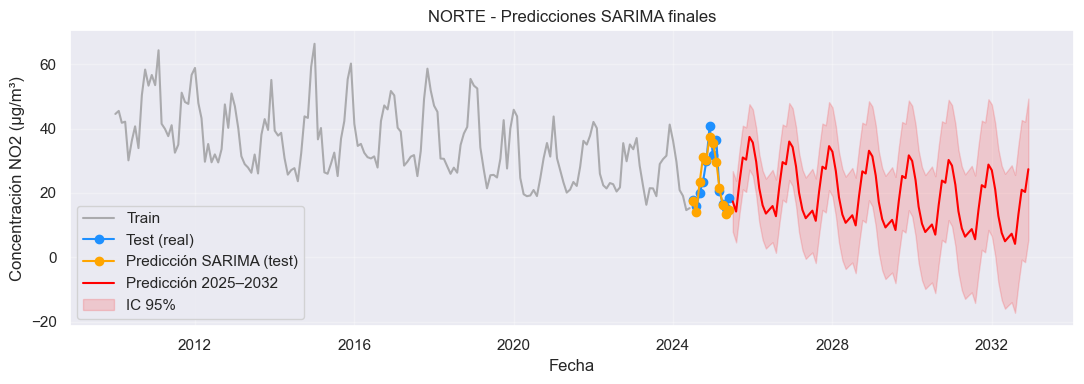

📁 Guardado gráfico: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG8\SARIMA_predicciones_NORTE.png

=== ZONA CENTRO ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


CENTRO (test) → RMSE: 4.405


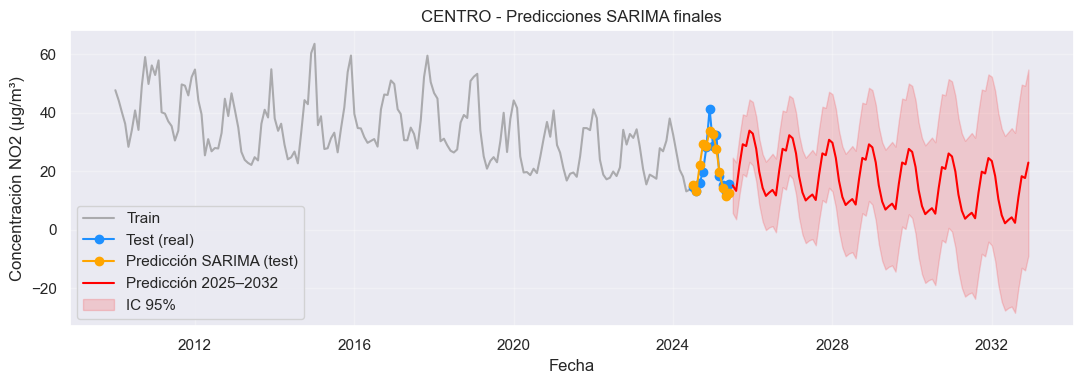

📁 Guardado gráfico: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG8\SARIMA_predicciones_CENTRO.png

=== ZONA SUR ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SUR (test) → RMSE: 4.624


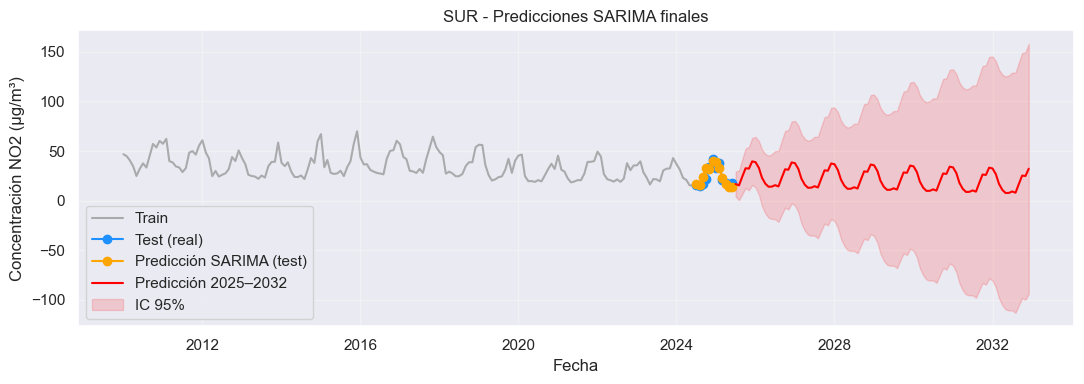

📁 Guardado gráfico: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG8\SARIMA_predicciones_SUR.png

📁 Guardado CSV: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG8\SARIMA_predicciones_NO2_hasta_2032.csv

>>> PREDICCIÓN DICIEMBRE 2032 (SARIMA) <<<
 NO2_pred_NORTE  NO2_pred_CENTRO  NO2_pred_SUR
         27.391            22.99        32.168

📁 Guardado CSV 2030: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG8\SARIMA_predicciones_NO2_2030.csv

>>> PROMEDIOS ANUALES 2030 (SARIMA) <<<
NO2_pred_NORTE     17.325
NO2_pred_CENTRO    14.787
NO2_pred_SUR       20.357
dtype: float64


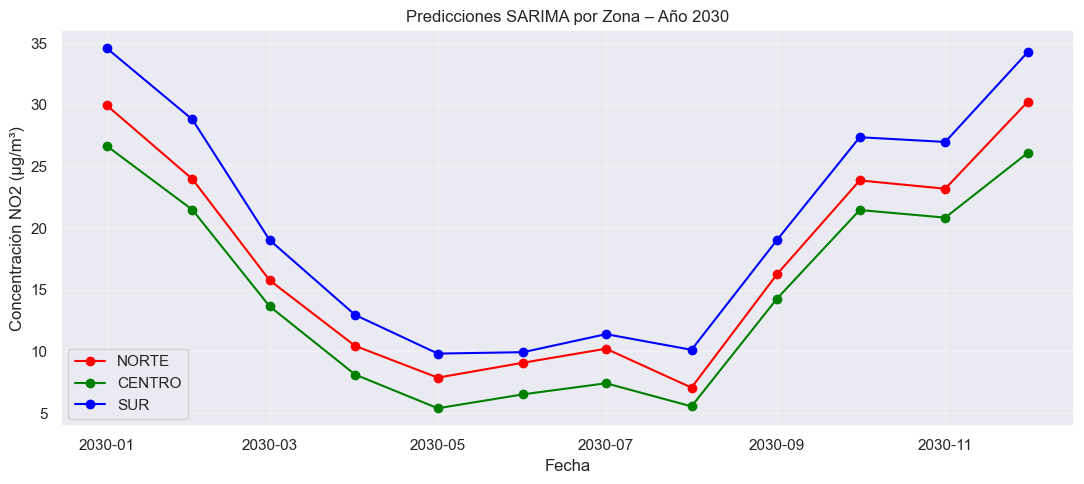

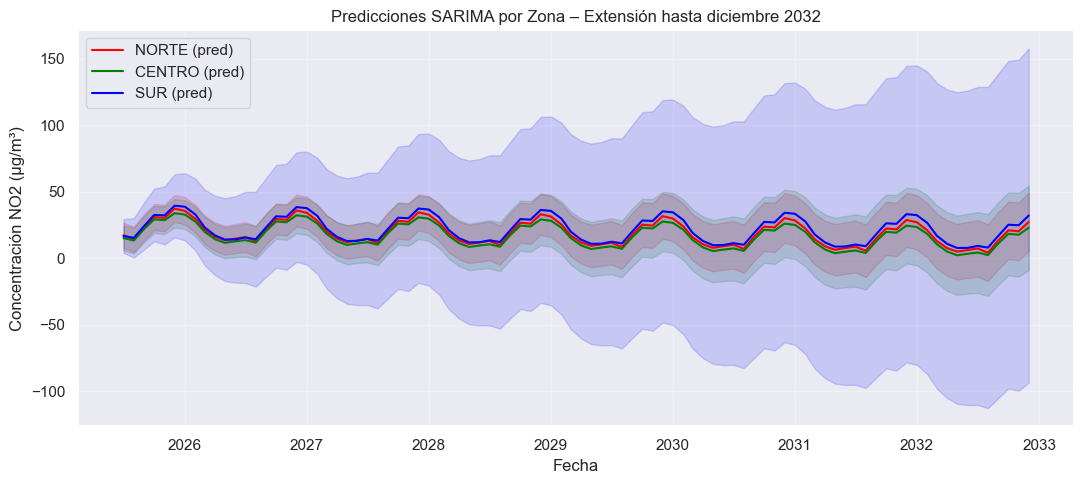


>>> RESUMEN MODELOS SARIMA (AIC y RMSE) <<<
  Zona     order seasonal_order    AIC  RMSE_test  n_obs  RMSE_test_ARIMA
 NORTE (0, 1, 1)  (0, 1, 1, 12) 898.10      3.674    186           11.929
CENTRO (0, 1, 1)  (0, 1, 1, 12) 895.70      4.405    186           11.596
   SUR (1, 1, 0)  (0, 1, 1, 12) 987.48      4.624    186           12.907


In [64]:

# =================================================
# 1. CONFIGURACIÓN DE CARPETAS
# =================================================
CARPETA_BASE = "07_Figs"
SUBCARPETA = "06_predicciones_largo_plazo_SARIMA_MAG8"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# ==========================================================
# 3️⃣ Definir modelos SARIMA por zona
# ==========================================================
modelos_sarima = {
    "NORTE":  {"order": (0,1,1), "seasonal_order": (0,1,1,12)},
    "CENTRO": {"order": (0,1,1), "seasonal_order": (0,1,1,12)},
    "SUR":    {"order": (1,1,0), "seasonal_order": (0,1,1,12)}
}

# ==========================================================
# 4️⃣ Horizonte de predicción
# ==========================================================
fecha_final_pred = "2032-12-31"
fecha_corte = "2024-06-30"  # corte temporal para evaluar RMSE

# ==========================================================
# 5️⃣ Bucle por zona: entrenar, evaluar, predecir largo plazo
# ==========================================================
predicciones_largo_plazo = {}
resultados_info = []

for zona, serie in series_zonas.items():
    print(f"\n=== ZONA {zona} ===")

    # Dividir train/test
    train = serie.loc[:fecha_corte]
    test = serie.loc[fecha_corte:]

    order = modelos_sarima[zona]["order"]
    seasonal_order = modelos_sarima[zona]["seasonal_order"]

    # --------------------------
    # Ajustar SARIMA
    # --------------------------
    modelo = SARIMAX(
        train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    ajuste = modelo.fit(disp=False)

    # --------------------------
    # Predicción sobre test
    # --------------------------
    pred_test = ajuste.get_forecast(steps=len(test))
    pred_mean = pred_test.predicted_mean
    rmse = evaluar_modelo(f"{zona} (test)", test, pred_mean)

    # Guardar RMSE SARIMA por zona
  # Guardar RMSE SARIMA por zona
    tabla_rmse_modelos.append({
        "modelo": "SARIMA",
        "zona": zona,
        "order": order,
        "seasonal_order": seasonal_order,
        "AIC": round(ajuste.aic, 2),
        "RMSE_test": rmse
    })

    # --------------------------
    # Predicción a largo plazo (2025–2032)
    # --------------------------
    ultimo_mes = serie.index.max()
    horizonte = pd.date_range(
        start=ultimo_mes + pd.offsets.MonthBegin(1),
        end=fecha_final_pred,
        freq="MS"
    )
    n_steps = len(horizonte)
    forecast_res = ajuste.get_forecast(steps=n_steps)

    pred_media = forecast_res.predicted_mean
    ic = forecast_res.conf_int(alpha=0.05)
    pred_media.index = horizonte
    ic.index = horizonte
    ic.columns = ["ic_inf", "ic_sup"]

    # Guardar resultados
    df_pred = pd.DataFrame({
        "pred": pred_media,
        "ic_inf": ic["ic_inf"],
        "ic_sup": ic["ic_sup"]
    })
    predicciones_largo_plazo[zona] = df_pred

    # --------------------------
    # Información de modelo
    # --------------------------
    resultados_info.append({
        "Zona": zona,
        "order": order,
        "seasonal_order": seasonal_order,
        "AIC": round(ajuste.aic, 2),
        "RMSE_test": round(rmse, 3),
        "n_obs": len(serie)
    })

    # --------------------------
    # Gráfico por zona
    # --------------------------
    plt.figure(figsize=(11,4))
    plt.plot(train.index, train.values, color="gray", alpha=0.6, label="Train")
    plt.plot(test.index, test.values, color="dodgerblue", marker="o", label="Test (real)")
    plt.plot(pred_mean.index, pred_mean.values, color="orange", marker="o", label="Predicción SARIMA (test)")

    plt.plot(df_pred.index, df_pred["pred"], color="red", linewidth=1.5, label="Predicción 2025–2032")
    plt.fill_between(df_pred.index, df_pred["ic_inf"], df_pred["ic_sup"], color="red", alpha=0.15, label="IC 95%")

    plt.title(f"{zona} - Predicciones SARIMA finales")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración NO2 (µg/m³)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    ruta_png = os.path.join(CARPETA_SALIDA, f"SARIMA_predicciones_{zona}.png")
    plt.savefig(ruta_png, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico: {ruta_png}")

# ==========================================================
# 6️⃣ Resumen de predicciones largo plazo
# ==========================================================
df_pred_all = pd.concat(
    {zona: predicciones_largo_plazo[zona]["pred"] for zona in predicciones_largo_plazo},
    axis=1
)
df_pred_all.columns = [f"NO2_pred_{zona}" for zona in df_pred_all.columns]

# Guardar CSV
csv_todo = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_NO2_hasta_2032.csv")
df_pred_all.to_csv(csv_todo)
print(f"\n📁 Guardado CSV: {csv_todo}")

# Última fila (dic 2032)
print("\n>>> PREDICCIÓN DICIEMBRE 2032 (SARIMA) <<<")
print(df_pred_all.tail(1).round(3).to_string(index=False))

# ==========================================================
# 7️⃣ Predicciones 2030 + Promedio anual
# ==========================================================
df_pred_2030 = df_pred_all[df_pred_all.index.year == 2030]
promedios_2030 = df_pred_2030.mean().round(3)

# Volcado de predicciones SARIMA 2030 en tabla global
for zona in ["NORTE", "CENTRO", "SUR"]:
    serie_zona_2030 = df_pred_2030[f"NO2_pred_{zona}"]

    for fecha, valor_predicho in serie_zona_2030.items():
        tabla_predicciones_2030.append({
            "modelo": "SARIMA",
            "zona": zona,
            "fecha": fecha,
            "anio": fecha.year,
            "mes": fecha.month,
            "pred_2030": valor_predicho,
            "promedio_anual_2030": promedios_2030[f"NO2_pred_{zona}"]
        })

csv_2030 = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_NO2_2030.csv")
df_pred_2030.to_csv(csv_2030)
print(f"\n📁 Guardado CSV 2030: {csv_2030}")

print("\n>>> PROMEDIOS ANUALES 2030 (SARIMA) <<<")
print(promedios_2030)

# ==========================================================
# 8️⃣ Gráfico conjunto 2030
# ==========================================================
plt.figure(figsize=(11,5))
colores = {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}

for zona, color in colores.items():
    plt.plot(df_pred_2030.index, df_pred_2030[f"NO2_pred_{zona}"], color=color, marker="o", label=zona)

plt.title("Predicciones SARIMA por Zona – Año 2030")
plt.xlabel("Fecha")
plt.ylabel("Concentración NO2 (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

ruta_fig_2030 = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_conjuntas_2030.png")
plt.savefig(ruta_fig_2030, dpi=150)
plt.show()

# ==========================================================
# 9️⃣ Gráfico conjunto 2032 (predicciones largas)
# ==========================================================
plt.figure(figsize=(11,5))
for zona, color in colores.items():
    df_z = predicciones_largo_plazo[zona]
    plt.plot(df_z.index, df_z["pred"], color=color, label=f"{zona} (pred)")
    plt.fill_between(df_z.index, df_z["ic_inf"], df_z["ic_sup"], color=color, alpha=0.15)

plt.title("Predicciones SARIMA por Zona – Extensión hasta diciembre 2032")
plt.xlabel("Fecha")
plt.ylabel("Concentración NO2 (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

ruta_fig_2032 = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_conjuntas_2032.png")
plt.savefig(ruta_fig_2032, dpi=150)
plt.show()

# ==========================================================
# 🔟 Tabla resumen modelos (AIC, RMSE, etc.)
# ==========================================================

df_info = pd.DataFrame(resultados_info)
df_info ["RMSE_test_ARIMA"]=df_resultados_arima ["RMSE_test"]
print("\n>>> RESUMEN MODELOS SARIMA (AIC y RMSE) <<<")
print(df_info.to_string(index=False))

**CONCLUSIÓN:** Se comprueba que la predicción SARIMA mejora a la ARIMA, ya que el RMSE_test es más bajo

### MODELOS MACHINE LEARNING (CASTBOOST, LightGBM y XGBOOST)

Los modelos aplicados anteriormente (ARIMA/SARIMA) son modelos clásicos que aprenden la dinámica temporal interna de la serie directamente (usa rezagos, diferencias, estacionalidad). Sin embargo, en estos modelos no hemos considerado ninguna otra variable exógena, hemos hecho el análisis univariante sin más.

Los modelos de Machine Learning como CatBoost, LightGBM y XGBoost se basan en el algoritmo de Gradient Boosting y se caracterizan por lo siguiente:

- Son modelos supervisados de regresión tabular. Es decir: Son modelos que aprende a predecir una variable numérica continua a partir de datos estructurados en forma de tabla, usando un conjunto de datos donde ya se conoce el valor objetivo y contra lo que compararemos una vez el modelo haya porcedido a la predicción.
- Se debe construir el dataset: cada fila = un mes, con variables explicativas, y objetivo.
- No entienden por sí mismos la secuencia temporal. Se las tenemos que dar tú mediante: 1) lags (valores anteriores), 2) medias móviles, 3) mes del año, 4) tendencia temporal, 5) variables exógenas

**DIFERENCIAS ENTRE CASTBOOST, LightGBM y XGBOOST**

- *CatBoost*: Ideal cuando tienes muchas variables categóricas. Evita el preprocesamiento manual y es muy estable con pocos datos.
- *LightGBM*: Perfecto para grandes volúmenes de datos. Usa una estrategia de crecimiento por hojas (leaf-wise) que acelera el entrenamiento y mejora la precisión, aunque puede sobreajustar si no se regula.
- *XGBoost*: El más veterano y versátil. Rendimiento sólido y facilidad de ajuste.


#### 1) DEFINIR OBJETIVO

En este apartado sólo vamos a definir la parte de los datos que luego vamos a predecir.

In [65]:
objetivos_por_zona = {}

for zona, serie in series_zonas.items():
    # Aseguramos nombre claro
    serie_objetivo = serie.copy()
    serie_objetivo.name = "NO2_objetivo"

    # Aseguramos que el índice sea DatetimeIndex mensual ordenado
    serie_objetivo = serie_objetivo.sort_index()
    if not isinstance(serie_objetivo.index, pd.DatetimeIndex):
        raise ValueError(f"La serie de {zona} no tiene un DatetimeIndex. Revisa preparar_serie_mensual().")

    # Guardamos para futuros pasos
    objetivos_por_zona[zona] = serie_objetivo

    # Mostramos un pequeño resumen para inspección
    print(f"\n=== {zona} ===")
    print("Primeras filas:")
    print(serie_objetivo.head())
    print("Últimas filas:")
    print(serie_objetivo.tail())
    print(f"Rango temporal: {serie_objetivo.index.min().date()} -> {serie_objetivo.index.max().date()}")
    print(f"Nº de observaciones mensuales: {len(serie_objetivo)}")



=== NORTE ===
Primeras filas:
fecha
2010-01-01    44.548387
2010-02-01    45.495536
2010-03-01    41.805108
2010-04-01    42.145370
2010-05-01    30.141577
Name: NO2_objetivo, dtype: float64
Últimas filas:
fecha
2025-02-01    36.414683
2025-03-01    20.496416
2025-04-01    16.700614
2025-05-01    15.483871
2025-06-01    18.414815
Name: NO2_objetivo, dtype: float64
Rango temporal: 2010-01-01 -> 2025-06-01
Nº de observaciones mensuales: 186

=== CENTRO ===
Primeras filas:
fecha
2010-01-01    47.725806
2010-02-01    44.205357
2010-03-01    40.338710
2010-04-01    36.255556
2010-05-01    28.376344
Name: NO2_objetivo, dtype: float64
Últimas filas:
fecha
2025-02-01    32.321429
2025-03-01    18.481183
2025-04-01    15.477232
2025-05-01    13.080645
2025-06-01    15.705556
Name: NO2_objetivo, dtype: float64
Rango temporal: 2010-01-01 -> 2025-06-01
Nº de observaciones mensuales: 186

=== SUR ===
Primeras filas:
fecha
2010-01-01    46.763441
2010-02-01    44.666667
2010-03-01    40.564516
2010

#### 2) CONSTRUCCIÓN DATASETS ENTRENAMIENTO/TEST/VALIDACIÓN

In [66]:
# ================================================================
# 0️⃣ Definición de variables relevantes (ya identificadas)
# ================================================================
variables_interes = [
    "ZONA_ESTACION","VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)", "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)", "dow", "month", "VIENTO_DIR_10 (°)", "TEMPERATURA_MIN (°C)"
]

# ================================================================
# 1️⃣ Filtrar cada dataframe por las variables de interés + objetivo + fecha
# ================================================================
dfs_filtrados = {}

for zona, df in {
    "NORTE":  df_8_norte,
    "CENTRO": df_8_centro,
    "SUR":    df_8_sur
}.items():
    
    # Asegurar que todas las variables existen en el DataFrame original
    columnas_presentes = [col for col in variables_interes if col in df.columns]
    
    # ⚠️ Añadimos explícitamente la columna de fecha y la de objetivo
    columnas_finales = ["DIA/MES/ANO"] + columnas_presentes + ["MEDICION_ugm3"]
    
    # Selección
    df_sel = df[columnas_finales].copy()
    dfs_filtrados[zona] = df_sel

    print(f"✅ {zona}: seleccionadas {len(columnas_finales)} columnas ({len(df_sel)} filas)")

# ================================================================
# 2️⃣ Agregar mensualmente y preparar las series
# ================================================================
series_zonas_filtradas = {}
df_mensuales = {}

for zona, df_sel in dfs_filtrados.items():
    # Convertir a mensual (ya tienes definida la función agrupar_mensual)
    df_mensual = agrupar_mensual(df_sel)
    df_mensuales[zona] = df_mensual

    # Crear la serie objetivo mensual (NO2)
    serie = preparar_serie_mensual(df_mensual)
    series_zonas_filtradas[zona] = serie

    print(f"📆 {zona}: serie mensual con {len(serie)} observaciones")

✅ NORTE: seleccionadas 16 columnas (5660 filas)
✅ CENTRO: seleccionadas 16 columnas (5660 filas)
✅ SUR: seleccionadas 16 columnas (5660 filas)
📆 NORTE: serie mensual con 186 observaciones
📆 CENTRO: serie mensual con 186 observaciones
📆 SUR: serie mensual con 186 observaciones


C:\Users\rosal\AppData\Local\Temp\ipykernel_52180\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)
C:\Users\rosal\AppData\Local\Temp\ipykernel_52180\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)
C:\Users\rosal\AppData\Local\Temp\ipykernel_52180\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warn

In [67]:
display (df_mensuales["NORTE"].head())

year month  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
0  2010     1             14.340400              4.180482   
1  2010     2             16.358562              5.767762   
2  2010     3             15.296000              4.599551   
3  2010     4             11.323457              3.393302   
4  2010     5             14.734358              3.921244   

   VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  \
0              8.994496              23.647792               8.178825   
1             10.475022              26.963421              10.449815   
2              9.952272              24.037271               8.410951   
3              7.213985              18.764531               5.250311   
4              9.211280              22.873719               7.084341   

   VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  PRESION_MIN (hPa)  \
0              15.876356        1019.874194        1013.000000   
1              17.915136        1013.339286        1005.057143   
2              16.551365        1020.603226        1014.854839   
3              11.648427        1019.313333        1013.803333   
4              14.889930        1017.370968        1012.616129   

   PRESION_MED (hPa)  VIENTO_DIR_10 (°)  TEMPERATURA_MIN (°C)  MEDICION_ugm3  
0        1016.239386         189.496251              2.246803      44.548387  
1        1009.038979         177.580082              2.360006      45.495536  
2        1017.773782         181.653800              3.834867      41.805108  
3        1016.500822         157.378782              7.813911      42.145370  
4        1014.977818         216.816734              9.214868      30.141577

In [68]:
# Definimos qué columnas exógenas queremos usar como features
columnas_exogenas_para_ML = [
    "VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)", "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)", "VIENTO_DIR_10 (°)", "TEMPERATURA_MIN (°C)"
]

Xtr_zona = {}
ytr_zona = {}
Xte_zona = {}
yte_zona = {}
df_ml_zona = {}

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== Preparando datos ML para {zona} ===")
    df_mensual_zona = df_mensuales[zona]

    X_train, y_train, X_test, y_test, df_ml = preparar_datos_ml(
        df_mensual_zona,
        fecha_corte="2024-06-30",
        lags=[1,2,3,12],
        usar_columnas_exogenas=columnas_exogenas_para_ML
    )

    Xtr_zona[zona] = X_train
    ytr_zona[zona] = y_train
    Xte_zona[zona] = X_test
    yte_zona[zona] = y_test
    df_ml_zona[zona] = df_ml

    display(df_ml.head(20))  # inspección rápida



=== Preparando datos ML para NORTE ===
📆 Corte temporal 2024-06-30: train=162 / test=12


year month  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
fecha                                                                
2011-01-01  2011     1             11.133066              3.969929   
2011-02-01  2011     2             13.692290              3.374900   
2011-03-01  2011     3             13.031612              4.250460   
2011-04-01  2011     4             12.121629              3.398806   
2011-05-01  2011     5             11.904144              2.547154   
2011-06-01  2011     6             13.668835              2.934388   
2011-07-01  2011     7             16.228153              3.015240   
2011-08-01  2011     8             14.652795              3.211927   
2011-09-01  2011     9             10.941236              3.064029   
2011-10-01  2011    10             11.915389              3.259683   
2011-11-01  2011    11             12.091936              3.453237   
2011-12-01  2011    12             10.701396              3.142993   
2012-01-01  2012     1             10.193656              2.649624   
2012-02-01  2012     2             15.113797              4.909637   
2012-03-01  2012     3             12.506749              3.307004   
2012-04-01  2012     4             17.821108              4.394116   
2012-05-01  2012     5             14.565000              3.695039   
2012-06-01  2012     6             16.280549              3.895128   
2012-07-01  2012     7             15.447602              2.965511   
2012-08-01  2012     8             16.183556              3.235271   

            VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
fecha                                                     
2011-01-01              7.675189              19.518586   
2011-02-01              8.190680              21.721436   
2011-03-01              8.604767              21.138403   
2011-04-01              7.550697              20.787128   
2011-05-01              7.245116              19.845443   
2011-06-01              7.888057              21.818357   
2011-07-01              9.264900              25.171246   
2011-08-01              8.508629              22.824008   
2011-09-01              6.819389              18.710810   
2011-10-01              7.528552              22.099152   
2011-11-01              7.616184              20.695121   
2011-12-01              6.725808              19.097476   
2012-01-01              6.319294              17.795046   
2012-02-01              9.464780              24.568927   
2012-03-01              7.823773              20.805441   
2012-04-01             10.850734              25.993544   
2012-05-01              8.923540              22.577838   
2012-06-01              9.882693              24.445965   
2012-07-01              8.675536              24.278549   
2012-08-01              9.036796              23.203044   

            VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
fecha                                                                         
2011-01-01               7.561990              13.237334        1022.603226   
2011-02-01               6.262976              13.790073        1024.100000   
2011-03-01               8.087428              14.700080        1021.538710   
2011-04-01               5.542075              12.481270        1017.890000   
2011-05-01               4.017814              11.604026        1019.612903   
2011-06-01               3.968837              12.333384        1018.056667   
2011-07-01               4.210139              14.565564        1015.719355   
2011-08-01               4.904170              13.625305        1016.441935   
2011-09-01               4.108790              10.982111        1019.550000   
2011-10-01               5.587396              13.014403        1022.061290   
2011-11-01               6.200002              13.360873        1020.373333   
2011-12-01               5.278366              11.239071        1030.235484   
2012-01-01               3.942162              10.720718        10


=== Preparando datos ML para CENTRO ===
📆 Corte temporal 2024-06-30: train=162 / test=12


year month  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
fecha                                                                
2011-01-01  2011     1             11.133066              3.969929   
2011-02-01  2011     2             13.692290              3.374900   
2011-03-01  2011     3             13.031612              4.250460   
2011-04-01  2011     4             12.121629              3.398806   
2011-05-01  2011     5             11.904144              2.547154   
2011-06-01  2011     6             13.668835              2.934388   
2011-07-01  2011     7             16.228153              3.015240   
2011-08-01  2011     8             14.652795              3.211927   
2011-09-01  2011     9             10.941236              3.064029   
2011-10-01  2011    10             11.915389              3.259683   
2011-11-01  2011    11             12.091936              3.453237   
2011-12-01  2011    12             10.701396              3.142993   
2012-01-01  2012     1             10.193656              2.649624   
2012-02-01  2012     2             15.113797              4.909637   
2012-03-01  2012     3             12.506749              3.307004   
2012-04-01  2012     4             17.821108              4.394116   
2012-05-01  2012     5             14.565000              3.695039   
2012-06-01  2012     6             16.280549              3.895128   
2012-07-01  2012     7             15.447602              2.965511   
2012-08-01  2012     8             16.183556              3.235271   

            VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
fecha                                                     
2011-01-01              7.675189              19.518586   
2011-02-01              8.190680              21.721436   
2011-03-01              8.604767              21.138403   
2011-04-01              7.550697              20.787128   
2011-05-01              7.245116              19.845443   
2011-06-01              7.888057              21.818357   
2011-07-01              9.264900              25.171246   
2011-08-01              8.508629              22.824008   
2011-09-01              6.819389              18.710810   
2011-10-01              7.528552              22.099152   
2011-11-01              7.616184              20.695121   
2011-12-01              6.725808              19.097476   
2012-01-01              6.319294              17.795046   
2012-02-01              9.464780              24.568927   
2012-03-01              7.823773              20.805441   
2012-04-01             10.850734              25.993544   
2012-05-01              8.923540              22.577838   
2012-06-01              9.882693              24.445965   
2012-07-01              8.675536              24.278549   
2012-08-01              9.036796              23.203044   

            VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
fecha                                                                         
2011-01-01               7.561990              13.237334        1022.603226   
2011-02-01               6.262976              13.790073        1024.100000   
2011-03-01               8.087428              14.700080        1021.538710   
2011-04-01               5.542075              12.481270        1017.890000   
2011-05-01               4.017814              11.604026        1019.612903   
2011-06-01               3.968837              12.333384        1018.056667   
2011-07-01               4.210139              14.565564        1015.719355   
2011-08-01               4.904170              13.625305        1016.441935   
2011-09-01               4.108790              10.982111        1019.550000   
2011-10-01               5.587396              13.014403        1022.061290   
2011-11-01               6.200002              13.360873        1020.373333   
2011-12-01               5.278366              11.239071        1030.235484   
2012-01-01               3.942162              10.720718        10


=== Preparando datos ML para SUR ===
📆 Corte temporal 2024-06-30: train=162 / test=12


year month  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
fecha                                                                
2011-01-01  2011     1             11.133066              3.969929   
2011-02-01  2011     2             13.692290              3.374900   
2011-03-01  2011     3             13.031612              4.250460   
2011-04-01  2011     4             12.121629              3.398806   
2011-05-01  2011     5             11.904144              2.547154   
2011-06-01  2011     6             13.668835              2.934388   
2011-07-01  2011     7             16.228153              3.015240   
2011-08-01  2011     8             14.652795              3.211927   
2011-09-01  2011     9             10.941236              3.064029   
2011-10-01  2011    10             11.915389              3.259683   
2011-11-01  2011    11             12.091936              3.453237   
2011-12-01  2011    12             10.701396              3.142993   
2012-01-01  2012     1             10.193656              2.649624   
2012-02-01  2012     2             15.113797              4.909637   
2012-03-01  2012     3             12.506749              3.307004   
2012-04-01  2012     4             17.821108              4.394116   
2012-05-01  2012     5             14.565000              3.695039   
2012-06-01  2012     6             16.280549              3.895128   
2012-07-01  2012     7             15.447602              2.965511   
2012-08-01  2012     8             16.183556              3.235271   

            VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  \
fecha                                                     
2011-01-01              7.675189              19.518586   
2011-02-01              8.190680              21.721436   
2011-03-01              8.604767              21.138403   
2011-04-01              7.550697              20.787128   
2011-05-01              7.245116              19.845443   
2011-06-01              7.888057              21.818357   
2011-07-01              9.264900              25.171246   
2011-08-01              8.508629              22.824008   
2011-09-01              6.819389              18.710810   
2011-10-01              7.528552              22.099152   
2011-11-01              7.616184              20.695121   
2011-12-01              6.725808              19.097476   
2012-01-01              6.319294              17.795046   
2012-02-01              9.464780              24.568927   
2012-03-01              7.823773              20.805441   
2012-04-01             10.850734              25.993544   
2012-05-01              8.923540              22.577838   
2012-06-01              9.882693              24.445965   
2012-07-01              8.675536              24.278549   
2012-08-01              9.036796              23.203044   

            VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  \
fecha                                                                         
2011-01-01               7.561990              13.237334        1022.603226   
2011-02-01               6.262976              13.790073        1024.100000   
2011-03-01               8.087428              14.700080        1021.538710   
2011-04-01               5.542075              12.481270        1017.890000   
2011-05-01               4.017814              11.604026        1019.612903   
2011-06-01               3.968837              12.333384        1018.056667   
2011-07-01               4.210139              14.565564        1015.719355   
2011-08-01               4.904170              13.625305        1016.441935   
2011-09-01               4.108790              10.982111        1019.550000   
2011-10-01               5.587396              13.014403        1022.061290   
2011-11-01               6.200002              13.360873        1020.373333   
2011-12-01               5.278366              11.239071        1030.235484   
2012-01-01               3.942162              10.720718        10

#### 3) ENTRENAMIENTO MODELOS


=== ZONA NORTE ===
Entrenando modelo CatBoost ...
NORTE - CatBoost → RMSE: 2.837


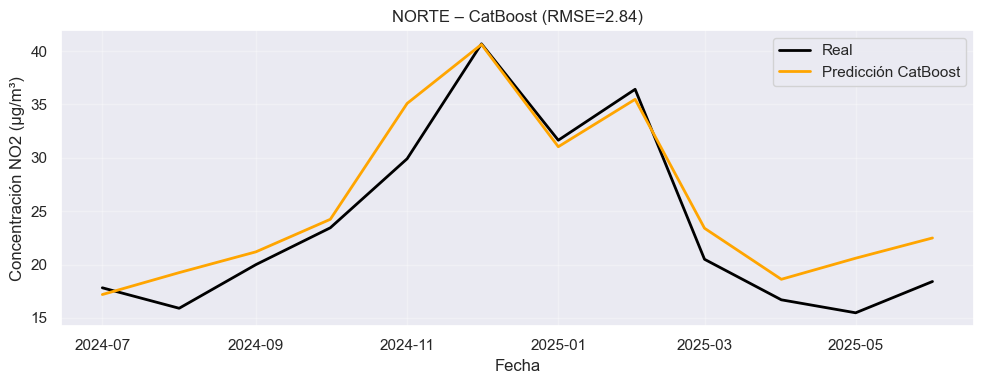

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG8\NORTE_CatBoost_predicciones_test.png
Entrenando modelo LightGBM ...
NORTE - LightGBM → RMSE: 3.877


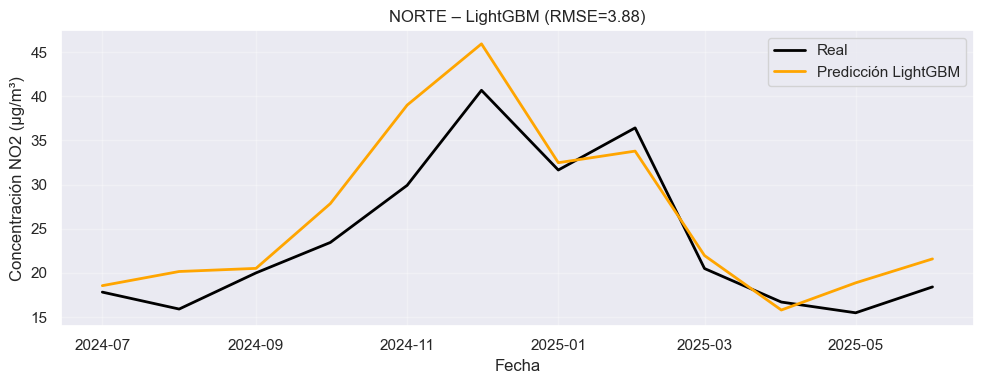

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG8\NORTE_LightGBM_predicciones_test.png
Entrenando modelo XGBoost ...
NORTE - XGBoost → RMSE: 2.237


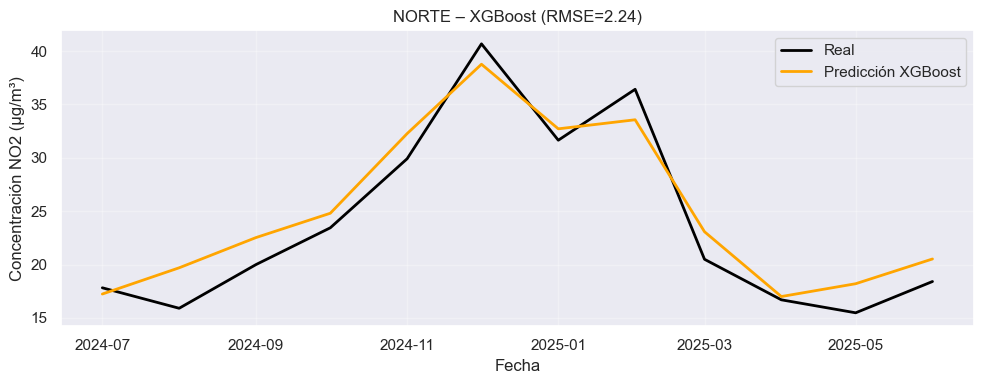

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG8\NORTE_XGBoost_predicciones_test.png

=== ZONA CENTRO ===
Entrenando modelo CatBoost ...
CENTRO - CatBoost → RMSE: 3.370


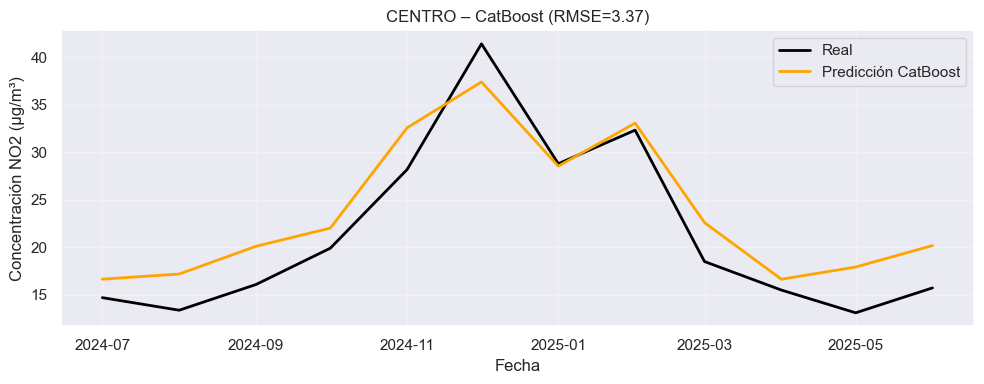

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG8\CENTRO_CatBoost_predicciones_test.png
Entrenando modelo LightGBM ...
CENTRO - LightGBM → RMSE: 3.666


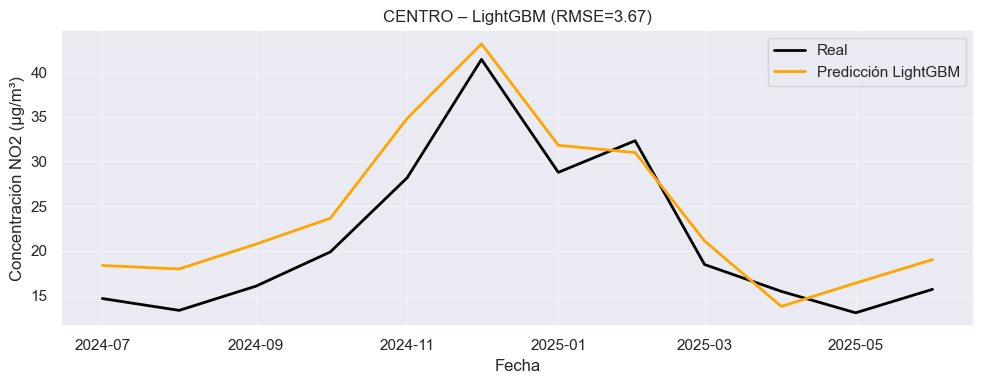

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG8\CENTRO_LightGBM_predicciones_test.png
Entrenando modelo XGBoost ...
CENTRO - XGBoost → RMSE: 2.783


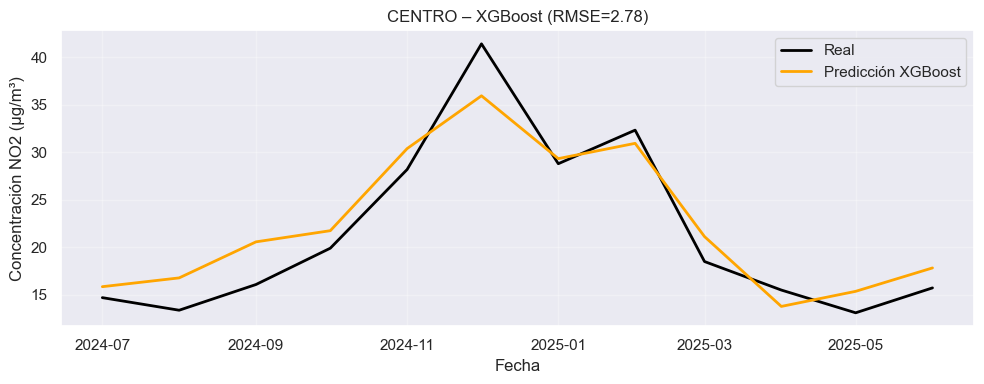

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG8\CENTRO_XGBoost_predicciones_test.png

=== ZONA SUR ===
Entrenando modelo CatBoost ...
SUR - CatBoost → RMSE: 3.489


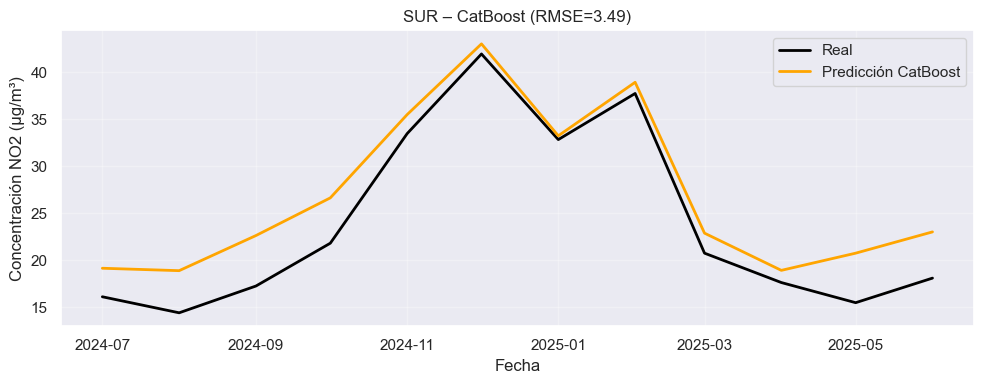

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG8\SUR_CatBoost_predicciones_test.png
Entrenando modelo LightGBM ...
SUR - LightGBM → RMSE: 4.145


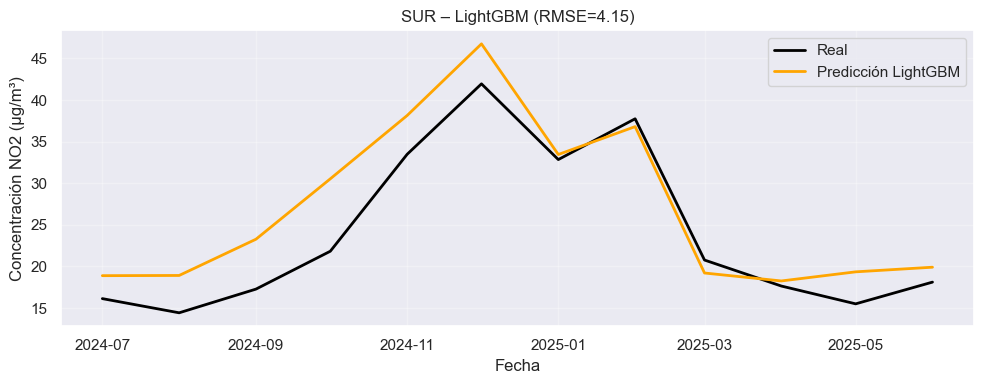

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG8\SUR_LightGBM_predicciones_test.png
Entrenando modelo XGBoost ...
SUR - XGBoost → RMSE: 2.992


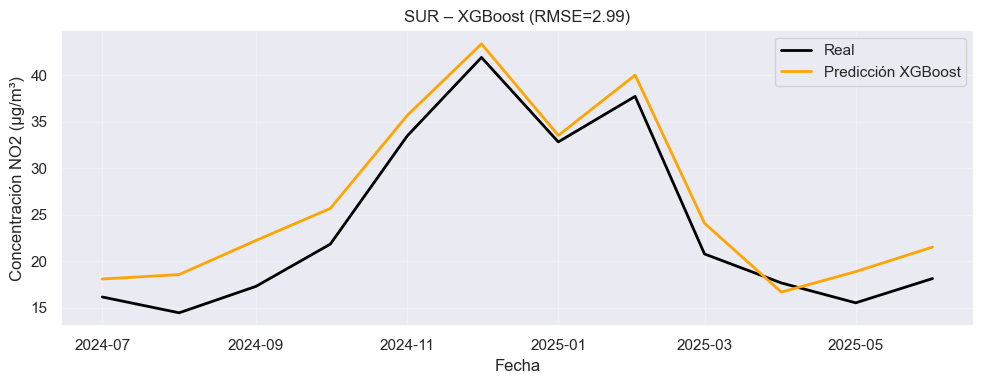

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG8\SUR_XGBoost_predicciones_test.png

>>> RESULTADOS COMPARATIVOS (RMSE test) <<<
  Zona   Modelo  RMSE_test  n_train  n_test
CENTRO  XGBoost      2.783      162      12
CENTRO CatBoost      3.370      162      12
CENTRO LightGBM      3.666      162      12
 NORTE  XGBoost      2.237      162      12
 NORTE CatBoost      2.837      162      12
 NORTE LightGBM      3.877      162      12
   SUR  XGBoost      2.992      162      12
   SUR CatBoost      3.489      162      12
   SUR LightGBM      4.145      162      12

📁 Guardado CSV resumen: 07_Figs\07_predicciones_modelos_ML_MAG8\RMSE_modelos_ML_comparativa.csv


In [69]:
# ------------------------------------------------------------
# Carpeta de salida
# ------------------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "07_predicciones_modelos_ML_MAG8"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# ------------------------------------------------------------
# Configuración de los modelos
# ------------------------------------------------------------
MODELOS = {
    "CatBoost": CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function="RMSE",
        verbose=False,          # ← SILENCIA CatBoost
        random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1              # ← SILENCIA LightGBM
    ),
    "XGBoost": XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        verbosity=0             # ← SILENCIA XGBoost
    )
}

# ------------------------------------------------------------
# Entrenar y evaluar para cada zona
# ------------------------------------------------------------

resultados_ml = []
predicciones_ml = {}

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== ZONA {zona} ===")
    
    X_train = Xtr_zona[zona]
    y_train = ytr_zona[zona]
    X_test  = Xte_zona[zona]
    y_test  = yte_zona[zona]

    predicciones_ml[zona] = {}

    for nombre, modelo in MODELOS.items():
        print(f"Entrenando modelo {nombre} ...")

        # Entrenamiento
        modelo.fit(X_train, y_train)

        # Predicción sobre test
        y_pred = modelo.predict(X_test)
        
        # Evaluación usando tu función
        rmse_val = evaluar_modelo(f"{zona} - {nombre}", y_test, y_pred)

        # Guardar resultados
        resultados_ml.append({
            "Zona": zona,
            "Modelo": nombre,
            "RMSE_test": round(rmse_val, 3),
            "n_train": len(X_train),
            "n_test": len(X_test)
        })

        # Guardar predicciones para análisis o gráfico posterior
        df_pred = pd.DataFrame({
            "real": y_test.values,
            "pred": y_pred
        }, index=y_test.index)
        predicciones_ml[zona][nombre] = df_pred

        # Gráfico comparativo
        plt.figure(figsize=(10,4))
        plt.plot(y_test.index, y_test, label="Real", color="black", linewidth=2)
        plt.plot(y_test.index, y_pred, label=f"Predicción {nombre}", color="orange", linewidth=2)
        plt.title(f"{zona} – {nombre} (RMSE={rmse_val:.2f})")
        plt.xlabel("Fecha")
        plt.ylabel("Concentración NO2 (µg/m³)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()

        ruta_fig = os.path.join(CARPETA_SALIDA, f"{zona}_{nombre}_predicciones_test.png")
        plt.savefig(ruta_fig, dpi=150)
        plt.show()
        plt.close()

        print(f"📁 Guardado gráfico: {ruta_fig}")

# ------------------------------------------------------------
# Crear tabla resumen
# ------------------------------------------------------------
df_resultados_ml = pd.DataFrame(resultados_ml)
df_resultados_ml = df_resultados_ml.sort_values(["Zona", "RMSE_test"]).reset_index(drop=True)

print("\n>>> RESULTADOS COMPARATIVOS (RMSE test) <<<")
print(df_resultados_ml.to_string(index=False))

# ------------------------------------------------------------
# Guardar CSV resumen
# ------------------------------------------------------------
csv_resultados = os.path.join(CARPETA_SALIDA, "RMSE_modelos_ML_comparativa.csv")
df_resultados_ml.to_csv(csv_resultados, index=False)
print(f"\n📁 Guardado CSV resumen: {csv_resultados}")

Guardamos los resultados de los RMSE en la tabla resumen:

In [70]:
# Renombramos columnas de df_resultados_ml para que encajen con df_rmse
df_resultados_ml = df_resultados_ml.rename(
    columns={"Zona": "zona", "Modelo": "modelo"}
)[["modelo", "zona", "RMSE_test"]]

#### 4) PREDICCIÓN HASTA 2032. EVALUACIÓN PREDICCIÓN 2030

##### 4.1. MEJOR MODELO POR ZONA

Guardamos modelos ya entrenados

In [71]:
modelos_entrenados = {  # zona -> {modelo_nombre -> objeto_modelo_entrenado}
    "NORTE": {},
    "CENTRO": {},
    "SUR": {}
}

for zona in ["NORTE", "CENTRO", "SUR"]:
    ...
    for nombre, modelo in MODELOS.items():
        ...
        modelo.fit(X_train, y_train)

        # Guardar el modelo entrenado
        modelos_entrenados[zona][nombre] = modelo

Se elije el mejor modelo en función del valor de los RMSE calculados

In [72]:
mejores_modelos_ml = (
    df_resultados_ml
    .sort_values(["zona", "RMSE_test"])
    .groupby("zona")
    .first()
    .reset_index()
)

print("\n>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<")
print(mejores_modelos_ml.to_string(index=False))


>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<
  zona  modelo  RMSE_test
CENTRO XGBoost      2.783
 NORTE XGBoost      2.237
   SUR XGBoost      2.992


In [73]:
mejor_modelo_por_zona = {}
mejor_modelo_nombre = {}

for zona in df_resultados_ml["zona"].unique():
    fila_best = (
        df_resultados_ml[df_resultados_ml["zona"] == zona]
        .sort_values("RMSE_test")
        .iloc[0]
    )
    nombre_mejor = fila_best["modelo"]
    mejor_modelo_nombre[zona] = nombre_mejor
    mejor_modelo_por_zona[zona] = modelos_entrenados[zona][nombre_mejor]

print("\n>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<")
for zona in mejor_modelo_por_zona:
    modelo = mejor_modelo_nombre[zona]
    print(f"🟢 {zona:<8} → {modelo}")


>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<
🟢 CENTRO   → XGBoost
🟢 NORTE    → XGBoost
🟢 SUR      → XGBoost


##### 4.2. FORECAST ITERATIVO HASTA 2032

Dado que no se dispone de proyecciones mensuales de variables meteorológicas hasta 2032, se optó por mantener el componente exógeno del modelo ML mediante la climatología media mensual histórica. Es decir, para cada variable exógena se calculó la media de todos los valores observados para cada mes (enero–diciembre) y se usó esa media como valores para las condiciones típicas del mes en el horizonte de predicción


=== FORECAST ML HASTA 2032 PARA NORTE ===


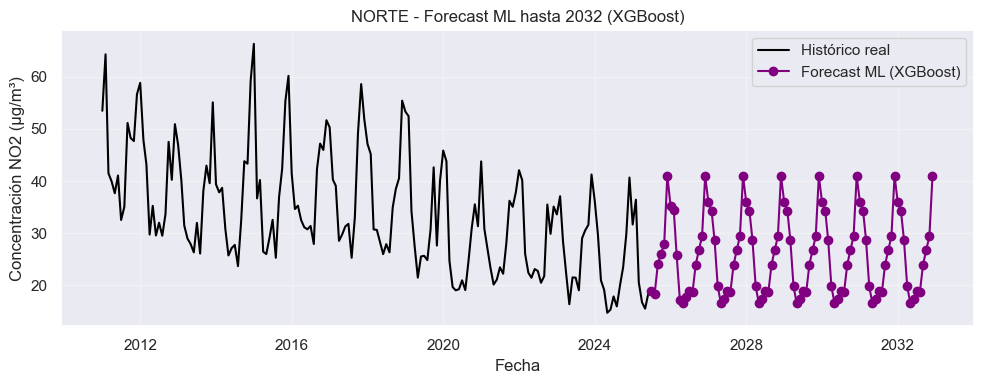

📁 Guardado gráfico forecast: 07_Figs\07_predicciones_modelos_ML_MAG8\NORTE_forecast_ML_hasta_2032_XGBoost.png

=== FORECAST ML HASTA 2032 PARA CENTRO ===


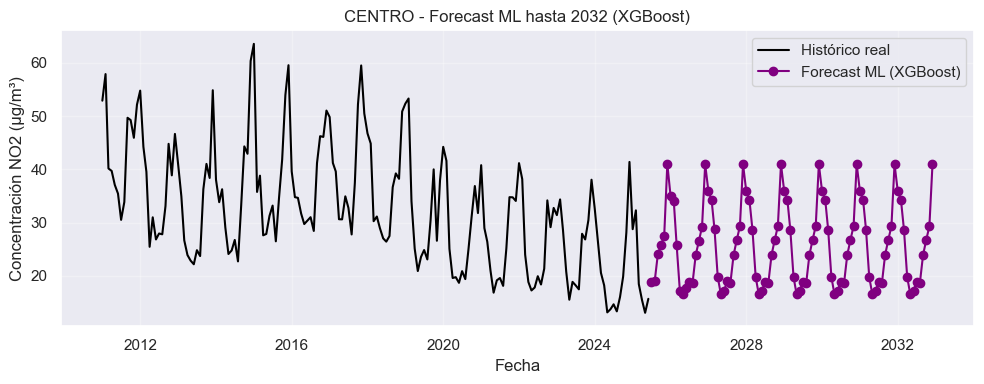

📁 Guardado gráfico forecast: 07_Figs\07_predicciones_modelos_ML_MAG8\CENTRO_forecast_ML_hasta_2032_XGBoost.png

=== FORECAST ML HASTA 2032 PARA SUR ===


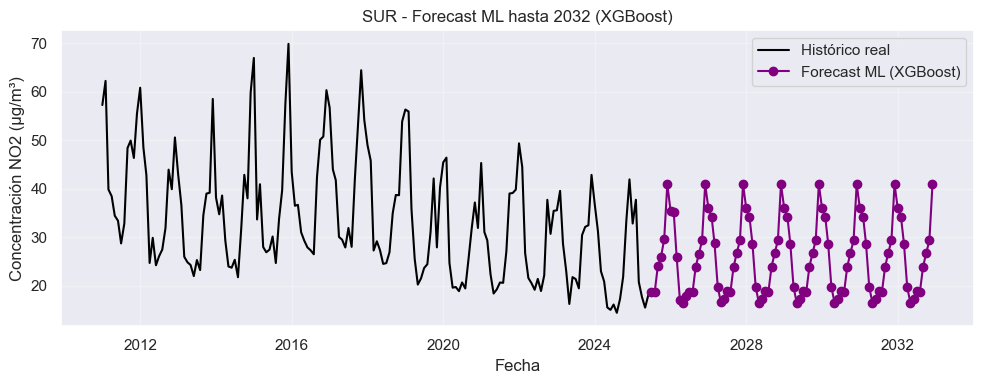

📁 Guardado gráfico forecast: 07_Figs\07_predicciones_modelos_ML_MAG8\SUR_forecast_ML_hasta_2032_XGBoost.png

>>> PROMEDIOS ANUALES PREVISTOS 2030 (MODELOS ML) <<<
 modelo   zona  promedio_anual_2030
XGBoost  NORTE            25.917999
XGBoost CENTRO            25.917999
XGBoost    SUR            25.917999


In [74]:
# ============================================================
# FORECAST ML HASTA 2032 (USANDO MODELO GANADOR POR ZONA)
# Y PROMEDIOS ANUALES 2030
# ============================================================

# Lista de columnas exógenas que se usaron en el entrenamiento ML
columnas_exogenas_para_ML = [
    "VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)", "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)", "VIENTO_DIR_10 (°)", "TEMPERATURA_MIN (°C)"
]

predicciones_futuras_ml = {}
promedios_2030_ml = []

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== FORECAST ML HASTA 2032 PARA {zona} ===")

    # 1. Recuperar el mejor modelo ya entrenado para esta zona
    mejor_modelo = mejor_modelo_por_zona[zona]
    nombre_mejor_modelo = mejor_modelo_nombre[zona]

    # 2. Histórico ML de la zona (devuelto por preparar_datos_ml)
    #    Este df_ml_zona[zona] debe tener índice datetime mensual
    #    y columnas: target, mes, anio, t_index, lags, rollings, exógenas...
    df_hist = df_ml_zona[zona].copy().sort_index()

    # 3. Columnas de entrada exactas esperadas por el modelo
    #    (el orden tiene que ser idéntico al entrenamiento)
    feature_cols = Xtr_zona[zona].columns.tolist()

    # 4. Forecast iterativo hasta dic 2032 usando climatología mensual de exógenas
    df_forecast = forecast_autoregresivo_hasta_2032(
        df_ml_hist=df_hist,
        modelo_entrenado=mejor_modelo,
        feature_cols=feature_cols,
        fecha_fin_forecast="2032-12-31",
        lags=[1,2,3,12],
        usar_columnas_exogenas=columnas_exogenas_para_ML
    )

    # Guardamos predicción larga para esa zona
    predicciones_futuras_ml[zona] = {
        "modelo": nombre_mejor_modelo,
        "forecast": df_forecast
    }

    # 5. Calcular el promedio del año 2030 para esa zona
    df_2030 = df_forecast[df_forecast.index.year == 2030]
    promedio_2030 = df_2030["pred"].mean()

    promedios_2030_ml.append({
        "modelo": nombre_mejor_modelo,
        "zona": zona,
        "promedio_anual_2030": promedio_2030
    })

    # 6. Graficar histórico + predicción futura
    plt.figure(figsize=(10,4))
    plt.plot(df_hist.index, df_hist["target"], color="black", linewidth=1.5, label="Histórico real")
    plt.plot(df_forecast.index, df_forecast["pred"], color="purple", marker="o",
             linewidth=1.5, label=f"Forecast ML ({nombre_mejor_modelo})")

    plt.title(f"{zona} - Forecast ML hasta 2032 ({nombre_mejor_modelo})")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración NO2 (µg/m³)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    ruta_fig_forecast = os.path.join(
        CARPETA_SALIDA,
        f"{zona}_forecast_ML_hasta_2032_{nombre_mejor_modelo}.png"
    )
    plt.savefig(ruta_fig_forecast, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico forecast: {ruta_fig_forecast}")

# ------------------------------------------------------------
# Convertimos la lista de promedios a DataFrame limpio
# ------------------------------------------------------------
df_promedios_2030_ml = pd.DataFrame(promedios_2030_ml)
df_promedios_2030_ml["promedio_anual_2030"] = df_promedios_2030_ml["promedio_anual_2030"].round(3)

print("\n>>> PROMEDIOS ANUALES PREVISTOS 2030 (MODELOS ML) <<<")
print(df_promedios_2030_ml.to_string(index=False))


### MODELOS DEEP LEARNING (LSTM y CNN)

Ahora vamos a entrenar dos arquitecturas por zona con modelos depp learning:

- LSTM (red recurrente que captura dependencias temporales largas)
- CNN1D causal (convoluciones sobre la serie temporal que detectan patrones locales/estacionales)
  * 1D = Unidimensional: los datos tienen una sola dimensión relevante para el modelo. En series temporales, esta dimensión es el tiempo.

1. Vamos a usar las mismas variables tabulares que ya tenemos de los modelos ML (lags, rolling, mes, exógenas climatológicas…), pero ahora tenemos que transformarlas en secuencias.
2. Evaluamos en el mismo conjunto test temporal (corte 2024-06-30).
3. Metemos sus RMSE en la tabla de comparación.
4. Preparamos (después) el forecast autoregresivo hasta 2032 con el mejor modelo por zona igual que hicimos con ML.
5. Metemos la predicción de 2030 en la tabls de comparación.

####  1) PREPARAR DATOS SECUENCIALES 

In [75]:
columnas_input_dl = [
    "target",
    "mes", "t_index",
    "roll3_mean", "roll6_mean", "roll12_mean",
    "VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)", "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)", "VIENTO_DIR_10 (°)", "TEMPERATURA_MIN (°C)"
]

In [76]:
CARPETA_BASE = "07_Figs"
SUBCARPETA = "08_deep_learning_MAG8"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

####  2) ENTRENAR LSTM Y CNN1D PARA CADA ZONA

Tras una primera ejecución del modelo, observo un claro sobreajuste, por lo que trato de mitigarlo:

**2.1. Añado EaarlyStopping:** Permite que el modelo se pare cuando deja de mejorar en validación.

**2.2. Añado Dropout en la LSTM:** El Dropout apaga aleatoriamente neuronas durante el entrenamiento para obligar al modelo a generalizar.

**2.3. Simplifico la CNN1D:** Le quito filtros a las distintas capas


=== ZONA NORTE (Deep Learning) ===
DL | Corte 2024-06-30 | train=150 muestras | test=12 muestras
   Shapes -> X_train (150, 12, 18), y_train (150,), X_test (12, 12, 18), y_test (12,)
LSTM shapes: y_test_dl (12,), y_pred_lstm (12,)
LSTM NORTE → RMSE: 8.581
CNN1D shapes: y_test_dl (12,), y_pred_cnn (12,)
CNN1D NORTE → RMSE: 3.790


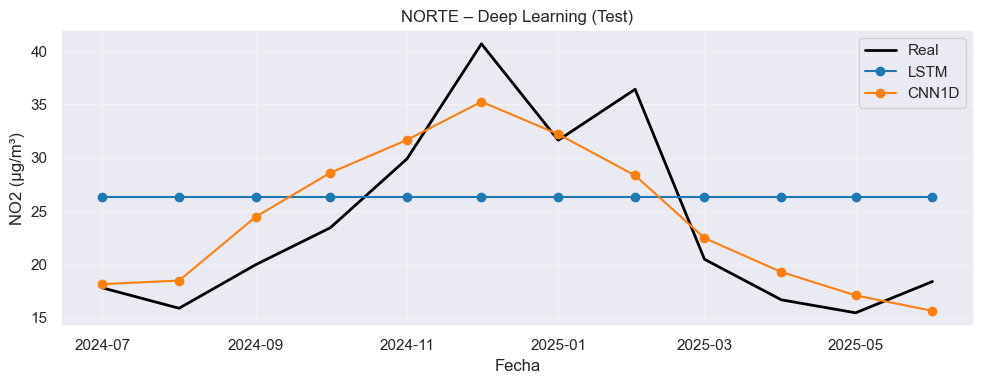

📁 Guardado gráfico: 07_Figs\08_deep_learning_MAG8\NORTE_DL_test_comparacion.png

=== ZONA CENTRO (Deep Learning) ===
DL | Corte 2024-06-30 | train=150 muestras | test=12 muestras
   Shapes -> X_train (150, 12, 18), y_train (150,), X_test (12, 12, 18), y_test (12,)
LSTM shapes: y_test_dl (12,), y_pred_lstm (12,)
LSTM CENTRO → RMSE: 22.338
CNN1D shapes: y_test_dl (12,), y_pred_cnn (12,)
CNN1D CENTRO → RMSE: 13.604


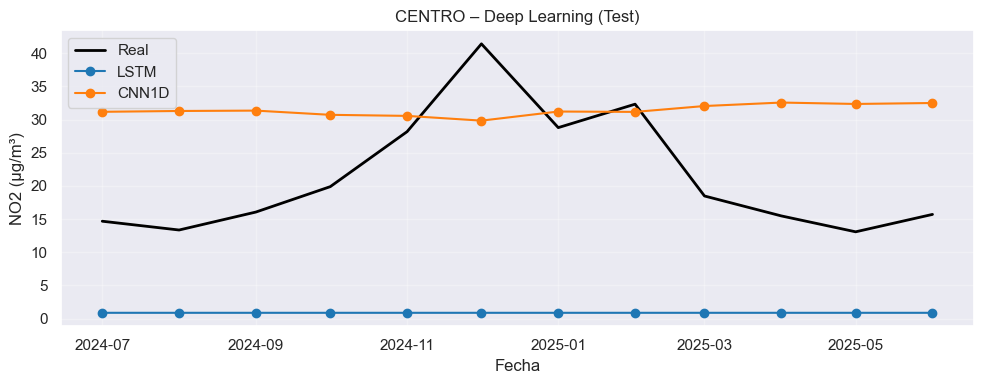

📁 Guardado gráfico: 07_Figs\08_deep_learning_MAG8\CENTRO_DL_test_comparacion.png

=== ZONA SUR (Deep Learning) ===
DL | Corte 2024-06-30 | train=150 muestras | test=12 muestras
   Shapes -> X_train (150, 12, 18), y_train (150,), X_test (12, 12, 18), y_test (12,)
LSTM shapes: y_test_dl (12,), y_pred_lstm (12,)
LSTM SUR → RMSE: 24.617
CNN1D shapes: y_test_dl (12,), y_pred_cnn (12,)
CNN1D SUR → RMSE: 33.655


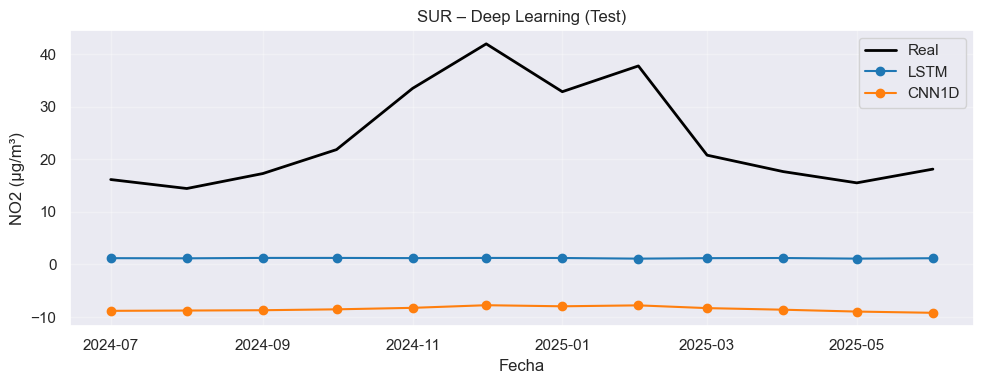

📁 Guardado gráfico: 07_Figs\08_deep_learning_MAG8\SUR_DL_test_comparacion.png

>>> RESULTADOS DEEP LEARNING (RMSE en test) <<<
  zona modelo  RMSE_test  n_train  n_test
 NORTE   LSTM      8.581      150      12
 NORTE  CNN1D      3.790      150      12
CENTRO   LSTM     22.338      150      12
CENTRO  CNN1D     13.604      150      12
   SUR   LSTM     24.617      150      12
   SUR  CNN1D     33.655      150      12


In [77]:
# Semilla global reproducible
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

callback_es = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

resultados_dl = []
predicciones_dl_test = {}
modelos_dl_entrenados = {"NORTE": {}, "CENTRO": {}, "SUR": {}}

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== ZONA {zona} (Deep Learning) ===")

    df_ml = df_ml_zona[zona].copy().sort_index()
    cols_presentes = [c for c in columnas_input_dl if c in df_ml.columns]

    X_train_dl, y_train_dl, X_test_dl, y_test_dl, fechas_test_dl = construir_secuencias_dl(
        df_ml,
        fecha_corte="2024-06-30",
        window_size=12,
        columnas_input=cols_presentes,
        columna_objetivo="target"
    )

    n_steps  = X_train_dl.shape[1]
    n_feats  = X_train_dl.shape[2]

    # split interno train/val cronológico
    X_sub, y_sub, X_val, y_val = split_train_val(X_train_dl, y_train_dl, val_ratio=0.15)

    # --------- LSTM ---------
    lstm_model = build_lstm_model(n_steps, n_feats)
    lstm_model.fit(
        X_sub, y_sub,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=8,
        verbose=0,
        callbacks=[callback_es]
    )

    y_pred_lstm = lstm_model.predict(X_test_dl, verbose=0).flatten()
    print(f"LSTM shapes: y_test_dl {y_test_dl.shape}, y_pred_lstm {y_pred_lstm.shape}")
    rmse_lstm = evaluar_modelo(f"LSTM {zona}", y_test_dl, y_pred_lstm)

    resultados_dl.append({
        "zona": zona,
        "modelo": "LSTM",
        "RMSE_test": rmse_lstm,
        "n_train": X_train_dl.shape[0],
        "n_test": X_test_dl.shape[0]
    })

    predicciones_dl_test[(zona, "LSTM")] = pd.DataFrame({
        "real": y_test_dl,
        "pred": y_pred_lstm
    }, index=fechas_test_dl)

    modelos_dl_entrenados[zona]["LSTM"] = {
        "model": lstm_model,
        "cols_input": cols_presentes,
        "window_size": 12
    }

    # --------- CNN1D ---------
    cnn_model = build_cnn1d_model(n_steps, n_feats)
    cnn_model.fit(
        X_sub, y_sub,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=8,
        verbose=0,
        callbacks=[callback_es]
    )

    y_pred_cnn = cnn_model.predict(X_test_dl, verbose=0).flatten()
    print(f"CNN1D shapes: y_test_dl {y_test_dl.shape}, y_pred_cnn {y_pred_cnn.shape}")
    rmse_cnn = evaluar_modelo(f"CNN1D {zona}", y_test_dl, y_pred_cnn)

    resultados_dl.append({
        "zona": zona,
        "modelo": "CNN1D",
        "RMSE_test": rmse_cnn,
        "n_train": X_train_dl.shape[0],
        "n_test": X_test_dl.shape[0]
    })

    predicciones_dl_test[(zona, "CNN1D")] = pd.DataFrame({
        "real": y_test_dl,
        "pred": y_pred_cnn
    }, index=fechas_test_dl)

    modelos_dl_entrenados[zona]["CNN1D"] = {
        "model": cnn_model,
        "cols_input": cols_presentes,
        "window_size": 12
    }

    # --------- gráfico y guardado ---------
    plt.figure(figsize=(10,4))
    plt.plot(fechas_test_dl, y_test_dl, color="black", linewidth=2, label="Real")
    plt.plot(fechas_test_dl, y_pred_lstm, color="tab:blue", marker="o", label="LSTM")
    plt.plot(fechas_test_dl, y_pred_cnn, color="tab:orange", marker="o", label="CNN1D")
    plt.title(f"{zona} – Deep Learning (Test)")
    plt.ylabel("NO2 (µg/m³)")
    plt.xlabel("Fecha")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    ruta_png = os.path.join(CARPETA_SALIDA, f"{zona}_DL_test_comparacion.png")
    plt.savefig(ruta_png, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico: {ruta_png}")

# resumen final
df_resultados_dl = pd.DataFrame(resultados_dl)
print("\n>>> RESULTADOS DEEP LEARNING (RMSE en test) <<<")
print(df_resultados_dl.round(3).to_string(index=False))

In [78]:
df_resultados_dl_std = df_resultados_dl.rename(
    columns={"modelo": "modelo", "zona": "zona", "RMSE_test": "RMSE_test"}
)[["modelo", "zona", "RMSE_test", "n_train", "n_test"]]

####  3) PREDICCIÓN HASTA 2032. EVALUACIÓN PREDICCIÓN 2030

In [79]:
for zona in ["NORTE", "CENTRO", "SUR"]:
    df_ml_zona[zona].columns = [c.strip() for c in df_ml_zona[zona].columns]
    df_ml_zona[zona] = df_ml_zona[zona][~df_ml_zona[zona].index.duplicated(keep="first")]
    df_ml_zona[zona].sort_index(inplace=True)


=== FORECAST DL HASTA 2032 PARA NORTE ===
   ➤ Mejor modelo DL en NORTE: CNN1D
   📁 Guardado forecast CSV: 07_Figs\08_deep_learning_MAG8\forecast_DL_NORTE_CNN1D_hasta_2032.csv


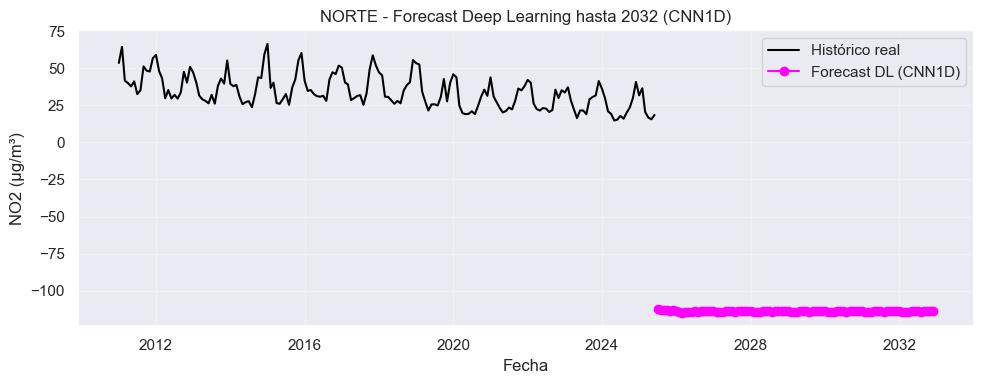

   📁 Guardado gráfico forecast: 07_Figs\08_deep_learning_MAG8\NORTE_forecast_DL_hasta_2032_CNN1D.png

=== FORECAST DL HASTA 2032 PARA CENTRO ===
   ➤ Mejor modelo DL en CENTRO: CNN1D
   📁 Guardado forecast CSV: 07_Figs\08_deep_learning_MAG8\forecast_DL_CENTRO_CNN1D_hasta_2032.csv


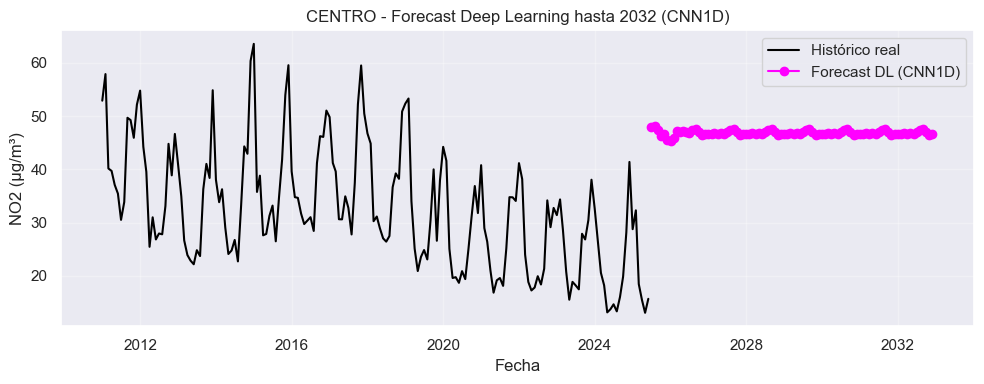

   📁 Guardado gráfico forecast: 07_Figs\08_deep_learning_MAG8\CENTRO_forecast_DL_hasta_2032_CNN1D.png

=== FORECAST DL HASTA 2032 PARA SUR ===
   ➤ Mejor modelo DL en SUR: LSTM
   📁 Guardado forecast CSV: 07_Figs\08_deep_learning_MAG8\forecast_DL_SUR_LSTM_hasta_2032.csv


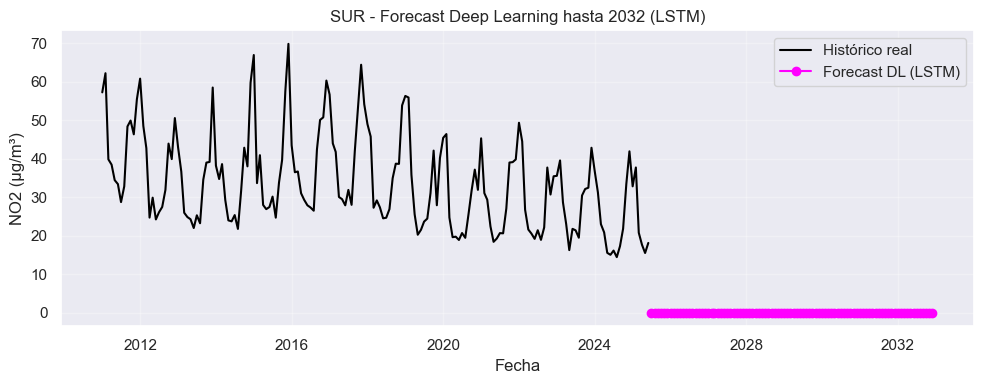

   📁 Guardado gráfico forecast: 07_Figs\08_deep_learning_MAG8\SUR_forecast_DL_hasta_2032_LSTM.png

>>> PROMEDIOS ANUALES PREVISTOS 2030 (Deep Learning - mejor modelo por zona) <<<
modelo   zona  promedio_anual_2030
 CNN1D  NORTE             -113.897
 CNN1D CENTRO               46.881
  LSTM    SUR               -0.022


In [80]:
promedios_2030_dl = []
predicciones_futuras_dl = {}

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== FORECAST DL HASTA 2032 PARA {zona} ===")

    df_hist_zona = df_ml_zona[zona].copy().sort_index()

    # mejor modelo DL (menor RMSE_test)
    fila_best_dl = (
        df_resultados_dl[df_resultados_dl["zona"] == zona]
        .sort_values("RMSE_test")
        .iloc[0]
    )
    nombre_mejor_dl = fila_best_dl["modelo"]
    print(f"   ➤ Mejor modelo DL en {zona}: {nombre_mejor_dl}")

    info_mejor = modelos_dl_entrenados[zona][nombre_mejor_dl]
    modelo_dl         = info_mejor["model"]
    cols_input_mejor  = info_mejor["cols_input"]      # lista original de entrenamiento (19 cols)
    window_size_mejor = info_mejor["window_size"]     # 12

    df_forecast_dl = forecast_dl_hasta_2032(
        df_ml_hist=df_hist_zona,
        modelo_dl=modelo_dl,
        columnas_input_entrenamiento=cols_input_mejor,
        window_size=window_size_mejor,
        fecha_fin_forecast="2032-12-31"
    )

    predicciones_futuras_dl[zona] = {
        "modelo": nombre_mejor_dl,
        "forecast": df_forecast_dl
    }

    # promedio anual 2030
    df_2030_dl = df_forecast_dl[df_forecast_dl.index.year == 2030]
    promedio_2030_dl = df_2030_dl["pred"].mean()

    promedios_2030_dl.append({
        "modelo": nombre_mejor_dl,
        "zona": zona,
        "promedio_anual_2030": promedio_2030_dl
    })

    # guardar CSV forecast completo
    ruta_csv_forecast = os.path.join(
        CARPETA_SALIDA,
        f"forecast_DL_{zona}_{nombre_mejor_dl}_hasta_2032.csv"
    )
    df_forecast_dl.round(3).to_csv(ruta_csv_forecast)
    print(f"   📁 Guardado forecast CSV: {ruta_csv_forecast}")

    # gráfico histórico + forecast hasta 2032
    plt.figure(figsize=(10,4))
    plt.plot(df_hist_zona.index, df_hist_zona["target"], color="black", linewidth=1.5, label="Histórico real")
    plt.plot(df_forecast_dl.index, df_forecast_dl["pred"], color="magenta", marker="o",
             linewidth=1.5, label=f"Forecast DL ({nombre_mejor_dl})")
    plt.title(f"{zona} - Forecast Deep Learning hasta 2032 ({nombre_mejor_dl})")
    plt.xlabel("Fecha")
    plt.ylabel("NO2 (µg/m³)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    ruta_png_forecast = os.path.join(
        CARPETA_SALIDA,
        f"{zona}_forecast_DL_hasta_2032_{nombre_mejor_dl}.png"
    )
    plt.savefig(ruta_png_forecast, dpi=150)
    plt.show()
    plt.close()

    print(f"   📁 Guardado gráfico forecast: {ruta_png_forecast}")

# resumen comparativo 2030 (DL)
df_promedios_2030_dl = pd.DataFrame(promedios_2030_dl)
df_promedios_2030_dl["promedio_anual_2030"] = df_promedios_2030_dl["promedio_anual_2030"].round(3)

print("\n>>> PROMEDIOS ANUALES PREVISTOS 2030 (Deep Learning - mejor modelo por zona) <<<")
print(df_promedios_2030_dl.to_string(index=False))


### CUADRO COMPARATIVA MODELOS I

In [81]:
# ==========================================================
# 1️⃣ Convertir listas a DataFrames
# ==========================================================
df_rmse = pd.DataFrame(tabla_rmse_modelos)
df_pred_2030 = pd.DataFrame(tabla_predicciones_2030)

# Unir RMSEs de ARIMA/SARIMA + ML + deep learning
df_rmse = pd.concat([df_rmse, df_resultados_ml], ignore_index=True)
df_rmse = pd.concat(
    [df_rmse, df_resultados_dl_std],
    ignore_index=True
)

# Unir predicción 2030 de ARIMA/SARIMA + ML + deep learning
df_pred_2030 = pd.concat([df_pred_2030, df_promedios_2030_ml], ignore_index=True)
df_pred_2030 = pd.concat([df_pred_2030, df_promedios_2030_dl], ignore_index=True)

# ==========================================================
# 2️⃣ Agrupar predicciones 2030 (modelo + zona)
# ==========================================================
df_pred_2030_resumen = (
    df_pred_2030
    .drop(columns=["pred_2030"], errors="ignore")       # eliminar columna de predicción individual
    .groupby(["modelo", "zona"], as_index=False)        # agrupar por modelo y zona
    .agg({"promedio_anual_2030": "mean"})               # mantener promedio
    .sort_values(by=["zona", "promedio_anual_2030"], ascending=[True, True])
)

# ==========================================================
# 3️⃣ Ordenar tabla RMSE por zona
# ==========================================================
df_rmse = (
    df_rmse
    .sort_values(by=["zona", "RMSE_test"], ascending=[True, True])
    .drop(columns=["order", "seasonal_order", "AIC","n_train", "n_test"], errors="ignore")
)

# ==========================================================
# 4️⃣ Mostrar resultados
# ==========================================================
print("\n>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<")
print(df_rmse.round(3).to_string(index=False))

print("\n>>> TABLA RESUMEN DE PROMEDIOS 2030 (agrupada) <<<")
print(df_pred_2030_resumen.round(3).to_string(index=False))

# ==========================================================
# 5️⃣ Filtrar solo los modelos con menor RMSE por zona
# ==========================================================
mejores_modelos_por_zona = (
    df_rmse
    .sort_values(["zona", "RMSE_test"], ascending=[True, True])
    .groupby("zona", as_index=False)
    .first()[["zona", "modelo", "RMSE_test"]]
)

print("\n>>> MODELOS CON MENOR RMSE POR ZONA <<<")
print(mejores_modelos_por_zona.round(3).to_string(index=False))

# ==========================================================
# 6️⃣ Filtrar predicciones 2030 solo de esos modelos
# ==========================================================
df_pred_mejores_2030 = pd.merge(
    mejores_modelos_por_zona[["zona", "modelo"]],
    df_pred_2030_resumen,
    on=["zona", "modelo"],
    how="left"
)

print("\n>>> PREDICCIONES 2030 DE LOS MEJORES MODELOS (por zona) <<<")
print(df_pred_mejores_2030.round(3).to_string(index=False))



>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<
  modelo   zona  RMSE_test
 XGBoost CENTRO      2.783
CatBoost CENTRO      3.370
LightGBM CENTRO      3.666
  SARIMA CENTRO      4.405
   ARIMA CENTRO     11.596
   CNN1D CENTRO     13.604
    LSTM CENTRO     22.338
 XGBoost  NORTE      2.237
CatBoost  NORTE      2.837
  SARIMA  NORTE      3.674
   CNN1D  NORTE      3.790
LightGBM  NORTE      3.877
    LSTM  NORTE      8.581
   ARIMA  NORTE     11.929
 XGBoost    SUR      2.992
CatBoost    SUR      3.489
LightGBM    SUR      4.145
  SARIMA    SUR      4.624
   ARIMA    SUR     12.907
    LSTM    SUR     24.617
   CNN1D    SUR     33.655

>>> TABLA RESUMEN DE PROMEDIOS 2030 (agrupada) <<<
 modelo   zona  promedio_anual_2030
 SARIMA CENTRO               14.787
  ARIMA CENTRO               15.739
XGBoost CENTRO               25.918
  CNN1D CENTRO               46.881
  CNN1D  NORTE             -113.897
 SARIMA  NORTE               17.325
  ARIMA  NORTE               18.265
XGBoost  NORTE

### PREDICCIÓN CONSIDERANDO EL TRÁFICO

#### PREPARACIÓN DATOS

Ahora vamos a ejecutar los siguientes modelos, pero incluyendo la variable relativa al tráfico ("TOTAL_HOR_EXT"). Dado que esta variable no contiene valores coherentes antes de 2019, friltramos el dataframe, de modo que me quede con:

- Valores posteriores a 2019.
- Instancias con MAGNITUD = 8 (NO2)
- Las variables interesantes de antes + "TOTAL_HOR_EXT"
- Sobre este dataframe aplicaré los modelos:
  * CatBoost para las 3 zonas.
  * XGBoost para las 3 zonas.

In [82]:
df_traf = pd.read_parquet("05_DATASET_FINAL.parquet")

In [83]:
df_traf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186780 entries, 0 to 186779
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DIA/MES/ANO               186780 non-null  datetime64[ns]
 1   MAGNITUD                  186780 non-null  category      
 2   ZONA_ESTACION             186780 non-null  category      
 3   MEDICION_ugm3             186780 non-null  float64       
 4   TEMPERATURA_MAX (°C)      186780 non-null  float64       
 5   TEMPERATURA_MIN (°C)      186780 non-null  float64       
 6   TEMPERATURA_MED (°C)      186780 non-null  float64       
 7   PRECIPITACIONES (mm)      186780 non-null  float64       
 8   HUMEDAD_MAX (%)           186780 non-null  float64       
 9   HUMEDAD_MIN (%)           186780 non-null  float64       
 10  HUMEDAD_MED (%)           186780 non-null  float64       
 11  NIEVE (cm)                186780 non-null  float64       
 12  VI

In [84]:
df_traf.head()

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
0  2010-01-01        1        CENTRO       8.666667              8.833577   
1  2010-01-01        9           SUR       8.000000              8.833577   
2  2010-01-01        9         NORTE       8.000000              8.833577   
3  2010-01-01        9        CENTRO       6.000000              8.833577   
4  2010-01-01        8           SUR      21.666667              8.833577   

   TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
0              4.033577              5.879828                   0.1   
1              4.033577              5.879828                   0.1   
2              4.033577              5.879828                   0.1   
3              4.033577              5.879828                   0.1   
4              4.033577              5.879828                   0.1   

   HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  NUBES (%)  HORAS_SOL (min)  \
0         81.77903        63.816715  ...  55.933334        227.16466   
1         81.77903        63.816715  ...  55.933334        227.16466   
2         81.77903        63.816715  ...  55.933334        227.16466   
3         81.77903        63.816715  ...  55.933334        227.16466   
4         81.77903        63.816715  ...  55.933334        227.16466   

   RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  PRESION_MIN (hPa)  \
0                   1329.0             1017.5             1007.3   
1                   1329.0             1017.5             1007.3   
2                   1329.0             1017.5             1007.3   
3                   1329.0             1017.5             1007.3   
4                   1329.0             1017.5             1007.3   

   PRESION_MED (hPa)   TOTAL_HOR_EXT  Superficie_incendiada_HA  dow  month  
0         1011.06665       2196158.0                       0.0    4      1  
1         1011.06665  2012742.333333                       0.0    4      1  
2         1011.06665       1489878.0                       0.0    4      1  
3         1011.06665       2196158.0                       0.0    4      1  
4         1011.06665  2012742.333333                       0.0    4      1  

[5 rows x 30 columns]

In [85]:
# 1) Fecha a datetime una sola vez
df_traf["DIA/MES/ANO"] = pd.to_datetime(df_traf["DIA/MES/ANO"], errors="coerce")
if df_traf["DIA/MES/ANO"].isna().any():
    df_traf["DIA/MES/ANO"] = pd.to_datetime(df_traf["DIA/MES/ANO"], errors="coerce", dayfirst=True)

# 2) Crear columna year
df_traf["year"] = df_traf["DIA/MES/ANO"].dt.year

# 3) Filtrar MAGNITUD = 8 y year >= 2019
df_traf_2019_NO2 = df_traf[(df_traf["MAGNITUD"] == "8") & (df_traf["year"] >= 2019)].copy()

# 4) Diccionario por zona (no sobrescribas el DataFrame)
dfs_traf_2019_NO2 = {
    zona: sub_df.copy()
    for zona, sub_df in df_traf_2019_NO2.groupby("ZONA_ESTACION")
}

# Chequeo rápido
print(len(df_traf_2019_NO2), "filas desde 2019 (NO2).")
print("Zonas:", list(dfs_traf_2019_NO2.keys()))



7119 filas desde 2019 (NO2).
Zonas: ['CENTRO', 'NORTE', 'SUR']


C:\Users\rosal\AppData\Local\Temp\ipykernel_52180\3894411610.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for zona, sub_df in df_traf_2019_NO2.groupby("ZONA_ESTACION")


In [86]:
df_ejemplo = dfs_traf_2019_NO2["NORTE"]
df_ejemplo.head(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  \
108481  2019-01-01        8         NORTE      64.833333   
108513  2019-01-02        8         NORTE      74.250000   
108546  2019-01-03        8         NORTE      61.055556   
108579  2019-01-04        8         NORTE      75.861111   
108612  2019-01-05        8         NORTE      74.333333   

        TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  \
108481             14.093577             -3.186423              3.386910   
108513             13.403577             -3.296423              3.027327   
108546             12.413577             -0.656423              4.486494   
108579             13.353578             -2.856423              3.270660   
108612             14.073577             -4.556423              2.530660   

        PRECIPITACIONES (mm)  HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  \
108481                   0.0         92.17930        36.185154  ...   
108513                   0.0         91.89168        35.215717  ...   
108546                   0.0         77.43969        33.838745  ...   
108579                   0.0         87.16396        36.146990  ...   
108612                   0.0         91.95199        36.551476  ...   

        HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
108481        563.75000                   2617.0             1032.9   
108513        555.46155                   2618.0             1031.8   
108546        433.56850                   2516.0             1030.4   
108579        566.23334                   2688.0             1032.5   
108612        567.05000                   2697.0             1035.3   

        PRESION_MIN (hPa)  PRESION_MED (hPa)  TOTAL_HOR_EXT  \
108481             1030.0          1031.2207  253170.666667   
108513             1026.8          1029.3458  253326.333333   
108546             1027.4          1028.8250       253947.0   
108579             1029.6          1030.7583       250629.0   
108612             1031.4          1033.1334       215091.0   

        Superficie_incendiada_HA  dow  month  year  
108481                      0.00    1      1  2019  
108513                      2.61    2      1  2019  
108546                      0.00    3      1  2019  
108579                     42.60    4      1  2019  
108612                      0.00    5      1  2019  

[5 rows x 31 columns]

In [87]:
# --- Filtrado de columnas por variables de interés ---
variables_interes = [
    "ZONA_ESTACION","VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)", "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)", "dow", "month", "VIENTO_DIR_10 (°)", "TEMPERATURA_MIN (°C)", "TOTAL_HOR_EXT"
]

# Creamos un nuevo diccionario con solo las columnas seleccionadas
dfs_mag_zona_traf_sel = {
    zona: sub_df[variables_interes].copy()
    for zona, sub_df in dfs_traf_2019_NO2.items()
    if all(col in sub_df.columns for col in variables_interes)
}

# --- Resumen ---
print(f"Sub–dataframes creados: {len(dfs_mag_zona_traf_sel)}")
for zona, df_sub in dfs_mag_zona_traf_sel.items():
    print(f"{zona}: {df_sub.shape[0]} filas, {df_sub.shape[1]} columnas")


Sub–dataframes creados: 3
CENTRO: 2373 filas, 15 columnas
NORTE: 2373 filas, 15 columnas
SUR: 2373 filas, 15 columnas


In [88]:
df_ejemplo = dfs_mag_zona_traf_sel["NORTE"]
df_ejemplo.head(5)

ZONA_ESTACION  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
108481         NORTE              8.209263              1.138420   
108513         NORTE              9.028754              1.138420   
108546         NORTE              9.028754              2.276840   
108579         NORTE              7.787991              0.509117   
108612         NORTE              7.172949              1.609969   

        VIENTO_MED_10 (km/h)  VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  \
108481              3.871547               9.746631               1.297998   
108513              5.512785              20.767975               2.902413   
108546              5.765665              23.177400               3.319036   
108579              3.758786               8.669949               0.509117   
108612              4.469867              13.207634               2.545584   

        VIENTO_MED_100 (km/h)  PRESION_MAX (hPa)  PRESION_MIN (hPa)  \
108481               4.828871             1032.9             1030.0   
108513               9.415603             1031.8             1026.8   
108546              11.556825             1030.4             1027.4   
108579               5.060158             1032.5             1029.6   
108612               6.483671             1035.3             1031.4   

        PRESION_MED (hPa)  dow  month  VIENTO_DIR_10 (°)  \
108481          1031.2207    1      1         328.109200   
108513          1029.3458    2      1         348.094900   
108546          1028.8250    3      1          28.022064   
108579          1030.7583    4      1         330.077880   
108612          1033.1334    5      1         325.355100   

        TEMPERATURA_MIN (°C)  TOTAL_HOR_EXT  
108481             -3.186423  253170.666667  
108513             -3.296423  253326.333333  
108546             -0.656423       253947.0  
108579             -2.856423       250629.0  
108612             -4.556423       215091.0

In [89]:
# 1️⃣ Preparar diccionario de dataframes (ya MAG=8, desde 2019)
dfs_traf_2019_NO2_sel = {
    z: sub[[c for c in variables_interes + ["DIA/MES/ANO", "MEDICION_ugm3"] if c in sub.columns]].copy()
    for z, sub in dfs_traf_2019_NO2.items()
}

# 2️⃣ Crear datasets ML por zona
resultados_ml = preparar_para_modelos_por_zona(
    dfs_por_zona=dfs_traf_2019_NO2_sel,
    variables_interes=variables_interes,
    fecha_corte="2024-06-30",
    lags=[1,2,3,12]
)

# NORTE
Xtr_norte = resultados_ml["NORTE"]["X_train"]
ytr_norte = resultados_ml["NORTE"]["y_train"]
Xte_norte = resultados_ml["NORTE"]["X_test"]
yte_norte = resultados_ml["NORTE"]["y_test"]

# CENTRO
Xtr_centro = resultados_ml["CENTRO"]["X_train"]
ytr_centro = resultados_ml["CENTRO"]["y_train"]
Xte_centro = resultados_ml["CENTRO"]["X_test"]
yte_centro = resultados_ml["CENTRO"]["y_test"]

# SUR
Xtr_sur = resultados_ml["SUR"]["X_train"]
ytr_sur = resultados_ml["SUR"]["y_train"]
Xte_sur = resultados_ml["SUR"]["X_test"]
yte_sur = resultados_ml["SUR"]["y_test"]

for zona, datos in resultados_ml.items():
    Xtr, ytr = datos["X_train"], datos["y_train"]
    Xte, yte = datos["X_test"], datos["y_test"]
    print(f"{zona}: {Xtr.shape} train / {Xte.shape} test")


📆 Corte temporal 2024-06-30: train=54 / test=12
📆 Corte temporal 2024-06-30: train=54 / test=12
📆 Corte temporal 2024-06-30: train=54 / test=12

📊 Resumen por zona:
- CENTRO: train=54 | test=12 | exógenas=13
- NORTE: train=54 | test=12 | exógenas=13
- SUR: train=54 | test=12 | exógenas=13
CENTRO: (54, 23) train / (12, 23) test
NORTE: (54, 23) train / (12, 23) test
SUR: (54, 23) train / (12, 23) test


#### ENTRENAMIENTO MODELOS

In [90]:
cat_models_traf = {}
xgb_models_traf = {}
resultados_rmse_traf = []

for zona, datos in resultados_ml.items():
    Xtr, ytr = datos["X_train"], datos["y_train"]
    Xte, yte = datos["X_test"],  datos["y_test"]

    # Saneamiento rápido por si hay NaN o tipos no float
    Xtr_cb, Xte_cb = Xtr.copy(), Xte.copy()
    Xtr_xgb = Xtr.astype(np.float32).copy()
    Xte_xgb = Xte.astype(np.float32).copy()

    # ============================
    # CatBoost para cada zona
    # ============================
    cat = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function="RMSE",
        random_seed=42,
        verbose=False
    )
    cat.fit(Xtr_cb, ytr, eval_set=(Xte_cb, yte), verbose=False)
    pred_cat = cat.predict(Xte_cb)
    rmse_cat = evaluar_modelo(f"CatBoost_TRAF [{zona}]", yte, pred_cat)

    cat_models_traf[zona] = cat
    resultados_rmse_traf.append({
        "modelo": "CatBoost_TRAF",
        "zona": zona,
        "RMSE_test": rmse_cat
    })

    # ============================
    # XGBoost para cada zona
    # ============================
    xgb_TRAF = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        verbosity=0             # ← SILENCIA XGBoost
    )
    
    xgb_TRAF.set_params(early_stopping_rounds=50)
    
    xgb_TRAF.fit(
        Xtr_xgb, ytr,
        eval_set=[(Xte_xgb, yte)],
        verbose=False
    )
    
    pred_xgb = xgb_TRAF.predict(Xte_xgb)
    rmse_xgb = evaluar_modelo(f"XGBoost_TRAF [{zona}]", yte, pred_xgb)

    xgb_models_traf[zona] = xgb_TRAF
    resultados_rmse_traf.append({
        "modelo": "XGBoost_TRAF",
        "zona": zona,
        "RMSE_test": rmse_xgb
    })

# ============================
# Cuadro resumen de resultados
# ============================
df_resultados_traf = (
    pd.DataFrame(resultados_rmse_traf)
      .sort_values(["zona", "modelo"])
      .reset_index(drop=True)
)
print("\nResumen RMSE – Modelos con variable de tráfico (todas las zonas):\n")
print(df_resultados_traf.to_string(index=False))

CatBoost_TRAF [CENTRO] → RMSE: 4.118
XGBoost_TRAF [CENTRO] → RMSE: 2.836
CatBoost_TRAF [NORTE] → RMSE: 3.189
XGBoost_TRAF [NORTE] → RMSE: 2.200
CatBoost_TRAF [SUR] → RMSE: 4.065
XGBoost_TRAF [SUR] → RMSE: 2.443

Resumen RMSE – Modelos con variable de tráfico (todas las zonas):

       modelo   zona  RMSE_test
CatBoost_TRAF CENTRO   4.117961
 XGBoost_TRAF CENTRO   2.835996
CatBoost_TRAF  NORTE   3.188902
 XGBoost_TRAF  NORTE   2.200189
CatBoost_TRAF    SUR   4.065042
 XGBoost_TRAF    SUR   2.442763


#### REPRESENTACION GRÁFICA

📁 Guardado gráfico: 07_Figs\09_predicciones_tráfico_MAG8\CatBoost_TRAF_NORTE.png


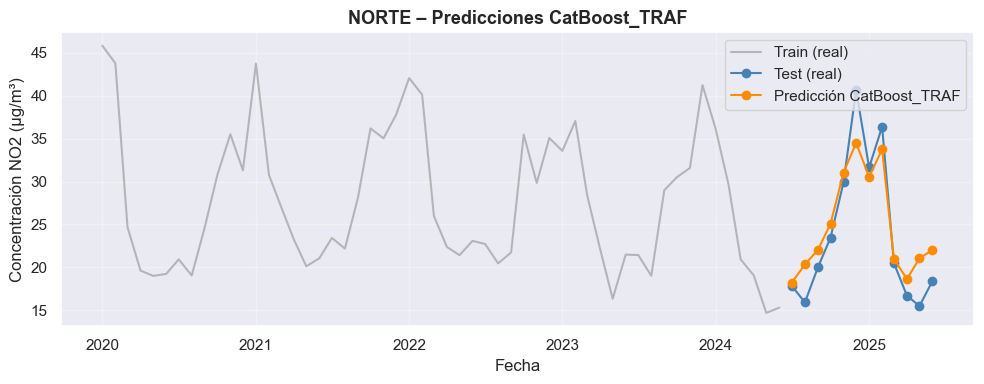

📁 Guardado gráfico: 07_Figs\09_predicciones_tráfico_MAG8\XGBoost_TRAF_NORTE.png


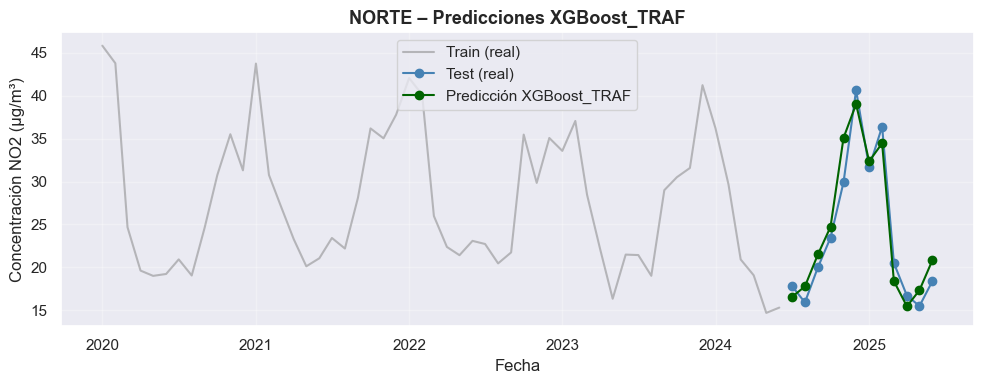

📁 Guardado gráfico: 07_Figs\09_predicciones_tráfico_MAG8\CatBoost_TRAF_CENTRO.png


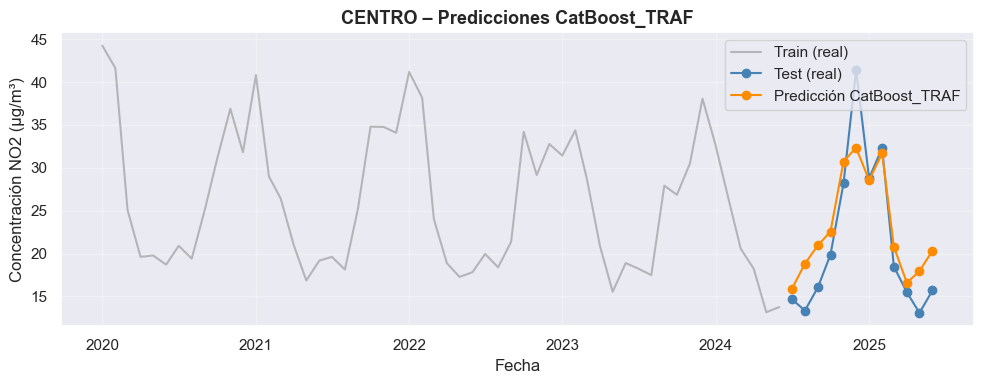

📁 Guardado gráfico: 07_Figs\09_predicciones_tráfico_MAG8\XGBoost_TRAF_CENTRO.png


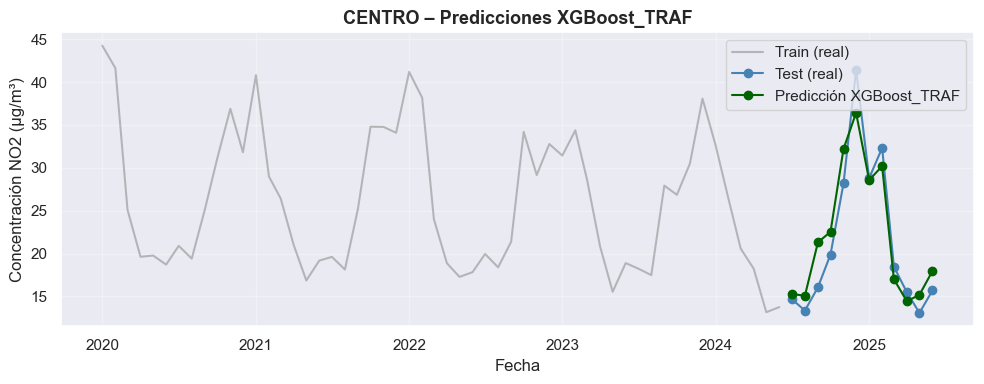

📁 Guardado gráfico: 07_Figs\09_predicciones_tráfico_MAG8\CatBoost_TRAF_SUR.png


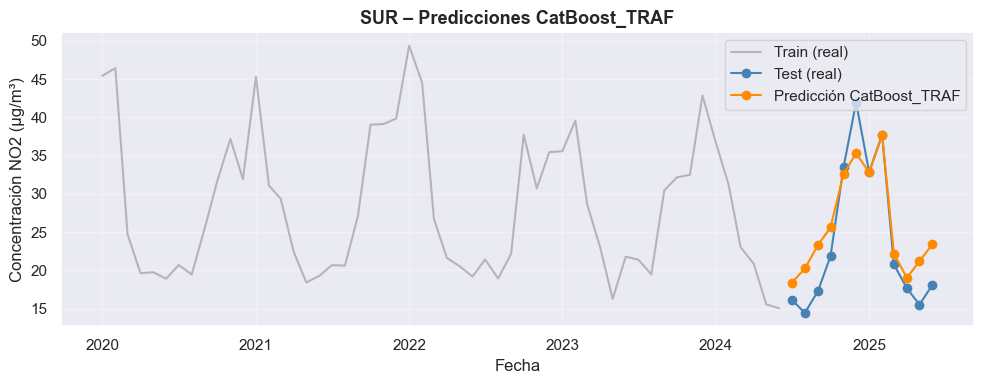

📁 Guardado gráfico: 07_Figs\09_predicciones_tráfico_MAG8\XGBoost_TRAF_SUR.png


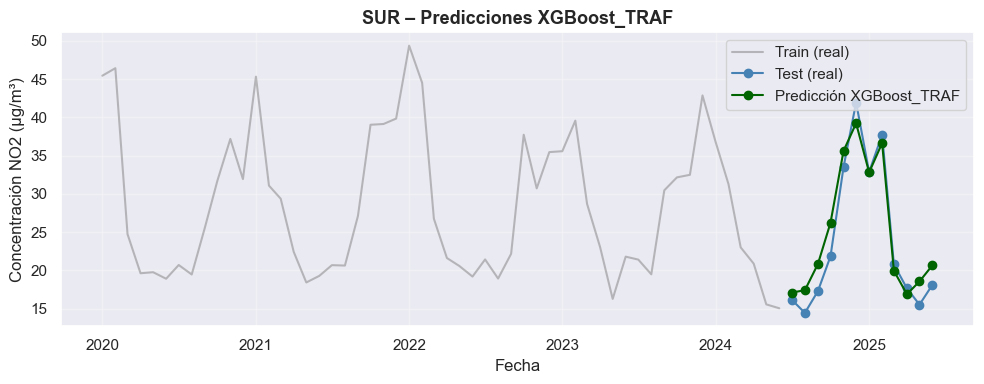

✅ Figuras guardadas en: 07_Figs\09_predicciones_tráfico_MAG8


In [91]:
CARPETA_BASE = "07_Figs"
SUBCARPETA = "09_predicciones_tráfico_MAG8"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)


# ========= Diccionario de modelos y estilos =========

modelos_por_tipo = {
    "CatBoost_TRAF": {
        "repo": cat_models_traf,
        "color": "darkorange"
    },
    "XGBoost_TRAF": {
        "repo": xgb_models_traf,
        "color": "darkgreen"
    }
}

# ========= Representación por zonas y modelos =========
for zona in ["NORTE", "CENTRO", "SUR"]:
    # Series reales de train y test
    y_train = resultados_ml[zona]["y_train"]
    y_test  = resultados_ml[zona]["y_test"]
    X_test  = resultados_ml[zona]["X_test"]

    for nombre_modelo, cfg in modelos_por_tipo.items():
        repo = cfg["repo"]
        color = cfg["color"]

        if zona not in repo:
            print(f"⚠️ {nombre_modelo} no disponible para {zona}; se omite.")
            continue

        modelo = repo[zona]
        y_pred = modelo.predict(X_test)

        plot_predicciones_traf(
            zona=zona,
            y_train=y_train,
            y_test=y_test,
            y_pred=y_pred,
            modelo=nombre_modelo,
            ruta_salida=CARPETA_SALIDA,
            color_pred=color
        )

print(f"✅ Figuras guardadas en: {CARPETA_SALIDA}")

#### PREDICCIÓN HASTA 2032. EVALUACIÓN PREDICCIÓN 2030 - INCLUYENDO TRÁFICO

In [92]:
# -------------------------------
# Parámetros y utilidades
# -------------------------------
ZONAS = ["NORTE", "CENTRO", "SUR"]
FECHA_FIN_PRED = "2032-12-01"   # inclusive (MS)
LAG_PREFIX = "lag_"

# Por si no existe aún:
CARPETA_BASE = "07_Figs"
SUBCARPETA = "09_predicciones_tráfico_MAG8"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

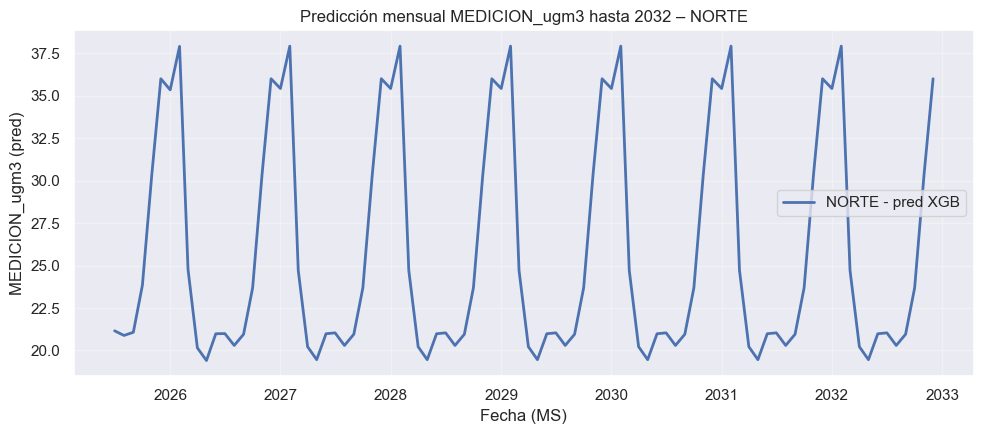

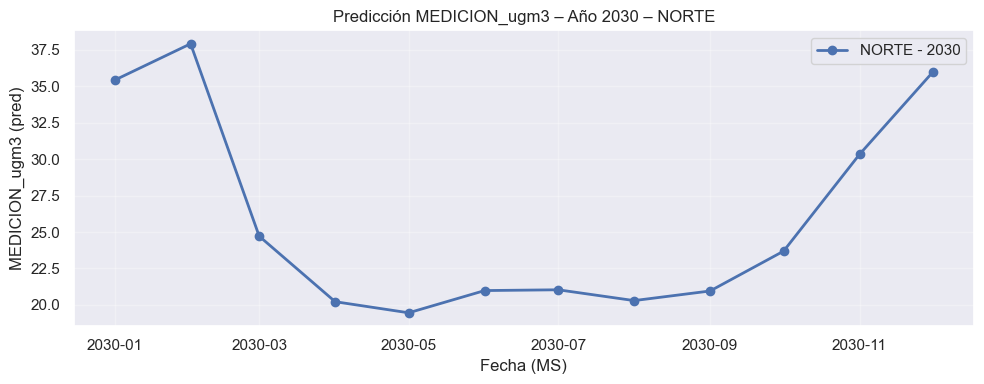

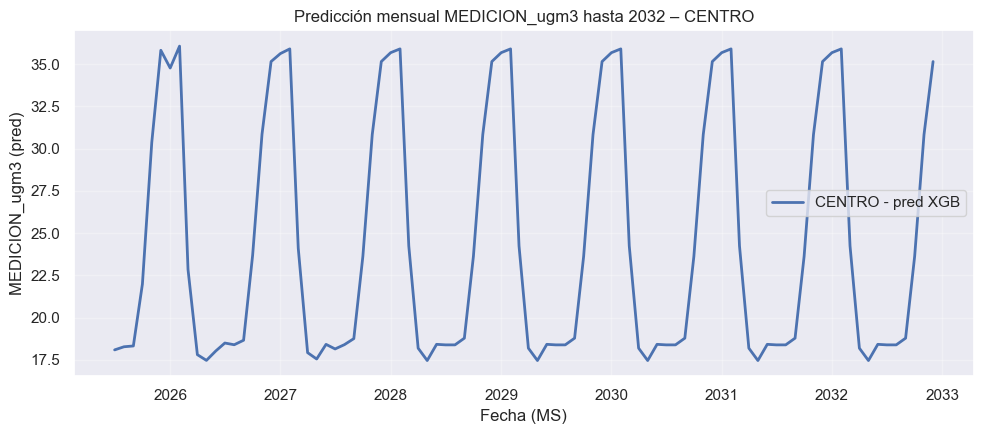

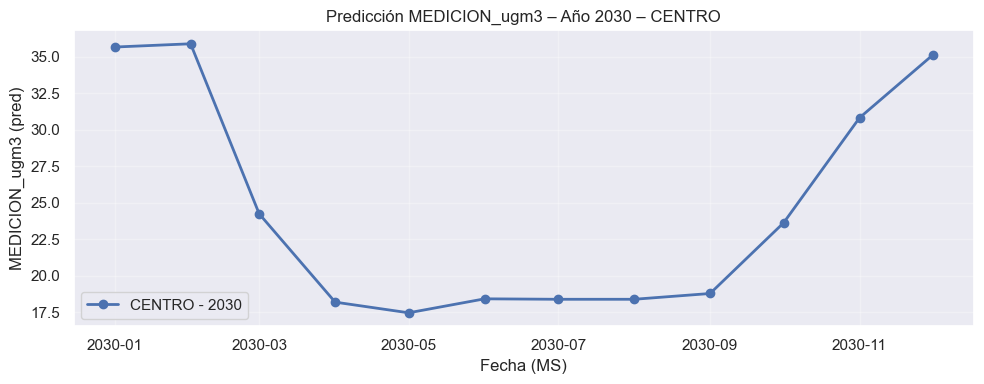

In [ ]:
# ==========================================================
# 1) Predicción mensual hasta 2032 (autorregresiva con lags)
# ==========================================================
preds_futuras_por_zona = {}

for zona in ZONAS:
    modelo = xgb_models_traf[zona]
    cols_modelo = list(resultados_ml[zona]["X_train"].columns)
    lag_cols = _extraer_lags(cols_modelo)

    # 1) Histórico mensual por zona usando TU 'agrupar_mensual'
    df_zona_orig = dfs_traf_2019_NO2[zona].copy()
    df_mensual = agrupar_mensual(df_zona_orig)
    df_mensual["DIA/MES/ANO"] = pd.to_datetime(
        dict(year=df_mensual["year"], month=df_mensual["month"], day=1)
    )
    df_mensual = df_mensual.sort_values("DIA/MES/ANO").reset_index(drop=True)
    if "dow" not in df_mensual.columns:
        df_mensual["dow"] = 0

    # 2) Medias mensuales por columna exógena
    cols_exog_candidatas = [c for c in cols_modelo if not c.startswith(LAG_PREFIX)]
    medias_mensuales = _mapa_medias_mensuales(df_mensual, cols_exog_candidatas, key="month")

    # 3) Rango futuro
    ultima_fecha_hist = df_mensual["DIA/MES/ANO"].max()
    fechas_fut = pd.date_range(
        start=ultima_fecha_hist + pd.offsets.MonthBegin(1),
        end=pd.to_datetime(FECHA_FIN_PRED),
        freq="MS"
    )
    if len(fechas_fut) == 0:
        print(f"⚠️ {zona}: no hay meses futuros respecto a {ultima_fecha_hist.date()}. Se omite.")
        continue

    # 4) Serie histórica del target usando TU 'preparar_serie_mensual'
    serie_hist = preparar_serie_mensual(df_mensual)
    serie_hist.index = pd.DatetimeIndex(serie_hist.index, freq="MS")

    # 5) Roll-forward autorregresivo
    pred_rows = []
    buffer_target = serie_hist.copy()

    for f in fechas_fut:
        fila = _siguiente_fila_exog(
            f=f,
            medias_mensuales=medias_mensuales,
            cols_necesarias=cols_modelo,
            df_hist=df_mensual
        )

        for c in lag_cols:
            n = int(c.split("_")[1])
            try:
                val_lag = buffer_target.loc[f - pd.offsets.DateOffset(months=n)]
            except KeyError:
                val_lag = buffer_target.iloc[-1]
            fila[c] = float(val_lag)

        x_row = {c: fila.get(c, 0.0) for c in cols_modelo}
        X_in = pd.DataFrame([x_row]).astype(np.float32)

        y_pred = float(modelo.predict(X_in)[0])
        pred_rows.append({"DIA/MES/ANO": f, "pred_xgb": y_pred})
        buffer_target.loc[f] = y_pred

    df_pred_fut = pd.DataFrame(pred_rows).sort_values("DIA/MES/ANO").reset_index(drop=True)
    preds_futuras_por_zona[zona] = df_pred_fut

    # --------- Gráfico 1: toda la línea de tiempo futura ----------
    plt.figure(figsize=(10, 4.5))
    plt.plot(df_pred_fut["DIA/MES/ANO"], df_pred_fut["pred_xgb"], linewidth=2, label=f"{zona} - pred XGB")
    plt.title(f"Predicción mensual MEDICION_ugm3 hasta 2032 – {zona}")
    plt.xlabel("Fecha (MS)")
    plt.ylabel("MEDICION_ugm3 (pred)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    ruta_fig1 = os.path.join(CARPETA_SALIDA, f"{zona}_pred_hasta_2032_XGB.png")
    plt.tight_layout()
    plt.savefig(ruta_fig1, dpi=160)
    plt.show()     # 👈 Muestra en pantalla
    plt.close()

    # --------- Gráfico 2: solo año 2030 ----------
    mask_2030 = (df_pred_fut["DIA/MES/ANO"].dt.year == 2030)
    df_2030 = df_pred_fut.loc[mask_2030].copy()

    if not df_2030.empty:
        plt.figure(figsize=(10, 4.0))
        plt.plot(df_2030["DIA/MES/ANO"], df_2030["pred_xgb"], linewidth=2, marker="o", label=f"{zona} - 2030")
        plt.title(f"Predicción MEDICION_ugm3 – Año 2030 – {zona}")
        plt.xlabel("Fecha (MS)")
        plt.ylabel("MEDICION_ugm3 (pred)")
        plt.grid(True, alpha=0.3)
        plt.legend()
        ruta_fig2 = os.path.join(CARPETA_SALIDA, f"{zona}_pred_2030_XGB.png")
        plt.tight_layout()
        plt.savefig(ruta_fig2, dpi=160)
        plt.show()   # 👈 Muestra en pantalla
        plt.close()
    else:
        print(f"ℹ️ {zona}: no hay meses predichos en 2030 (revisa FECHA_FIN_PRED).")

print(f"✅ Figuras guardadas en: {CARPETA_SALIDA}")

# ==========================================================
# 2) Medias anuales 2030 por zona (tabla)
# ==========================================================
resumen_2030 = []
for zona, df_pred in preds_futuras_por_zona.items():
    df_2030 = df_pred[df_pred["DIA/MES/ANO"].dt.year == 2030]
    if not df_2030.empty:
        resumen_2030.append({
            "zona": zona,
            "media_2030_MEDICION_ugm3_pred": df_2030["pred_xgb"].mean()
        })

df_media_2030 = pd.DataFrame(resumen_2030).sort_values("zona").reset_index(drop=True)

print("\n📘 Media anual 2030 de MEDICION_ugm3 (predicción XGB):")
if df_media_2030.empty:
    print("No hay predicciones para 2030. Ajusta FECHA_FIN_PRED.")
else:
    print(df_media_2030.to_string(index=False))

In [ ]:
# ==========================================================
# ⬆️ Añadir promedios 2030 de XGBoost_TRAF a las tablas
#    (a partir de preds_futuras_por_zona ya calculado)
# ==========================================================

# 1) Promedio anual 2030 por zona para XGBoost_TRAF
if not preds_futuras_por_zona:
    raise RuntimeError("preds_futuras_por_zona está vacío. Ejecuta antes el bloque de predicciones XGB.")

df_xgb_pred_all = []
for zona, df_pred in preds_futuras_por_zona.items():
    if "DIA/MES/ANO" not in df_pred or "pred_xgb" not in df_pred:
        continue
    aux = df_pred.copy()
    aux["zona"] = zona
    df_xgb_pred_all.append(aux)

df_xgb_pred_all = pd.concat(df_xgb_pred_all, ignore_index=True)

df_xgb_media_2030 = (
    df_xgb_pred_all[df_xgb_pred_all["DIA/MES/ANO"].dt.year == 2030]
    .groupby("zona", as_index=False)["pred_xgb"]
    .mean()
    .rename(columns={"pred_xgb": "prom_2030"})
)
df_xgb_media_2030["modelo"] = "XGBoost_TRAF"

# 2) Integrar en df_pred_2030_resumen respetando tu esquema de columnas
#    Intentamos detectar el nombre de la columna de promedio 2030 en tu tabla.
if "df_pred_2030_resumen" in globals():
    # Detecta un nombre de columna compatible para el promedio (si existe)
    posibles_cols_prom = [c for c in df_pred_2030_resumen.columns
                          if ("2030" in c) and (("prom" in c.lower()) or ("media" in c.lower()))]
    col_prom = posibles_cols_prom[0] if posibles_cols_prom else "prom_2030"

    # Renombrar si tu tabla usa otro nombre
    if col_prom != "prom_2030":
        df_xgb_media_2030 = df_xgb_media_2030.rename(columns={"prom_2030": col_prom})

    # Asegurar columnas clave
    for col_nec in ["zona", "modelo", col_prom]:
        if col_nec not in df_xgb_media_2030.columns:
            raise ValueError(f"Falta la columna requerida '{col_nec}' para integrar el resumen 2030.")

    # Seleccionar solo columnas compatibles + concatenar sin duplicados exactos
    cols_obj = [c for c in ["zona", "modelo", col_prom] if c in df_pred_2030_resumen.columns or c in df_xgb_media_2030.columns]
    df_pred_2030_resumen = (
        pd.concat([df_pred_2030_resumen, df_xgb_media_2030[cols_obj]], ignore_index=True)
          .drop_duplicates(subset=["zona", "modelo"], keep="last")
          .reset_index(drop=True)
    )
else:
    # Si no existía df_pred_2030_resumen, lo creamos con un esquema mínimo
    df_pred_2030_resumen = df_xgb_media_2030[["zona", "modelo", "prom_2030"]].copy()


#### CUADRO COMPARATIVA RSME MODELOS

In [ ]:
# ==========================================================
# 1️⃣ Convertir listas a DataFrames
# ==========================================================
df_rmse = pd.DataFrame(tabla_rmse_modelos)

# Unir RMSEs de ARIMA/SARIMA + ML + deep learning + tráfico
df_rmse = pd.concat([df_rmse, df_resultados_ml,df_resultados_dl_std], ignore_index=True)
df_rmse = pd.concat(
    [df_rmse, df_resultados_traf],
    ignore_index=True
)

# ==========================================================
# 3️⃣ Ordenar tabla RMSE por zona
# ==========================================================
df_rmse = (
    df_rmse
    .sort_values(by=["zona", "RMSE_test"], ascending=[True, True])
    .drop(columns=["order", "seasonal_order", "AIC","n_train", "n_test"], errors="ignore")
)

# ==========================================================
# 4️⃣ Mostrar resultados
# ==========================================================
print("\n>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<")
print(df_rmse.round(3).to_string(index=False))


### CUADRO COMPARATIVA MODELOS II

In [ ]:

# ==========================================================
# 4️⃣ Mostrar resultados
# ==========================================================
print("\n>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<")
print(df_rmse.round(3).to_string(index=False))

print("\n>>> TABLA RESUMEN DE PROMEDIOS 2030 (agrupada) <<<")
print(df_pred_2030_resumen.round(3).to_string(index=False))

# ==========================================================
# 5️⃣ Filtrar solo los modelos con menor RMSE por zona
# ==========================================================
mejores_modelos_por_zona = (
    df_rmse
    .sort_values(["zona", "RMSE_test"], ascending=[True, True])
    .groupby("zona", as_index=False)
    .first()[["zona", "modelo", "RMSE_test"]]
)

print("\n>>> MODELOS CON MENOR RMSE POR ZONA <<<")
print(mejores_modelos_por_zona.round(3).to_string(index=False))

# ==========================================================
# 6️⃣ Filtrar predicciones 2030 solo de esos modelos
# ==========================================================
df_pred_mejores_2030 = pd.merge(
    mejores_modelos_por_zona[["zona", "modelo"]],
    df_pred_2030_resumen,
    on=["zona", "modelo"],
    how="left"
)

print("\n>>> PREDICCIONES 2030 DE LOS MEJORES MODELOS (por zona) <<<")
print(df_pred_mejores_2030.round(3).to_string(index=False))


## PREDICCIONES MEJORES RESULTADOS

In [ ]:
FECHA_MIN_FULL   = pd.Timestamp("2010-01-01")
FECHA_MIN_TRAF   = pd.Timestamp("2019-01-01")
FECHA_MAX_TODOS  = pd.Timestamp("2025-06-01")  # índice MS
FECHA_FIN_FORE   = "2032-12-31"
LAGS_USADOS      = [1, 2, 3, 12]

CARPETA_BASE   = "07_Figs"
SUBCARPETA     = "10_MEJORES PREDICCIONES_MAG8"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)


In [ ]:
# ==========================================================
# 2) Exógenas por tipo de modelo
# ==========================================================
EXOG_FULL = [
    "VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)",
    "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)",
    "PRESION_MAX (hPa)", "PRESION_MIN (hPa)", "PRESION_MED (hPa)",
    "VIENTO_DIR_10 (°)", "TEMPERATURA_MIN (°C)"
]
EXOG_TRAF = EXOG_FULL + ["TOTAL_HOR_EXT"]

# ==========================================================
# 3) Preparar históricos y X/y por zona
#     - NORTE: df_traf (TRAF, con TOTAL_HOR_EXT)
#     - CENTRO: df_mensuales (FULL)
#     - SUR: df_traf (TRAF) solo para 'df_hist' e IC;
#            el forecast SUR se reutiliza desde `preds_futuras_por_zona["SUR"]`
# ==========================================================
assert "df_mensuales" in globals(), "Falta df_mensuales."
assert "dfs_traf_2019_NO2" in globals(), "Falta dfs_traf_2019_NO2."
assert "agrupar_mensual" in globals(), "Falta agrupar_mensual()."
assert "preparar_datos_ml" in globals(), "Falta preparar_datos_ml()."
assert "forecast_autoregresivo_hasta_2032" in globals(), "Falta forecast_autoregresivo_hasta_2032()."
assert "preds_futuras_por_zona" in globals() and "SUR" in preds_futuras_por_zona, "Falta preds_futuras_por_zona['SUR']."
assert "xgb_TRAF" in globals(), "Falta el modelo entrenado xgb_TRAF."

# ---- NORTE (TRAF) ----
df_norte_traf = dfs_traf_2019_NO2["NORTE"].copy()
df_norte_mensual = agrupar_mensual(df_norte_traf)

df_norte_mensual["DIA/MES/ANO"] = pd.to_datetime(
    dict(year=df_norte_mensual["year"], month=df_norte_mensual["month"], day=1)
)
df_norte_mensual = (
    df_norte_mensual
    .sort_values(["year", "month"])
    .set_index("DIA/MES/ANO")
)

Xtr_norte, ytr_norte, Xte_norte, yte_norte, df_ml_norte = preparar_datos_ml(
    df_norte_mensual.reset_index(),
    fecha_corte="2024-06-30",
    lags=LAGS_USADOS,
    usar_columnas_exogenas=EXOG_TRAF
)
df_ml_norte = df_ml_norte.sort_index()
df_ml_norte_hist = _slice_hist(df_ml_norte, FECHA_MIN_TRAF, FECHA_MAX_TODOS)

# ---- CENTRO (FULL) ----
df_centro_full = df_mensuales["CENTRO"].copy()
Xtr_centro, ytr_centro, Xte_centro, yte_centro, df_ml_centro = preparar_datos_ml(
    df_centro_full,
    fecha_corte="2024-06-30",
    lags=LAGS_USADOS,
    usar_columnas_exogenas=EXOG_FULL
)
df_ml_centro = df_ml_centro.sort_index()
df_ml_centro_hist = _slice_hist(df_ml_centro, FECHA_MIN_FULL, FECHA_MAX_TODOS)

# ---- SUR (TRAF) ---- (solo para histórico/IC)
df_sur_traf = dfs_traf_2019_NO2["SUR"].copy()
df_sur_mensual = agrupar_mensual(df_sur_traf)
df_sur_mensual["DIA/MES/ANO"] = pd.to_datetime(
    dict(year=df_sur_mensual["year"], month=df_sur_mensual["month"], day=1)
)
df_sur_mensual = (
    df_sur_mensual
    .sort_values(["year", "month"])
    .set_index("DIA/MES/ANO")
)

Xtr_sur, ytr_sur, Xte_sur, yte_sur, df_ml_sur = preparar_datos_ml(
    df_sur_mensual.reset_index(),
    fecha_corte="2024-06-30",
    lags=LAGS_USADOS,
    usar_columnas_exogenas=EXOG_TRAF
)
df_ml_sur = df_ml_sur.sort_index()
df_ml_sur_hist = _slice_hist(df_ml_sur, FECHA_MIN_TRAF, FECHA_MAX_TODOS)

# ==========================================================
# 4) Modelos entrenados y feature_cols
#    - NORTE: XGBoost_TRAF (xgb_TRAF)
#    - CENTRO: XGBoost "full" (modelos_entrenados["CENTRO"]["XGBoost"])
#    - SUR: XGBoost_TRAF (xgb_TRAF) 
# ==========================================================
assert "modelos_entrenados" in globals(), "Falta modelos_entrenados."
assert "XGBoost" in modelos_entrenados["CENTRO"], "Falta modelos_entrenados['CENTRO']['XGBoost']"

modelo_norte  = xgb_TRAF           
modelo_centro = modelos_entrenados["CENTRO"]["XGBoost"]
modelo_sur    = xgb_TRAF            

feat_norte  = cols_del_modelo(modelo_norte,  X_fallback=Xtr_norte)
feat_centro = cols_del_modelo(modelo_centro, X_fallback=Xtr_centro)
feat_sur    = cols_del_modelo(modelo_sur,    X_fallback=Xtr_sur)

Xtr_norte_al  = alinear_X_a_features(Xtr_norte,  feat_norte)
Xtr_centro_al = alinear_X_a_features(Xtr_centro, feat_centro)
Xtr_sur_al    = alinear_X_a_features(Xtr_sur,    feat_sur)

# ==========================================================
# 5) Forecast NORTE/CENTRO (autorregresivo) y SUR desde cache
# ==========================================================
# NORTE: forecast desde tu cálculo previo (preds_futuras_por_zona["NORTE"])
df_norte_from_cache = preds_futuras_por_zona["NORTE"].copy()

# Asegurar que la columna de fecha existe
if "DIA/MES/ANO" not in df_norte_from_cache.columns:
    df_norte_from_cache = (
        df_norte_from_cache
        .reset_index()
        .rename(columns={"index": "DIA/MES/ANO"})
    )

# Parsear fecha
df_norte_from_cache["DIA/MES/ANO"] = pd.to_datetime(
    df_norte_from_cache["DIA/MES/ANO"],
    errors="coerce"
)

# Orden temporal
df_norte_from_cache = df_norte_from_cache.sort_values("DIA/MES/ANO")

# Renombrar pred_xgb → pred si procede
if "pred_xgb" in df_norte_from_cache.columns and "pred" not in df_norte_from_cache.columns:
    df_norte_from_cache = df_norte_from_cache.rename(columns={"pred_xgb": "pred"})

# Convertir a serie con índice datetime mensual
df_fore_norte = df_norte_from_cache.set_index("DIA/MES/ANO")
df_fore_norte.index = pd.DatetimeIndex(df_fore_norte.index, freq="MS")

# CENTRO: forecast con XGBoost "full"
df_fore_centro = forecast_autoregresivo_hasta_2032(
    df_ml_hist=df_ml_centro_hist,
    modelo_entrenado=modelo_centro,
    feature_cols=feat_centro,
    fecha_fin_forecast=FECHA_FIN_FORE,
    lags=LAGS_USADOS,
    usar_columnas_exogenas=[c for c in EXOG_FULL if c in df_ml_centro_hist.columns]
)

# SUR: desde tu cálculo previo (preds_futuras_por_zona["SUR"] con pred_xgb)
df_sur_from_cache = preds_futuras_por_zona["SUR"].copy()
if "DIA/MES/ANO" not in df_sur_from_cache.columns:
    df_sur_from_cache = df_sur_from_cache.reset_index().rename(columns={"index": "DIA/MES/ANO"})
df_sur_from_cache["DIA/MES/ANO"] = pd.to_datetime(df_sur_from_cache["DIA/MES/ANO"], errors="coerce")
df_sur_from_cache = df_sur_from_cache.sort_values("DIA/MES/ANO")
if "pred_xgb" in df_sur_from_cache.columns and "pred" not in df_sur_from_cache.columns:
    df_sur_from_cache = df_sur_from_cache.rename(columns={"pred_xgb": "pred"})
df_fore_sur = df_sur_from_cache.set_index("DIA/MES/ANO")
df_fore_sur.index = pd.DatetimeIndex(df_fore_sur.index, freq="MS")

# Unificación
predicciones_futuras_ml = {
    "NORTE": {"modelo": "XGBoost_TRAF",   "forecast": df_fore_norte},
    "CENTRO":{"modelo": "XGBoost",   "forecast": df_fore_centro},
    "SUR":   {"modelo": "XGBoost_TRAF",   "forecast": df_fore_sur},
}

# ==========================================================
# 6) Gráficos por zona con IC (mostrar + guardar)
# ==========================================================
plot_largo_por_zona_ml(
    zona="NORTE", df_hist=df_ml_norte_hist, modelo_entrenado=modelo_norte,
    X_train=Xtr_norte_al, y_train=ytr_norte,
    df_forecast=df_fore_norte, nombre_modelo="XGBoost_TRAF",
    ruta_salida_dir=CARPETA_SALIDA, feature_cols=feat_norte, mostrar=True
)
plot_largo_por_zona_ml(
    zona="CENTRO", df_hist=df_ml_centro_hist, modelo_entrenado=modelo_centro,
    X_train=Xtr_centro_al, y_train=ytr_centro,
    df_forecast=df_fore_centro, nombre_modelo="XGBoost",
    ruta_salida_dir=CARPETA_SALIDA, feature_cols=feat_centro, mostrar=True
)
# Para SUR: forecast del cache + IC con residuales del modelo TRAF
plot_largo_por_zona_ml(
    zona="SUR", df_hist=df_ml_sur_hist, modelo_entrenado=modelo_sur,
    X_train=Xtr_sur_al, y_train=ytr_sur,
    df_forecast=df_fore_sur, nombre_modelo="XGBoost_TRAF",
    ruta_salida_dir=CARPETA_SALIDA, feature_cols=feat_sur, mostrar=True
)

print(f"\n✅ Figuras guardadas en: {CARPETA_SALIDA}")

# ==========================================================
# 7) Media anual 2030 con tu método original
#    (busca 'pred_xgb' si existe; si no, 'pred')
# ==========================================================
resumen_2030 = []
for zona, pack in predicciones_futuras_ml.items():
    df_pred = pack["forecast"].copy()
    if "DIA/MES/ANO" not in df_pred.columns:
        df_pred = df_pred.reset_index().rename(columns={"index": "DIA/MES/ANO"})
    df_pred["DIA/MES/ANO"] = pd.to_datetime(df_pred["DIA/MES/ANO"], errors="coerce")

    df_2030 = df_pred[df_pred["DIA/MES/ANO"].dt.year == 2030]
    if not df_2030.empty:
        col_pred = "pred_xgb" if "pred_xgb" in df_2030.columns else "pred"
        resumen_2030.append({
            "zona": zona,
            "media_2030_MEDICION_ugm3_pred": df_2030[col_pred].mean()
        })

df_media_2030 = (
    pd.DataFrame(resumen_2030)
      .sort_values("zona")
      .reset_index(drop=True)
)

print("\n📘 Media anual 2030 de MEDICION_ugm3 (XGBoost_TRAF NORTE/SUR, XGBoost CENTRO):")
if df_media_2030.empty:
    print("No hay predicciones para 2030. Revisa FECHA_FIN_FORE.")
else:
    print(df_media_2030.to_string(index=False))


In [ ]:
# ===============================
# Comparativo ANUAL 2025–2032
# ===============================

# Construir tabla anual para las 3 zonas
anual_rows = []
for zona in ["NORTE", "CENTRO", "SUR"]:
    df_fore = predicciones_futuras_ml[zona]["forecast"].copy()
    s_year = _media_anual(df_fore)
    # Recorte 2025..2032
    s_year = s_year.loc[lambda s: (s.index >= 2025) & (s.index <= 2032)]
    for y, val in s_year.items():
        anual_rows.append({"zona": zona, "year": int(y), "media_pred": float(val)})

df_anual = pd.DataFrame(anual_rows).sort_values(["year", "zona"])
if df_anual.empty:
    print("⚠️ No hay datos para 2025–2032 en alguna zona.")
else:
    # Pivot opcional para inspección
    df_anual_piv = df_anual.pivot(index="year", columns="zona", values="media_pred").sort_index()
    print("\n>>> Medias ANUALES 2025–2032 (µg/m³) <<<")
    print(df_anual_piv.round(3).to_string())

    # Plot
    plt.figure(figsize=(10.5, 4.6))
    for zona in ["NORTE", "CENTRO", "SUR"]:
        dfz = df_anual[df_anual["zona"] == zona]
        if not dfz.empty:
            plt.plot(dfz["year"], dfz["media_pred"], marker="o", linewidth=2, label=zona)

    plt.title("Predicción anual media MEDICION_ugm3 (2025–2032)")
    plt.xlabel("Año"); plt.ylabel("Media anual predicha (µg/m³)")
    plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout()

    ruta_fig = os.path.join(CARPETA_SALIDA, "Comparativo_anual_2025_2032.png")
    plt.savefig(ruta_fig, dpi=160)
    plt.show()
    plt.close()
    print(f"📁 Guardado: {ruta_fig}")


In [ ]:
# ===============================
# Comparativo MENSUAL año 2030
# ===============================

mensual_rows = []
for zona in ["NORTE", "CENTRO", "SUR"]:
    df_fore = predicciones_futuras_ml[zona]["forecast"].copy()

    # Asegurar columna de fecha para filtrar por año, si fuera necesario
    if "DIA/MES/ANO" not in df_fore.columns:
        df_fore = df_fore.reset_index().rename(columns={"index": "DIA/MES/ANO"})
    df_fore["DIA/MES/ANO"] = pd.to_datetime(df_fore["DIA/MES/ANO"], errors="coerce")

    # Filtrar 2030
    df_2030 = df_fore[df_fore["DIA/MES/ANO"].dt.year == 2030].copy()
    if df_2030.empty:
        print(f"ℹ️ {zona}: no hay meses predichos en 2030.")
        continue

    # Asegurar orden mensual y extraer mes numérico (1..12)
    df_2030 = df_2030.sort_values("DIA/MES/ANO")
    df_2030["month"] = df_2030["DIA/MES/ANO"].dt.month

    for m, val in zip(df_2030["month"].values, df_2030["pred"].values):
        mensual_rows.append({"zona": zona, "month": int(m), "pred": float(val)})

df_mensual_2030 = pd.DataFrame(mensual_rows).sort_values(["month", "zona"])
if df_mensual_2030.empty:
    print("⚠️ No hay datos mensuales para 2030.")
else:
    # Pivot opcional para inspección
    df_mensual_2030_piv = df_mensual_2030.pivot(index="month", columns="zona", values="pred").sort_index()
    print("\n>>> Predicción MENSUAL 2030 (µg/m³) <<<")
    print(df_mensual_2030_piv.round(3).to_string())

    # Plot
    plt.figure(figsize=(10.5, 4.6))
    xticks = range(1, 13)
    for zona in ["NORTE", "CENTRO", "SUR"]:
        dfz = df_mensual_2030[df_mensual_2030["zona"] == zona]
        if not dfz.empty:
            plt.plot(dfz["month"], dfz["pred"], marker="o", linewidth=2, label=zona)

    plt.title("Predicción mensual MEDICION_ugm3 – Año 2030")
    plt.xlabel("Mes (1–12)"); plt.ylabel("Predicción mensual (µg/m³)")
    plt.xticks(xticks)
    plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout()

    ruta_fig = os.path.join(CARPETA_SALIDA, "Comparativo_mensual_2030.png")
    plt.savefig(ruta_fig, dpi=160)
    plt.show()
    plt.close()
    print(f"📁 Guardado: {ruta_fig}")


In [ ]:
df_pred_sur = predicciones_largo_plazo ["SUR"]["pred"].copy()
df_pred_sur.index = pd.to_datetime(df_pred_sur.index)

In [ ]:
df_NO2_sur = df_pred_sur

In [ ]:
df_NO2_sur = df_NO2_sur.to_frame(name="pred")

In [ ]:
df_NO2_sur

In [ ]:
df_NO2_sur.to_parquet("07.03_df_NO2_sur.parquet", engine="pyarrow", index=False)